# <font size=14><font color=blue>Real Estate Price Prediction</font></font> 

### <font size=5><font color=blue>Course "Python Libraries for Data Science: Numpy, Matplotlib, Scikit-learn"</font></font> 

### <font size=5><font color=blue>AI specialization. GeekBrains</font></font> 

***

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import pickle

%matplotlib inline

***

### <font color=green>NB!</font> 
### <font color=green>The notebook was prepared following the working process. So, it contents notes about changes in data preparation and modeling, numerated by predictions starting from Pred_61</font> 

# <font color=blue>Lazy part</font> 

### What do we have doing nothing?

#### Data loading

In [2]:
df = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

In [3]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [4]:
_ = reduce_mem_usage(df)

Memory usage of dataframe is 1.53 MB
Memory usage after optimization is: 0.49 MB
Decreased by 68.1%


In [5]:
_ = reduce_mem_usage(df_test)

Memory usage of dataframe is 0.72 MB
Memory usage after optimization is: 0.21 MB
Decreased by 70.3%


#### Loading modules for simple model and pretest function

In [6]:
from sklearn.ensemble import RandomForestRegressor, VotingRegressor
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split, KFold, GridSearchCV, cross_val_score
from lightgbm import LGBMRegressor

#### To control every transformation step for its impact on the model we construct "pretest' function

In [7]:
r2_results = pd.DataFrame(columns = ['R2_score','STD', 'R2_Improving', 'STD_Improving', 'Action'])

In [8]:
def simple_model(df,
            min_samples_leaf=10,
            random_state=42,
            n_estimators= 120,
            max_depth = 7):
    X = df.drop('Price', axis=1)
    y = df[['Price']]
    X.set_index('Id', inplace=True)

    lgb_model = LGBMRegressor(criterion='r2',
                                min_samples_leaf = min_samples_leaf,
                                random_state = random_state,
                                n_estimators = n_estimators,
                                max_depth = max_depth
                            )

    cv_score = cross_val_score(lgb_model, X, y, 
                           scoring='r2', 
                           cv=KFold(n_splits=5, shuffle=True, random_state=42))

    mean = cv_score.mean()
    std = cv_score.std()

    print('R2: {:.3f} +- {:.3f}'.format(mean, std))
    
    return lgb_model, cv_score

In [9]:
simple_model(df)

R2: 0.750 +- 0.020


(LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               criterion='r2', importance_type='split', learning_rate=0.1,
               max_depth=7, min_child_samples=20, min_child_weight=0.001,
               min_samples_leaf=10, min_split_gain=0.0, n_estimators=120,
               n_jobs=-1, num_leaves=31, objective=None, random_state=42,
               reg_alpha=0.0, reg_lambda=0.0, silent=True, subsample=1.0,
               subsample_for_bin=200000, subsample_freq=0),
 array([0.73210054, 0.74110978, 0.74690782, 0.74308418, 0.78801615]))

In [10]:
def pretest(df, action, model = 0,
            r2_results = r2_results):

    lgb_model, cv_score = simple_model(df)
    
    new_index = r2_results['Action'].count()
    if new_index > 0:
        r2_results.loc[new_index] = [
                                     cv_score.mean(),
                                     cv_score.std(),
                                     cv_score.mean() - r2_results.loc[new_index - 1, 'R2_score'],
                                     - (cv_score.std() - r2_results.loc[new_index - 1, 'STD']),
                                     action
                                    ]
    else:
        r2_results.loc[new_index] = [
                                     cv_score.mean(),
                                     cv_score.std(),
                                     cv_score.mean(),
                                     - cv_score.std(),
                                     action
                                    ]
    
    print(f'Action N{new_index}\n')
    return r2_results.tail(1)

In [11]:
def pretest_cancel():
    r2_results.drop(r2_results.tail(1).index, axis= 'index', inplace= True)
    return 'The changes has been canceled'

In [12]:
pretest(df, 'Initial')

R2: 0.750 +- 0.020
Action N0



,R2_score,STD,R2_Improving,STD_Improving,Action
0,0.750244,0.019503,0.750244,-0.019503,Initial


***

# <font color=blue>Initial data exploration and correction</font> 

### Data description

Id - идентификационный номер квартиры  
DistrictId - идентификационный номер района  
Rooms - количество комнат  
Square - площадь  
LifeSquare - жилая площадь  
KitchenSquare - площадь кухни  
Floor - этаж  
HouseFloor - количество этажей в доме  
HouseYear - год постройки дома  
Ecology_1, Ecology_2, Ecology_3 - экологические показатели местности  
Social_1, Social_2, Social_3 - социальные показатели местности  
Healthcare_1, Helthcare_2 - показатели местности, связанные с охраной здоровья  
Shops_1, Shops_2 - показатели, связанные с наличием магазинов, торговых центров  
Price - цена квартиры

In [13]:
df.shape

(10000, 20)

In [14]:
df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,14038,35,2.0,47.981560,29.442751,6.0,7,9.0,1969,0.089040,B,B,33,7976,5,NaN,0,11,B,184966.937500
1,15053,41,3.0,65.683640,40.049541,8.0,7,9.0,1978,0.000070,B,B,46,10309,1,240.0,1,16,B,300009.437500
2,4765,53,2.0,44.947952,29.197611,0.0,8,12.0,1968,0.049637,B,B,34,7759,0,229.0,1,3,B,220925.906250
3,5809,58,2.0,53.352982,52.731510,9.0,8,17.0,1977,0.437885,B,B,23,5735,3,1084.0,0,5,B,175616.234375
4,10783,99,1.0,39.649193,23.776169,7.0,11,12.0,1976,0.012339,B,B,35,5776,1,2078.0,2,4,B,150226.531250


In [15]:
df.tail()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
9995,77,32,2.0,50.401787,30.476204,5.0,6,5.0,1968,0.135650,B,B,46,7960,6,350.0,3,11,B,196684.312500
9996,6159,18,1.0,41.521545,20.539215,9.0,13,13.0,2000,0.000000,B,B,30,5562,0,NaN,0,5,A,189050.296875
9997,5123,27,1.0,47.939007,NaN,1.0,12,16.0,2015,0.072158,B,B,2,629,1,NaN,0,0,A,159143.812500
9998,5400,75,2.0,43.602562,33.840149,8.0,1,5.0,1961,0.307467,B,A,30,5048,9,325.0,2,5,B,181595.343750
9999,6306,128,1.0,38.666645,21.157875,8.0,7,17.0,1990,0.000000,B,B,27,4798,0,30.0,2,8,B,218714.078125


In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
Id               10000 non-null int16
DistrictId       10000 non-null int16
Rooms            10000 non-null float32
Square           10000 non-null float32
LifeSquare       7887 non-null float32
KitchenSquare    10000 non-null float32
Floor            10000 non-null int8
HouseFloor       10000 non-null float32
HouseYear        10000 non-null int32
Ecology_1        10000 non-null float32
Ecology_2        10000 non-null category
Ecology_3        10000 non-null category
Social_1         10000 non-null int8
Social_2         10000 non-null int16
Social_3         10000 non-null int16
Healthcare_1     5202 non-null float32
Helthcare_2      10000 non-null int8
Shops_1          10000 non-null int8
Shops_2          10000 non-null category
Price            10000 non-null float32
dtypes: category(3), float32(8), int16(4), int32(1), int8(4)
memory usage: 498.4 KB


***

#####  <font color=red>!!! Attenton !!! Correction !!!</font> 
#####  <font color=red>Rename column 'Helthcare_2' to 'Healthcare_2' (spelling)</font> 

#### Here and later for 'touching' the correction we use "correction" function. If the result is successful we will apply this function to df and df_test. 

In [17]:
def correction(df):
    df.rename(columns = {'Helthcare_2':'Healthcare_2'}, inplace = True)
    return(df)
#------------------------------------------------------------------
df = correction(df)
df_test = correction(df_test)
#------------------------------------------------------------------

In [18]:
pretest(df, "Rename column 'Helthcare_2' to 'Healthcare_2' (spelling)")

R2: 0.750 +- 0.020
Action N1



,R2_score,STD,R2_Improving,STD_Improving,Action
1,0.750244,0.019503,0.0,-0.0,Rename column 'Helthcare_2' to 'Healthcare_2' ...


***

#### Binary variables

In [19]:
df.select_dtypes(include='object').head(0)

""


In [20]:
df['Ecology_2'].value_counts()

B    9903
A      97
Name: Ecology_2, dtype: int64

In [21]:
df['Ecology_3'].value_counts()

B    9725
A     275
Name: Ecology_3, dtype: int64

In [22]:
df['Shops_2'].value_counts()

B    9175
A     825
Name: Shops_2, dtype: int64

***

#####  <font color=red>!!! Attenton !!! Correction !!!</font> 
#####  <font color=red>Replace all categorical variables by binary</font>

In [23]:
def correction(df):
    df.replace({'Ecology_2':{'A' : 1, 'B' : 0}}, inplace=True)
    df.replace({'Ecology_3':{'A' : 1, 'B' : 0}}, inplace=True)
    df.replace({'Shops_2':{'A' : 1, 'B' : 0}}, inplace=True)
    return(df)
#------------------------------------------------------------------
df = correction(df)
df_test = correction(df_test)
#------------------------------------------------------------------

In [24]:
pretest(df, "Replace all categorical variables by binary")

R2: 0.750 +- 0.020
Action N2



,R2_score,STD,R2_Improving,STD_Improving,Action
2,0.750244,0.019503,0.0,-0.0,Replace all categorical variables by binary


***

In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
Id               10000 non-null int16
DistrictId       10000 non-null int16
Rooms            10000 non-null float32
Square           10000 non-null float32
LifeSquare       7887 non-null float32
KitchenSquare    10000 non-null float32
Floor            10000 non-null int8
HouseFloor       10000 non-null float32
HouseYear        10000 non-null int32
Ecology_1        10000 non-null float32
Ecology_2        10000 non-null int64
Ecology_3        10000 non-null int64
Social_1         10000 non-null int8
Social_2         10000 non-null int16
Social_3         10000 non-null int16
Healthcare_1     5202 non-null float32
Healthcare_2     10000 non-null int8
Shops_1          10000 non-null int8
Shops_2          10000 non-null int64
Price            10000 non-null float32
dtypes: float32(8), int16(4), int32(1), int64(3), int8(4)
memory usage: 703.2 KB


In [26]:
df['Ecology_2'].value_counts()

0    9903
1      97
Name: Ecology_2, dtype: int64

***

#### Reducing memory usage function

In [27]:
reduce_mem_usage(df)
df.info()

Memory usage of dataframe is 0.69 MB
Memory usage after optimization is: 0.49 MB
Decreased by 29.2%
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
Id               10000 non-null int16
DistrictId       10000 non-null int16
Rooms            10000 non-null float32
Square           10000 non-null float32
LifeSquare       7887 non-null float32
KitchenSquare    10000 non-null float32
Floor            10000 non-null int8
HouseFloor       10000 non-null float32
HouseYear        10000 non-null int32
Ecology_1        10000 non-null float32
Ecology_2        10000 non-null int8
Ecology_3        10000 non-null int8
Social_1         10000 non-null int8
Social_2         10000 non-null int16
Social_3         10000 non-null int16
Healthcare_1     5202 non-null float32
Healthcare_2     10000 non-null int8
Shops_1          10000 non-null int8
Shops_2          10000 non-null int8
Price            10000 non-null float32
dtypes: float32(8), int16

***

# <font color=blue>Missing data</font>  

In [28]:
df.loc[:, df.isnull().sum() != 0].isnull().sum()/df.shape[0]

LifeSquare      0.2113
Healthcare_1    0.4798
dtype: float64

### <font color=green>NB!</font>
#### <font color=green>For pred_7 Healthcare_1 analysis is done later</font> 

***

### <font color=blue>LifeSquare (and Square)</font> 

In [29]:
df[['LifeSquare']].describe()

,LifeSquare
count,7887.000000
mean,37.199596
std,86.241112
min,0.370619
25%,22.769833
50%,32.781261
75%,45.128803
max,7480.592285


In [30]:
df.loc[df['LifeSquare']>200, ['LifeSquare', 'Square']]

,LifeSquare,Square
590,263.542023,48.449875
1981,211.231125,212.932358
1982,233.949310,275.645294
4328,7480.592285,81.694420
4690,410.639740,409.425171
6977,638.163208,641.065186
8437,461.463623,78.059334
9910,201.627365,200.334534


##### <font color=red> !!!4328 should be fixed later</font>

C:\Users\Me\Anaconda3\lib\site-packages\numpy\lib\histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\Me\Anaconda3\lib\site-packages\numpy\lib\histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


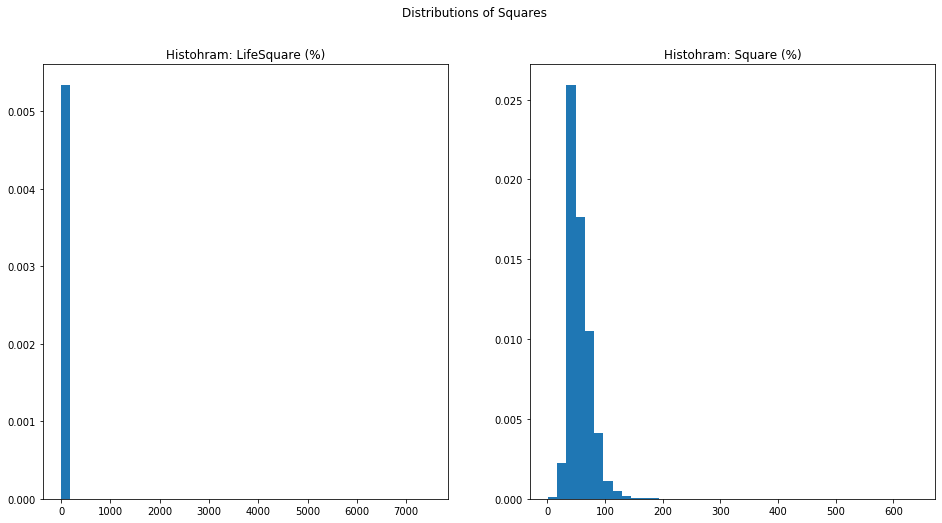

In [31]:
plt.figure(figsize = (16, 8))

plt.subplot(121)
plt.hist(df['LifeSquare'], bins = 40, density=True)
plt.title("Histohram: LifeSquare (%)")

plt.subplot(122)
plt.hist(df['Square'], bins = 40, density=True)
plt.title("Histohram: Square (%)")

plt.suptitle('Distributions of Squares')
plt.show()

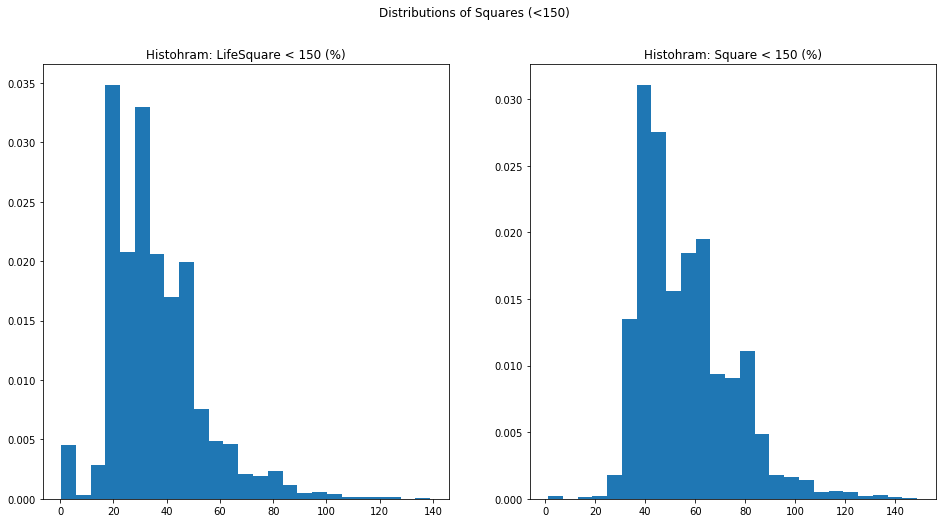

In [32]:
plt.figure(figsize = (16, 8))

plt.subplot(121)
plt.hist(df.loc[df['LifeSquare']<150, 'LifeSquare'], bins = 25, density=True)
plt.title("Histohram: LifeSquare < 150 (%)")

plt.subplot(122)
plt.hist(df.loc[df['Square']<150, 'Square'], bins = 25, density=True)
plt.title("Histohram: Square < 150 (%)")

plt.suptitle('Distributions of Squares (<150)')
plt.show()

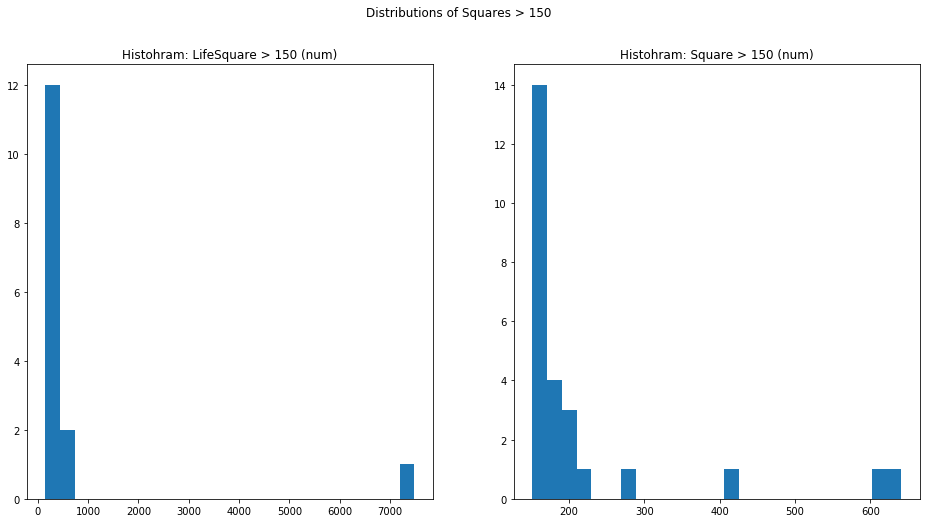

In [33]:
plt.figure(figsize = (16, 8))

plt.subplot(121)
plt.hist(df.loc[df['LifeSquare']>150, 'LifeSquare'], bins = 25, density=False)
plt.title("Histohram: LifeSquare > 150 (num)")

plt.subplot(122)
plt.hist(df.loc[df['Square']>150, 'Square'], bins = 25, density=False)
plt.title("Histohram: Square > 150 (num)")

plt.suptitle('Distributions of Squares > 150')
plt.show()

In [34]:
print(f"LifeSquare > 150: {df.loc[df['LifeSquare'] > 150, 'LifeSquare'].count()} observations")
df.loc[df['LifeSquare'] > 150, ['LifeSquare', 'Square', 'Price']]

LifeSquare > 150: 15 observations


,LifeSquare,Square,Price
590,263.542023,48.449875,141780.234375
1641,174.837082,174.649521,232766.187500
1981,211.231125,212.932358,302211.250000
1982,233.949310,275.645294,455264.875000
2603,161.504227,163.495331,207007.953125
3651,170.713654,169.509933,200800.671875
4047,161.155273,163.286972,228572.515625
4328,7480.592285,81.694420,217357.500000
4690,410.639740,409.425171,90470.429688
5444,153.685837,156.636581,502523.562500


##### <font color=red>!!!!! Check later 590, 6332 and others</font> 

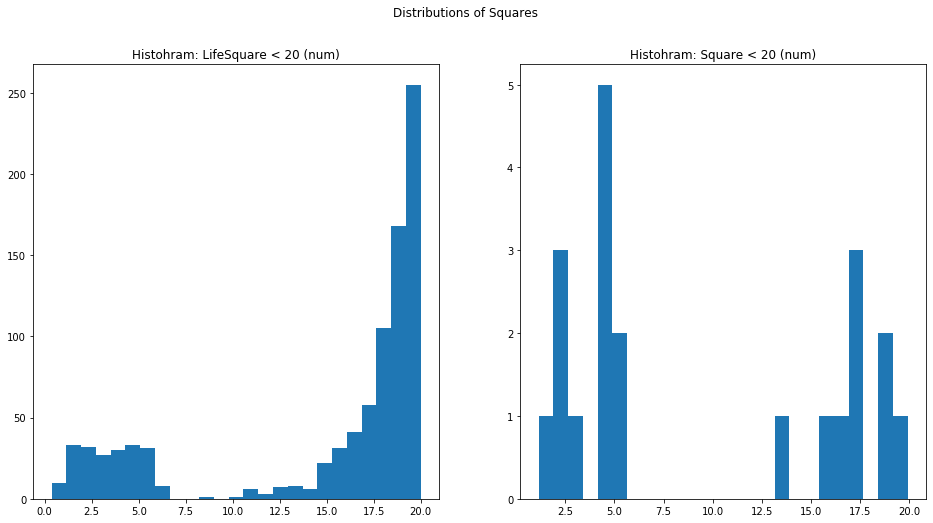

In [35]:
plt.figure(figsize = (16, 8))

plt.subplot(121)
plt.hist(df.loc[df['LifeSquare']<20, 'LifeSquare'], bins = 25, density=False)
plt.title("Histohram: LifeSquare < 20 (num)")

plt.subplot(122)
plt.hist(df.loc[df['Square']<20, 'Square'], bins = 25, density=False)
plt.title("Histohram: Square < 20 (num)")

plt.suptitle('Distributions of Squares')
plt.show()

##### <font color=red>Looks like LifeSquare 0.0-7.5 is misdistributed</font>  

In [36]:
print(f"LifeSquare < 7.5: {df.loc[df['LifeSquare']<7.5, 'LifeSquare'].count()} observations")
df.loc[df['LifeSquare']<7.5, ['LifeSquare', 'Square']].head(20)

LifeSquare < 7.5: 204 observations


,LifeSquare,Square
26,0.641822,106.958870
95,4.091945,61.334969
134,5.589324,65.496674
158,4.896202,51.991066
160,3.987101,66.419838
270,5.941401,46.692974
279,4.634048,79.521217
363,1.251846,44.171791
475,4.008230,64.049698
477,2.286357,63.419552


In [37]:
print(f"Square < 7.5: {df.loc[df['Square']<7.5, 'Square'].count()} observations")
df.loc[df['Square']<7.5, ['LifeSquare', 'Square']].head(20)

Square < 7.5: 12 observations


,LifeSquare,Square
212,67.628716,5.497061
1316,1.969969,4.633498
1608,4.604943,2.596351
3280,40.805836,4.380726
3413,5.549458,5.129221
4853,0.873147,2.377248
4900,5.610772,4.390331
6392,4.525736,1.136859
8030,79.767967,4.823679
8283,2.642219,1.988943


***

## <font color=green>Idea:</font> 
##### <font color=green>Drop all observations with both LifeSquare and Square \< 7.5</font>  

In [38]:
def correction(df):
    df.drop((df[df['Square']<7.5].index & df[df['LifeSquare']<7.5].index), axis = 'index', inplace= True)
    return(df)
#------------------------------------------------------------------
df_tt = df.copy()
df_tt = correction(df_tt)
#------------------------------------------------------------------
pretest(df_tt, "Drop all observations with both LifeSquare and Square < 7.5")

R2: 0.749 +- 0.023
Action N3



,R2_score,STD,R2_Improving,STD_Improving,Action
3,0.74861,0.023386,-0.001634,-0.003883,Drop all observations with both LifeSquare and...


##### <font color=green>Negative effect. Redo</font> 

In [39]:
pretest_cancel()

'The changes has been canceled'

***

#### <font color=red>!!! Attenton !!! Correction!!!</font>  
#### <font color=red>New feature 'Square_suspicious': (df['Square']<7.5) & (df['LifeSquare']<7.5)</font>  

In [40]:
def correction(df):
    df['Square_suspicious'] = 0
    select = ((df['Square']<7.5) & (df['LifeSquare']<7.5))
    df.loc[select, 'Square_suspicious'] = 1
    return(df)
#----------------------------------------------------------
df =correction(df)
df_test = correction(df_test)

In [41]:
pretest(df, "New feature 'Square_suspicious': (df['Square']<7.5) & (df['LifeSquare']<7.5)")

R2: 0.750 +- 0.020
Action N3



,R2_score,STD,R2_Improving,STD_Improving,Action
3,0.750244,0.019503,0.0,-0.0,New feature 'Square_suspicious': (df['Square']...


***

## <font color=green>Idea:</font> 
##### <font color=green>Multiply small Square and LifeSquare by 10 (df['Square']<7.5) & (df['LifeSquare']<7.5)</font>  

In [42]:
def correction(df):
    select = ((df['Square']<7.5) & (df['LifeSquare']<7.5))
    df.loc[select, 'Square'] = df['Square']*10
    df.loc[select, 'LifeSquare'] = df['LifeSquare']*10
    return(df)
#------------------------------------------------------------------
df_tt = df.copy()
df_tt = correction(df_tt)
#------------------------------------------------------------------
pretest(df_tt, "Multiply small Square and LifeSquare by 10 (df['Square']<7.5) & (df['LifeSquare']<7.5)")

R2: 0.751 +- 0.017
Action N4



,R2_score,STD,R2_Improving,STD_Improving,Action
4,0.750857,0.017082,0.000614,0.00242,Multiply small Square and LifeSquare by 10 (df...


#### <font color=red>!!! Attenton !!! Correction!!!</font>  
#### <font color=red>Multiply small Square and LifeSquare by 10 (df['Square']<7.5) & (df['LifeSquare']<7.5)</font>  

In [43]:
df = correction(df)
df_test = correction(df_test)

***

In [44]:
print(f"Square < 7.5: {df.loc[df['Square']<7.5, 'Square'].count()} observations")
df.loc[df['Square']<7.5, ['LifeSquare', 'Square']]

Square < 7.5: 3 observations


,LifeSquare,Square
212,67.628716,5.497061
3280,40.805836,4.380726
8030,79.767967,4.823679


## <font color=green>Idea:</font> 
##### <font color=green>Multiply rest small Square by 10 (df['Square']<7.5)</font>  

In [45]:
def correction(df):
    select = (df['Square']<7.5)
    df.loc[select, 'Square_suspicious'] = 1

    df.loc[select, 'Square'] = df.loc[select, 'Square']*10
    return(df)
#------------------------------------------------------------------
df_tt = df.copy()
df_tt = correction(df_tt)
#------------------------------------------------------------------
pretest(df_tt, "Multiply rest small Square by 10 (df['Square']<7.5)")

R2: 0.751 +- 0.018
Action N5



,R2_score,STD,R2_Improving,STD_Improving,Action
5,0.751217,0.01795,0.000359,-0.000868,Multiply rest small Square by 10 (df['Square']...


#### <font color=red>!!! Attenton !!! Correction!!!</font>  
#### <font color=red>Multiply rest small Square by 10 (df['Square']<7.5)</font>  

In [46]:
df = correction(df)
df_test = correction(df_test)

***

#### <font color=red>!!! Attenton !!! Correction!!!</font>  
#### <font color=red>New feature: LifeSquareRatio</font>  

In [47]:
def correction(df):
    df['LifeSquareRatio'] = df['LifeSquare']/df['Square']
    return(df)
#------------------------------------------------------------------
df = correction(df)
df_test = correction(df_test)

In [48]:
pretest(df, "New feature: LifeSquareRatio")

R2: 0.751 +- 0.020
Action N6



,R2_score,STD,R2_Improving,STD_Improving,Action
6,0.750832,0.020481,-0.000385,-0.002531,New feature: LifeSquareRatio


#### <font color=red>!!! Negative improvement !!! Sould be consedered for deleting !!!</font>  

***

C:\Users\Me\Anaconda3\lib\site-packages\numpy\lib\histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\Me\Anaconda3\lib\site-packages\numpy\lib\histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


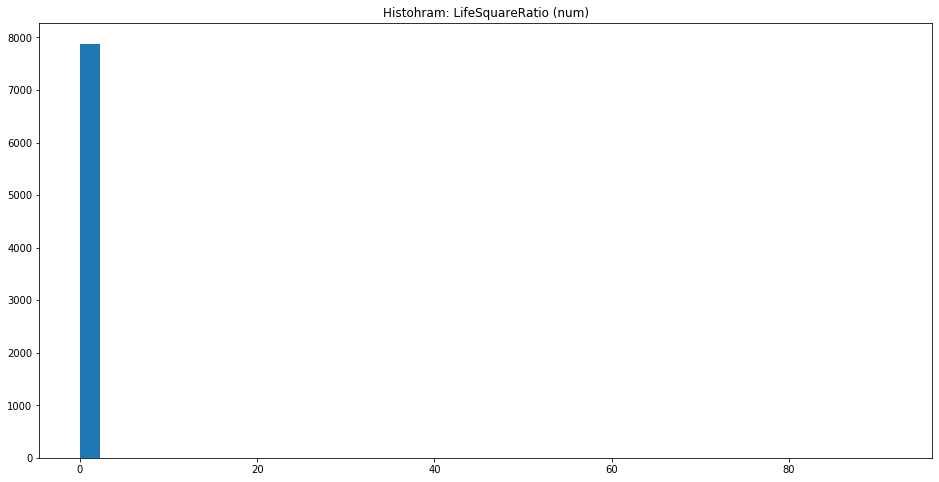

In [49]:
plt.figure(figsize = (16, 8))

plt.hist(df['LifeSquareRatio'], bins = 40, density=False)
plt.title("Histohram: LifeSquareRatio (num)")
plt.show()

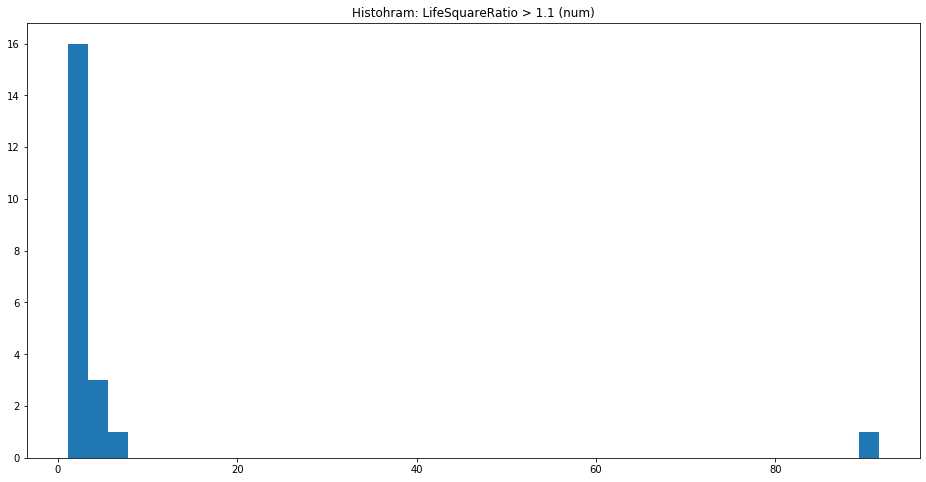

In [50]:
plt.figure(figsize = (16, 8))

plt.hist(df.loc[df['LifeSquareRatio']>1.1, 'LifeSquareRatio'], bins = 40, density=False)
plt.title("Histohram: LifeSquareRatio > 1.1 (num)")
plt.show()

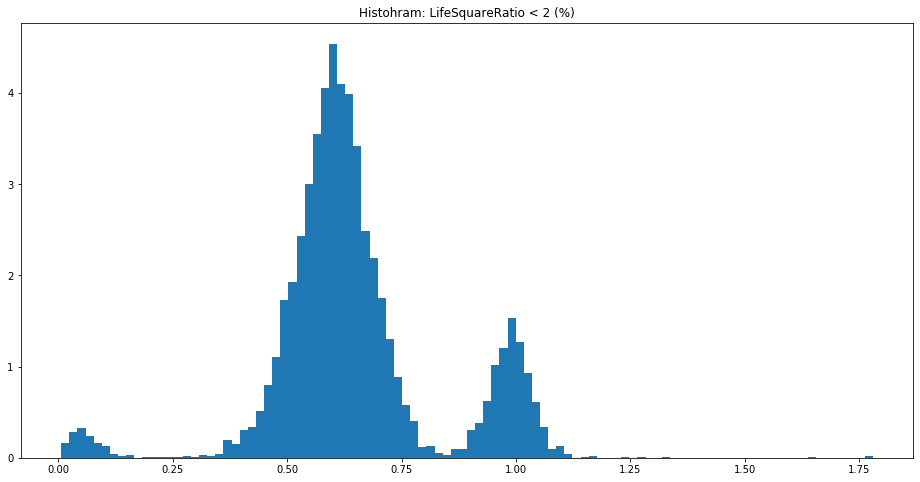

In [51]:
plt.figure(figsize = (16, 8))

plt.hist(df.loc[df['LifeSquareRatio']<2, 'LifeSquareRatio'], bins = 100, density=True)
plt.title("Histohram: LifeSquareRatio < 2 (%)")
plt.show()

In [52]:
print(f"LifeSquareRatio > 1.1: {df.loc[df['LifeSquareRatio']>1.1, 'LifeSquareRatio'].count()} observations")
df.loc[df['LifeSquareRatio']>1.1, ['LifeSquare', 'Square', 'KitchenSquare', 'LifeSquareRatio', 'Rooms', 'DistrictId', 'Price']]

LifeSquareRatio > 1.1: 21 observations


,LifeSquare,Square,KitchenSquare,LifeSquareRatio,Rooms,DistrictId,Price
212,67.628716,54.970612,1.0,1.230270,2.0,88,412511.093750
590,263.542023,48.449875,5.0,5.439478,2.0,23,141780.234375
1608,46.049427,25.963512,1.0,1.773621,1.0,6,137597.593750
2006,41.847858,37.759975,1.0,1.108260,1.0,48,206779.578125
2247,36.659412,32.795219,6.0,1.117828,3.0,109,173602.703125
2787,30.191526,27.264870,1.0,1.107342,1.0,30,80575.632812
3166,20.036232,17.046188,8.0,1.175408,1.0,150,74222.109375
4209,42.672680,38.049225,10.0,1.121512,1.0,23,71623.359375
4328,7480.592285,81.694420,1.0,91.567970,3.0,27,217357.500000
4739,15.988890,13.784864,7.0,1.159887,3.0,81,78388.804688


## <font color=green>Idea:</font> 
##### <font color=green>Divide all observations where LifeSquareRatio > 2 by ten in needed power</font>  

In [53]:
def correction(df_tt):
    select = (df_tt['LifeSquareRatio']>2) & (df_tt['Square'] > 20)
    df_tt.loc[select, 'Square_suspicious'] = 1

    df_tt.loc[select, 'LifeSquare'] = df_tt['LifeSquare'] / pow(10, np.ceil(np.log10(df_tt['LifeSquare']/df_tt['Square'])))
    df_tt.loc[select, 'LifeSquareRatio'] = df_tt['LifeSquare'] / df_tt['Square']
    return(df_tt)
#------------------------------------------------------------------
df_tt = df.copy()
df_tt = correction(df_tt)
#------------------------------------------------------------------
pretest(df_tt, "Divide all observations where LifeSquareRatio > 2 by ten in needed power")

R2: 0.749 +- 0.020
Action N7



,R2_score,STD,R2_Improving,STD_Improving,Action
7,0.748606,0.020227,-0.002226,0.000254,Divide all observations where LifeSquareRatio ...


##### <font color=green>Negative effect. Redo</font> 

In [54]:
pretest_cancel()

'The changes has been canceled'

***

## <font color=green>Idea:</font> 
##### <font color=green>Divide all observations where LifeSquareRatio > 2 and LifeSquare > 75 by ten in needed power</font> 

In [55]:
def correction(df_tt):
    select = (df_tt['LifeSquareRatio']>2) & (df_tt['LifeSquare'] > 75)
    df_tt.loc[select, 'Square_suspicious'] = 1

    df_tt.loc[select, 'LifeSquare'] = df_tt['LifeSquare'] / pow(10, np.ceil(np.log10(df_tt['LifeSquare']/df_tt['Square'])))
    df_tt.loc[select, 'LifeSquareRatio'] = df_tt['LifeSquare'] / df_tt['Square']
    return(df_tt)
#------------------------------------------------------------------
df_tt = df.copy()
df_tt = correction(df_tt)
#------------------------------------------------------------------
pretest(df_tt, "Divide all observations where LifeSquareRatio > 2 and LifeSquare > 75 by ten in needed power")

R2: 0.749 +- 0.020
Action N7



,R2_score,STD,R2_Improving,STD_Improving,Action
7,0.748606,0.020227,-0.002226,0.000254,Divide all observations where LifeSquareRatio ...


#### <font color=red>!!! Negative R2 Improvement !!! Should be considered to drop !!!</font>   

#### <font color=red>!!! Attenton !!! Correction!!!</font>  
#### <font color=red>Divide all observations where LifeSquareRatio > 2 and LifeSquare > 75 by ten in needed power</font>  

In [56]:
df = correction(df)
df_test = correction(df_test)

***

In [57]:
print(f"LifeSquareRatio > 2: {df.loc[df['LifeSquareRatio']>2, 'LifeSquareRatio'].count()} observations")
df.loc[df['LifeSquareRatio']>2, ['LifeSquare', 'Square', 'LifeSquareRatio', 'Rooms', 'DistrictId', 'Price']]

LifeSquareRatio > 2: 1 observations


,LifeSquare,Square,LifeSquareRatio,Rooms,DistrictId,Price
6392,45.257359,11.368588,3.980913,1.0,1,181434.828125


In [58]:
print(f"LifeSquareRatio > 1.1: {df.loc[df['LifeSquareRatio']>1.1, 'LifeSquareRatio'].count()} observations")
df.loc[df['LifeSquareRatio']>1.1, ['LifeSquare', 'Square', 'LifeSquareRatio', 'Rooms', 'DistrictId', 'Price']]

LifeSquareRatio > 1.1: 17 observations


,LifeSquare,Square,LifeSquareRatio,Rooms,DistrictId,Price
212,67.628716,54.970612,1.230270,2.0,88,412511.093750
1608,46.049427,25.963512,1.773621,1.0,6,137597.593750
2006,41.847858,37.759975,1.108260,1.0,48,206779.578125
2247,36.659412,32.795219,1.117828,3.0,109,173602.703125
2787,30.191526,27.264870,1.107342,1.0,30,80575.632812
3166,20.036232,17.046188,1.175408,1.0,150,74222.109375
4209,42.672680,38.049225,1.121512,1.0,23,71623.359375
4739,15.988890,13.784864,1.159887,3.0,81,78388.804688
4900,56.107719,43.903309,1.277984,3.0,27,161379.062500
6041,32.514023,28.438793,1.143298,1.0,20,199248.109375


***

## <font color=green>Idea:</font> 
##### <font color=green>Swap LifeSquare and Square for all LifeSquareRatio > 1.1</font> 

In [59]:
def correction(df_tt):
    select = (df_tt['LifeSquareRatio']>1.1)
    df_tt.loc[select, 'Square_suspicious'] = 1

    df_tt.loc[select, 'LifeSquare'] = df_tt['Square']
    df_tt.loc[select, 'Square'] = df_tt['Square']*df_tt['LifeSquareRatio']
    df_tt.loc[select, 'LifeSquareRatio'] = df_tt['LifeSquare']/df_tt['Square']
    return(df_tt)
#------------------------------------------------------------------
df_tt = df.copy()
df_tt = correction(df_tt)
#------------------------------------------------------------------
pretest(df_tt, "Swap LifeSquare and Square for all LifeSquareRatio > 1.1")

R2: 0.748 +- 0.019
Action N8



,R2_score,STD,R2_Improving,STD_Improving,Action
8,0.747783,0.019145,-0.000822,0.001081,Swap LifeSquare and Square for all LifeSquareR...


#### <font color=red>!!! Attenton !!! Correction!!!</font>  
#### <font color=red>Assume that LifeSquare and Square was mixed up somewhere. Swap LifeSquare and Square for all LifeSquareRatio > 1.1</font> 

In [60]:
df = correction(df)
df_test = correction(df_test)

***

In [61]:
df.loc[df['LifeSquareRatio']>1.1, 'LifeSquare'].count()

0

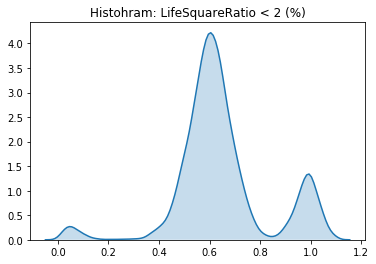

In [62]:
sns.kdeplot(df.loc[df['LifeSquareRatio']<2, 'LifeSquareRatio'], shade= True, legend= False)
plt.title("Histohram: LifeSquareRatio < 2 (%)")
plt.show()

In [63]:
print(f"LifeSquareRatio > 0.9: {df.loc[df['LifeSquareRatio']>0.9, 'LifeSquareRatio'].count()} observations")
df.loc[df['LifeSquareRatio']>0.9, ['LifeSquare', 'Square', 'LifeSquareRatio', 'Price', 'Rooms']].head(20)

LifeSquareRatio > 0.9: 1172 observations


,LifeSquare,Square,LifeSquareRatio,Price,Rooms
3,52.731510,53.352982,0.988352,175616.234375,2.0
14,52.408028,53.769096,0.974687,140647.562500,1.0
28,43.967758,42.530045,1.033805,95338.195312,1.0
42,54.723568,56.494316,0.968656,196078.906250,2.0
44,106.340401,104.211395,1.020430,435462.062500,3.0
48,46.807991,47.080101,0.994220,96029.164062,1.0
52,65.224602,61.400055,1.062289,199215.453125,2.0
69,63.304604,64.929100,0.974980,228584.000000,2.0
71,81.905548,84.687729,0.967148,243479.875000,2.0
72,52.423344,52.457588,0.999347,160292.156250,1.0


In [64]:
select = (df['LifeSquareRatio'] < 0.2) & (df['LifeSquareRatio']*10 > 0.3) & (df['LifeSquareRatio']*10 < 1)
print(f"LifeSquareRatio in select: {df.loc[select, 'LifeSquareRatio'].count()} observations")
df.loc[select, ['LifeSquare', 'Square', 'LifeSquareRatio', 'Price']].head()

LifeSquareRatio in select: 130 observations


,LifeSquare,Square,LifeSquareRatio,Price
95,4.091945,61.334969,0.066715,286564.437500
134,5.589324,65.496674,0.085338,180727.640625
158,4.896202,51.991066,0.094174,174687.562500
160,3.987101,66.419838,0.060029,193361.234375
279,4.634048,79.521217,0.058274,232726.625000


***

## <font color=green>Idea:</font> 
##### <font color=green>Multiply the rest LifeSquare feature by 10 to be consistent with Square</font> 

In [65]:
def correction(df_tt):
    select = (df_tt['LifeSquareRatio'] < 0.2) & (df_tt['LifeSquareRatio']*10 > 0.3) & (df_tt['LifeSquareRatio']*10 < 1)
    df_tt.loc[select, 'Square_suspicious'] = 1

    df_tt.loc[select, 'LifeSquare'] = df_tt['LifeSquare']*10
    df_tt.loc[select, 'LifeSquareRatio'] = df_tt['LifeSquare']/df_tt['Square']
    return(df_tt)
#------------------------------------------------------------------
df_tt = df.copy()
df_tt = correction(df_tt)
#------------------------------------------------------------------
pretest(df_tt, "Multiply the rest LifeSquare feature by 10 to be consistent with Square")

R2: 0.749 +- 0.020
Action N9



,R2_score,STD,R2_Improving,STD_Improving,Action
9,0.749188,0.019743,0.001405,-0.000597,Multiply the rest LifeSquare feature by 10 to ...


##### <font color=green>Negative effect. Redo</font> 

In [66]:
pretest_cancel()

'The changes has been canceled'

***

In [67]:
select = df['LifeSquare'].isnull()
df.loc[select, ['LifeSquare', 'Square', 'LifeSquareRatio', 'Price']].head(10)

,LifeSquare,Square,LifeSquareRatio,Price
7,NaN,80.312927,NaN,221244.156250
8,NaN,64.511436,NaN,229102.796875
21,NaN,64.711838,NaN,127200.023438
23,NaN,118.907608,NaN,571069.062500
25,NaN,82.667915,NaN,244145.828125
27,NaN,64.556206,NaN,173910.921875
36,NaN,41.118767,NaN,103510.226562
39,NaN,60.503250,NaN,229778.062500
43,NaN,58.692131,NaN,184501.015625
46,NaN,49.929489,NaN,88464.421875


***

## <font color=green>Idea:</font> 
##### <font color=green>LifeSquare_nan = 'Square' - 'KitchenSquare'</font> 

In [68]:
def correction(df_tt):
    df_tt['LifeSquare_nan'] = df_tt['LifeSquare'].isna() * 1
    select = (df_tt['LifeSquare'].isna()) & (~df_tt['Square'].isna()) & (~df_tt['KitchenSquare'].isna())
    df_tt.loc[select, 'Square_suspicious'] = 1
    df_tt.loc[select, 'LifeSquare'] = df_tt.loc[select, 'Square'] - 1 * df_tt.loc[select, 'KitchenSquare']
    return(df_tt)
#------------------------------------------------------------------
df_tt = df.copy()
df_tt = correction(df_tt)
#------------------------------------------------------------------
pretest(df_tt, "LifeSquare_nan = 'Square' - 'KitchenSquare'")

R2: 0.747 +- 0.019
Action N9



,R2_score,STD,R2_Improving,STD_Improving,Action
9,0.747414,0.019197,-0.000369,-0.000052,LifeSquare_nan = 'Square' - 'KitchenSquare'


##### <font color=green>Negative effect. Redo</font> 

In [69]:
pretest_cancel() 

'The changes has been canceled'

***

## <font color=green>Idea:</font> 
##### <font color=green>LifeSquare nan as Square * median ratio</font>

In [70]:
def correction(df_tt, train= True, median_ratio= 0):
    if train:
        median_ratio = df_tt['LifeSquareRatio'].median() # !!! Train only !!!
    
    select = (df_tt['LifeSquare'].isnull()) & (~df_tt['Square'].isnull())
    df_tt.loc[select, 'Square_suspicious'] = 1

    df_tt.loc[select, 'LifeSquare'] = df_tt['Square'] * median_ratio
    df_tt.loc[select, 'LifeSquareRatio'] = df_tt['LifeSquare']/df_tt['Square']
    
    return df_tt, median_ratio
#------------------------------------------------------------------
df_tt = df.copy()
df_tt, median_ratio = correction(df_tt)
#------------------------------------------------------------------
pretest(df_tt, "LifeSquare nan as Square * median ratio")

R2: 0.751 +- 0.019
Action N9



,R2_score,STD,R2_Improving,STD_Improving,Action
9,0.750531,0.018734,0.002748,0.000412,LifeSquare nan as Square * median ratio


#### <font color=red>!!! Attenton !!! Correction!!!</font>  
#### <font color=red>Fill all NaN LifeSquare as the fraction of Square (median LifeSqareRatio)</font> 

In [71]:
df, median_ratio = correction(df)
df_test, _ = correction(df_test, False, median_ratio)

***

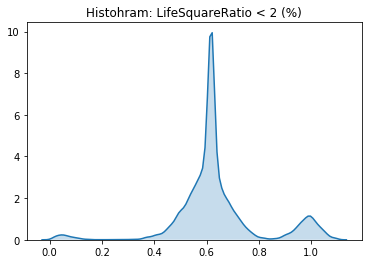

In [72]:
sns.kdeplot(df.loc[df['LifeSquareRatio']<2, 'LifeSquareRatio'], shade= True, legend= False)
plt.title("Histohram: LifeSquareRatio < 2 (%)")
plt.show()

In [73]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 22 columns):
Id                   10000 non-null int16
DistrictId           10000 non-null int16
Rooms                10000 non-null float32
Square               10000 non-null float32
LifeSquare           10000 non-null float32
KitchenSquare        10000 non-null float32
Floor                10000 non-null int8
HouseFloor           10000 non-null float32
HouseYear            10000 non-null int32
Ecology_1            10000 non-null float32
Ecology_2            10000 non-null int8
Ecology_3            10000 non-null int8
Social_1             10000 non-null int8
Social_2             10000 non-null int16
Social_3             10000 non-null int16
Healthcare_1         5202 non-null float32
Healthcare_2         10000 non-null int8
Shops_1              10000 non-null int8
Shops_2              10000 non-null int8
Price                10000 non-null float32
Square_suspicious    10000 non-null int64
Li

***

## <font color=green>Idea:</font> 
##### <font color=green>New dummy features LS_pick for LifeSquare ratio</font>

In [74]:
def correction(df_tt):
    df_tt['LS_pick'] = 1
    df_tt.loc[df_tt['LifeSquareRatio'] > 0.81 ,'LS_pick'] = 0
    df_tt.loc[df_tt['LifeSquareRatio'] < 0.3 ,'LS_pick'] = 2

    ls_pick = pd.get_dummies(df_tt['LS_pick'], prefix = 'LS_pick')
    df_tt = pd.concat([df_tt, ls_pick], axis=1)
    return(df_tt)
#------------------------------------------------------------------
df_tt = df.copy()
df_tt = correction(df_tt)
#------------------------------------------------------------------
pretest(df_tt, "New dummy features LS_pick for LifeSquare ratio")

R2: 0.751 +- 0.019
Action N10



,R2_score,STD,R2_Improving,STD_Improving,Action
10,0.750965,0.019106,0.000434,-0.000372,New dummy features LS_pick for LifeSquare ratio


#### <font color=red>!!! Attenton !!! Correction!!!</font>  
#### <font color=red>New dummy features LS_pick for LifeSquare ratio. Divide LifeSquare ratio for three states: the main pick = 1, the left pick = 0, the right pick = 2</font> 

In [75]:
df = correction(df)
df_test = correction(df_test)

***

## <font color=green>Idea:</font> 
##### <font color=green>Drop LifeSquare ratio</font>

In [76]:
def correction(df_tt):
    df_tt.drop('LifeSquareRatio', axis = 'columns', inplace= True)
    return(df_tt)
#------------------------------------------------------------------
df_tt = df.copy()
df_tt = correction(df_tt)
#------------------------------------------------------------------
pretest(df_tt, "Drop LifeSquare ratio")

R2: 0.753 +- 0.019
Action N11



,R2_score,STD,R2_Improving,STD_Improving,Action
11,0.753389,0.019035,0.002425,0.000071,Drop LifeSquare ratio


#### <font color=red>!!! Attenton !!! Correction!!!</font>  
#### <font color=red>Drop LifeSquareRatio</font> 

In [77]:
df = correction(df)
df_test = correction(df_test)

***

In [78]:
df['KitchenSquare'].describe()

count    10000.000000
mean         6.273300
std         28.561113
min          0.000000
25%          1.000000
50%          6.000000
75%          9.000000
max       2014.000000
Name: KitchenSquare, dtype: float64

In [79]:
df.loc[df['KitchenSquare'] > 1000, ['KitchenSquare', 'Square', 'HouseYear']]

,KitchenSquare,Square,HouseYear
1064,2014.0,47.100719,2014
8584,1970.0,32.276665,1977


***

## <font color=green>Idea:</font> 
##### <font color=green>To fill large KitchenSquare by median</font>

In [80]:
def correction(df_tt, train= True, median= 0):
    if train:
        median = df_tt['KitchenSquare'].median() # !!! For train only !!!

    select = df_tt['KitchenSquare'] > 200
    df_tt.loc[select, 'Square_suspicious'] = 1
    df_tt.loc[select, 'KitchenSquare'] = median
    return(df_tt, median)
#------------------------------------------------------------------
df_tt = df.copy()
df_tt, _ = correction(df_tt)
#------------------------------------------------------------------
pretest(df_tt, "Median large KitchenSquare")

R2: 0.750 +- 0.018
Action N12



,R2_score,STD,R2_Improving,STD_Improving,Action
12,0.750177,0.017847,-0.003212,0.001188,Median large KitchenSquare


##### <font color=green>Negative effect. Redo</font> 

In [81]:
pretest_cancel()

'The changes has been canceled'

***

## <font color=green>Idea:</font> 
##### <font color=green>Log large KitchenSquare</font>

In [82]:
def correction(df_tt):
    select = df_tt['KitchenSquare'] > 200
    df_tt.loc[select, 'Square_suspicious'] = 1

    df_tt['denominator'] = 1
    df_tt.loc[select, 'denominator'] = pow(10, np.ceil(np.log10(df_tt['KitchenSquare']) - np.log10(df_tt['Square'])))
    df_tt.loc[df_tt['denominator'] < 1, 'denominator'] = 1

    df_tt.loc[select, 'KitchenSquare'] = df_tt['KitchenSquare'] / df_tt['denominator']
    df_tt.drop('denominator', axis= 'columns', inplace = True)

    return(df_tt)
#------------------------------------------------------------------
df_tt = df.copy()
df_tt = correction(df_tt)
#------------------------------------------------------------------
pretest(df_tt, "Log large KitchenSquare")

C:\Users\Me\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log10
  


R2: 0.754 +- 0.019
Action N12



,R2_score,STD,R2_Improving,STD_Improving,Action
12,0.753576,0.018734,0.000187,0.000302,Log large KitchenSquare


#### <font color=red>!!! Attenton !!! Correction!!!</font>  
#### <font color=red>Log large KitchenSquare</font> 

In [83]:
df = correction(df)
df_test = correction(df_test)

C:\Users\Me\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log10
  


***

In [84]:
df.loc[[1064, 8584], ['KitchenSquare', 'Square', 'HouseYear']]

,KitchenSquare,Square,HouseYear
1064,20.139999,47.100719,2014
8584,19.700001,32.276665,1977


In [85]:
df.loc[df['KitchenSquare'] > df['Square'], ['KitchenSquare', 'Square', 'HouseYear']]

,KitchenSquare,Square,HouseYear
5149,73.0,38.071693,2006
7088,84.0,38.220257,2018


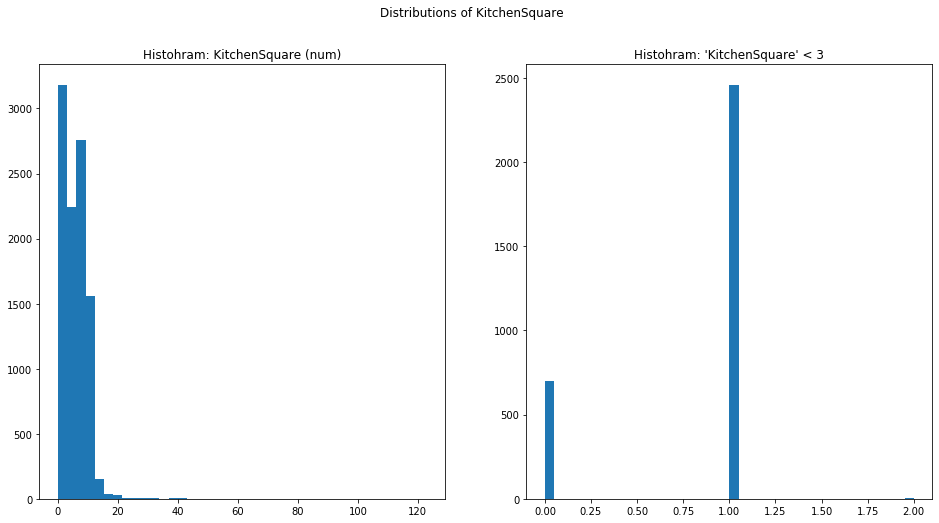

In [86]:
plt.figure(figsize = (16, 8))

plt.subplot(121)
plt.hist(df['KitchenSquare'], bins = 40, density=False)
plt.title("Histohram: KitchenSquare (num)")

select = df['KitchenSquare'] < 3
plt.subplot(122)
plt.hist(df.loc[select, 'KitchenSquare'], bins = 40, density=False)
plt.title("Histohram: 'KitchenSquare' < 3")

plt.suptitle('Distributions of KitchenSquare')
plt.show()

In [87]:
select = df['KitchenSquare'] < 3
df.loc[select, 'KitchenSquare'].unique()

array([0., 1., 2.])

In [88]:
df.loc[select, 'KitchenSquare'].value_counts()

1.0    2460
0.0     697
2.0       4
Name: KitchenSquare, dtype: int64

***

## <font color=green>Idea:</font> 
##### <font color=green>KitchenSquare <= 3 to suspicious</font>

In [89]:
def correction(df_tt):
    select = df_tt['KitchenSquare'] < 3
    df_tt.loc[select, 'Square_suspicious'] = 1
    return(df_tt)
#------------------------------------------------------------------
df_tt = df.copy()
df_tt = correction(df_tt)
#------------------------------------------------------------------
pretest(df_tt, "KitchenSquare <= 3 to suspicious")

R2: 0.752 +- 0.019
Action N13



,R2_score,STD,R2_Improving,STD_Improving,Action
13,0.751673,0.019193,-0.001903,-0.000459,KitchenSquare <= 3 to suspicious


##### <font color=green>Negative effect. Redo</font> 

In [90]:
pretest_cancel()

'The changes has been canceled'

***

## <font color=green>Idea:</font> 
##### <font color=green>KitchenSquare == 1 change to Median</font>

In [91]:
def correction(df_tt, train= True, median= 0):
    if train:
        median = df_tt['KitchenSquare'].median() # !!! For train only !!!

    select = df_tt['KitchenSquare'] == 1
    df_tt.loc[select, 'Square_suspicious'] = 1
    df_tt.loc[select, 'KitchenSquare'] = median
    return(df_tt, median)
#------------------------------------------------------------------
df_tt = df.copy()
df_tt, _ = correction(df_tt)
#------------------------------------------------------------------
pretest(df_tt, "KitchenSquare == 1 change to Median")

R2: 0.752 +- 0.017
Action N13



,R2_score,STD,R2_Improving,STD_Improving,Action
13,0.752447,0.017328,-0.001129,0.001405,KitchenSquare == 1 change to Median


##### <font color=green>Negative effect. Redo</font> 

In [92]:
pretest_cancel()

'The changes has been canceled'

***

#### <font color=red>!!! Attenton !!! Correction!!!</font>  
#### <font color=red>New feature KitchenSquareRatio</font> 

In [93]:
def correction(df_tt):
    df_tt['KitchenSquareRatio'] = df_tt['KitchenSquare']/df_tt['Square']
    return(df_tt)
#------------------------------------------------------------------
df = correction(df)
df_test = correction(df_test)
#------------------------------------------------------------------
pretest(df, 'New feature KitchenSquareRatio')

R2: 0.752 +- 0.018
Action N13



,R2_score,STD,R2_Improving,STD_Improving,Action
13,0.752334,0.018167,-0.001242,0.000567,New feature KitchenSquareRatio


#### <font color=red>!!! Negative improvement !!! Sould be consedered for deleting !!!</font>  

***

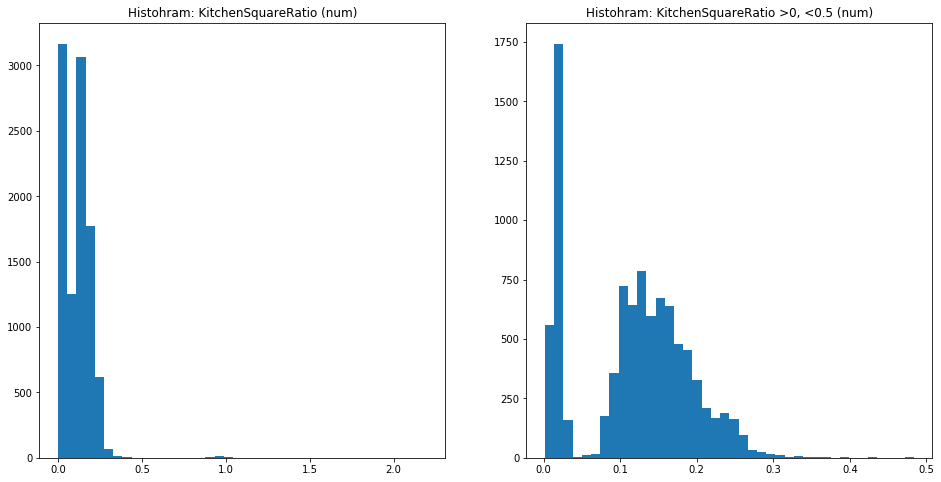

In [94]:
plt.figure(figsize = (16, 8))

plt.subplot(121)
plt.hist(df['KitchenSquareRatio'], bins = 40, density=False)
plt.title("Histohram: KitchenSquareRatio (num)")

select = (df['KitchenSquareRatio'] > 0) & (df['KitchenSquareRatio'] < 0.5)
plt.subplot(122)
plt.hist(df.loc[select,'KitchenSquareRatio'], bins = 40, density=False)
plt.title("Histohram: KitchenSquareRatio >0, <0.5 (num)")

plt.show()

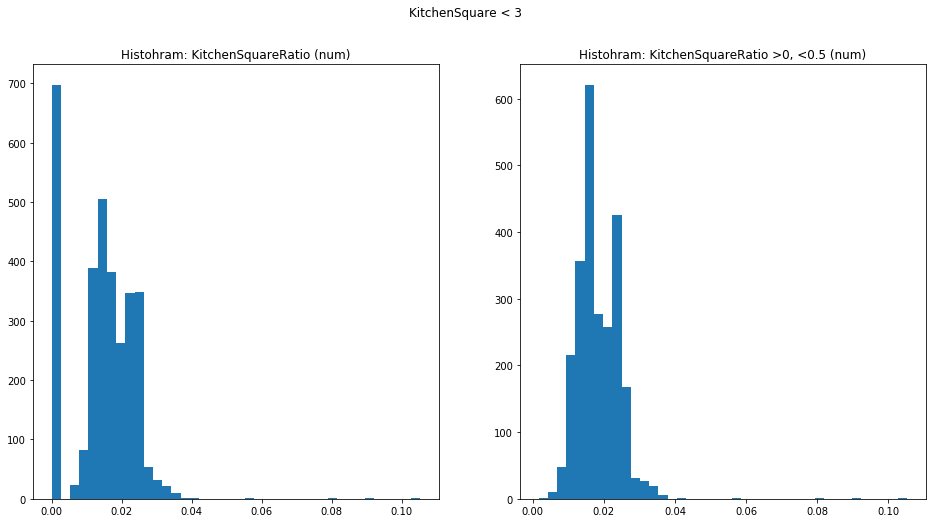

In [95]:
plt.figure(figsize = (16, 8))

select = (df['KitchenSquare'] < 3)
plt.subplot(121)
plt.hist(df.loc[select, 'KitchenSquareRatio'], bins = 40, density=False)
plt.title("Histohram: KitchenSquareRatio (num)")

select = (df['KitchenSquareRatio'] > 0) & (df['KitchenSquareRatio'] < 0.5) & (df['KitchenSquare'] < 3)
plt.subplot(122)
plt.hist(df.loc[select,'KitchenSquareRatio'], bins = 40, density=False)
plt.title("Histohram: KitchenSquareRatio >0, <0.5 (num)")

plt.suptitle('KitchenSquare < 3')
plt.show()

***

## <font color=green>Idea:</font> 
##### <font color=green>KitchenSquare == 1 change to median_ksr * df_tt['Square']</font>

In [96]:
def correction(df_tt, train= True, median= 0):
    if train:
        median_ksr = df_tt['KitchenSquareRatio'].median() # !!! For train only !!!

    select = df_tt['KitchenSquare'] == 1
    df_tt.loc[select, 'Square_suspicious'] = 1

    df_tt.loc[select, 'KitchenSquare'] = median_ksr * df_tt['Square']
    df_tt.loc[select, 'KitchenSquareRatio'] = median_ksr
    return(df_tt, median)
#------------------------------------------------------------------
df_tt = df.copy()
df_tt, _ = correction(df_tt)
#------------------------------------------------------------------
pretest(df_tt, "KitchenSquare == 1 change to median_ksr * df_tt['Square']")

R2: 0.751 +- 0.019
Action N14



,R2_score,STD,R2_Improving,STD_Improving,Action
14,0.750751,0.019097,-0.001583,-0.00093,KitchenSquare == 1 change to median_ksr * df_t...


##### <font color=green>Negative effect. Redo</font> 

In [97]:
pretest_cancel()

'The changes has been canceled'

***

## <font color=green>Idea:</font> 
##### <font color=green>Drop KitchenSquareRatio ratio</font>

In [98]:
def correction(df_tt):
    df_tt.drop('KitchenSquareRatio', axis = 'columns', inplace= True)
    return(df_tt)
#------------------------------------------------------------------
df_tt = df.copy()
df_tt = correction(df_tt)
#------------------------------------------------------------------
pretest(df_tt, "Drop KitchenSquareRatio ratio")

R2: 0.754 +- 0.019
Action N14



,R2_score,STD,R2_Improving,STD_Improving,Action
14,0.753576,0.018734,0.001242,-0.000567,Drop KitchenSquareRatio ratio


#### <font color=red>!!! Attenton !!! Correction!!!</font>  
#### <font color=red>Drop KitchenSquareRatio</font> 

In [99]:
df = correction(df)
df_test = correction(df_test)

***

# <font color=blue>Other features exploration</font>

In [100]:
df.describe()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Healthcare_1,Healthcare_2,Shops_1,Shops_2,Price,Square_suspicious,LS_pick,LS_pick_0,LS_pick_1,LS_pick_2
count,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,...,5202.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,8383.40770,50.400800,1.890500,56.373386,36.406319,5.878884,8.526700,12.609400,3.990166e+03,0.118858,...,1142.904419,1.319500,4.231300,0.082500,214139.218750,0.214100,0.895900,0.124500,0.855100,0.020400
std,4859.01902,43.587592,0.839523,20.983473,18.460825,5.177689,5.241148,6.776192,2.005003e+05,0.119026,...,1021.518982,1.493601,4.806341,0.275139,92872.304688,0.410217,0.366165,0.330168,0.352018,0.141371
min,0.00000,0.000000,0.000000,15.988890,0.370619,0.000000,1.000000,0.000000,1.910000e+03,0.000000,...,0.000000,0.000000,0.000000,0.000000,59174.777344,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4169.50000,20.000000,1.000000,41.800063,24.258069,1.000000,4.000000,9.000000,1.974000e+03,0.017647,...,350.000000,0.000000,1.000000,0.000000,153872.628906,0.000000,1.000000,0.000000,1.000000,0.000000
50%,8394.50000,36.000000,2.000000,52.537977,33.266172,6.000000,7.000000,13.000000,1.977000e+03,0.075424,...,900.000000,1.000000,3.000000,0.000000,192269.648438,0.000000,1.000000,0.000000,1.000000,0.000000
75%,12592.50000,75.000000,2.000000,65.912855,44.872669,9.000000,12.000000,17.000000,2.001000e+03,0.195781,...,1548.000000,2.000000,6.000000,0.000000,249135.460938,0.000000,1.000000,0.000000,1.000000,0.000000
max,16798.00000,209.000000,19.000000,641.065186,638.163208,123.000000,42.000000,117.000000,2.005201e+07,0.521867,...,4849.000000,6.000000,23.000000,1.000000,633233.437500,1.000000,2.000000,1.000000,1.000000,1.000000


***

## <font color=blue>HouseYear</font>

In [101]:
df['HouseYear'].describe()

count    1.000000e+04
mean     3.990166e+03
std      2.005003e+05
min      1.910000e+03
25%      1.974000e+03
50%      1.977000e+03
75%      2.001000e+03
max      2.005201e+07
Name: HouseYear, dtype: float64

In [102]:
select = df['HouseYear'] > 2020

print(f"'HouseYear' > 2020: {df.loc[select, 'HouseYear'].count()} observations")
df.loc[select, ['HouseYear', 'Price']].head()

'HouseYear' > 2020: 2 observations


,HouseYear,Price
1497,20052011,254084.531250
4189,4968,243028.609375


## <font color=green>NB:</font> 
##### <font color=green>There isn't same issue in test data, simply try to change them by hands it for now. It should be prepared some RE algorythm for production.</font>

## <font color=green>Idea:</font> 
##### <font color=green>Manually change two years</font>

In [103]:
def correction(df_tt):
    df_tt.loc[1497, 'HouseYear'] = 2011 #2005
    df_tt.loc[4189, 'HouseYear'] = 1968 #1968
    return(df_tt)
#------------------------------------------------------------------
df_tt = df.copy()
df_tt = correction(df_tt)
#------------------------------------------------------------------
pretest(df_tt, "Manually change two years")

R2: 0.753 +- 0.020
Action N15



,R2_score,STD,R2_Improving,STD_Improving,Action
15,0.752712,0.01968,-0.000865,-0.000946,Manually change two years


##### <font color=green>Negative effect. Redo</font> 

In [104]:
pretest_cancel()

'The changes has been canceled'

## <font color=green>Idea:</font> 
##### <font color=green>Manually change two years</font>

In [105]:
def correction(df_tt):
    df_tt.loc[1497, 'HouseYear'] = 2000
    df_tt.loc[4189, 'HouseYear'] = 2000
    return(df_tt)
#------------------------------------------------------------------
df_tt = df.copy()
df_tt = correction(df_tt)
#------------------------------------------------------------------
pretest(df_tt, "Manually change two years")

R2: 0.753 +- 0.018
Action N15



,R2_score,STD,R2_Improving,STD_Improving,Action
15,0.752851,0.018172,-0.000725,0.000562,Manually change two years


#### <font color=red>!!! Attenton !!! Correction!!!</font>  
#### <font color=red>Manually change two years (train only)</font> 

In [106]:
df = correction(df)

***

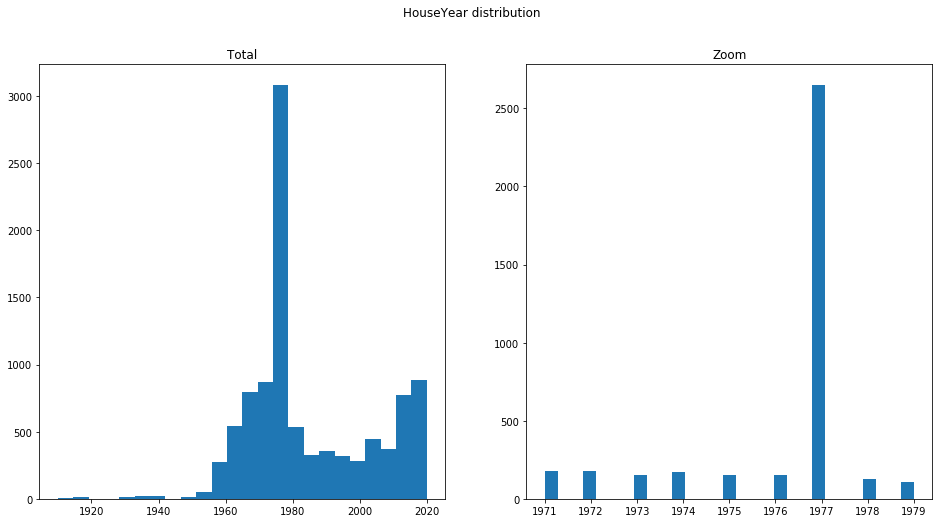

In [107]:
plt.figure(figsize = (16, 8))

plt.subplot(121)
plt.hist(df['HouseYear'], bins = 24, density=False)
plt.title('Total')

select = (df['HouseYear']>1970) & (df['HouseYear']<1980)
plt.subplot(122)
plt.hist(df.loc[select, 'HouseYear'], bins = 29, density=False)
plt.title('Zoom')

plt.suptitle('HouseYear distribution')

plt.show()

***

## <font color=green>Idea:</font> 
##### <font color=green>New feature HouseYear1977</font>

In [108]:
def correction(df_tt):
    df_tt['HouseYear1977'] = 0
    df_tt.loc[df_tt[('HouseYear')] == 1997, 'HouseYear1977'] = 1
    return(df_tt)
#------------------------------------------------------------------
df_tt = df.copy()
df_tt = correction(df_tt)
#------------------------------------------------------------------
pretest(df_tt, "New feature HouseYear1977")

R2: 0.753 +- 0.018
Action N16



,R2_score,STD,R2_Improving,STD_Improving,Action
16,0.75296,0.01803,0.000109,0.000142,New feature HouseYear1977


#### <font color=red>!!! Attenton !!! Correction!!!</font>  
#### <font color=red>New feature HouseYear1977</font> 

In [109]:
df = correction(df)
df_test = correction(df_test)

***

## <font color=green>Idea:</font> 
##### <font color=green>New feature year_cat</font>

In [110]:
def correction(df_tt):
    df_tt['year_cat'] = np.nan

    df_tt.loc[df_tt['HouseYear'] < 1945, 'year_cat'] = 1
    df_tt.loc[(df_tt['HouseYear'] >= 1945) & (df_tt['HouseYear'] <= 1945), 'year_cat'] = 2
    df_tt.loc[(df_tt['HouseYear'] > 1945) & (df_tt['HouseYear'] <= 1980), 'year_cat'] = 3
    df_tt.loc[(df_tt['HouseYear'] > 1980) & (df_tt['HouseYear'] <= 2000), 'year_cat'] = 4
    df_tt.loc[(df_tt['HouseYear'] > 2000) & (df_tt['HouseYear'] <= 2010), 'year_cat'] = 5
    df_tt.loc[(df_tt['HouseYear'] > 2010), 'year_cat'] = 6

    year_cat = pd.get_dummies(df_tt['year_cat'], prefix = 'year_cat')
    df_tt = pd.concat([df_tt, year_cat], axis=1)
    df_tt.drop('year_cat', axis= 'columns', inplace= True)
    return(df_tt)
#------------------------------------------------------------------
df_tt = df.copy()
df_tt = correction(df_tt)
#------------------------------------------------------------------
pretest(df_tt, "New feature year_cat")

R2: 0.751 +- 0.019
Action N17



,R2_score,STD,R2_Improving,STD_Improving,Action
17,0.751221,0.018776,-0.001739,-0.000747,New feature year_cat


##### <font color=green>Negative effect. Redo</font> 

In [111]:
pretest_cancel()

'The changes has been canceled'

***

## <font color=green>Idea:</font> 
##### <font color=green>New feature year_cat (another allocation)</font>

In [112]:
def correction(df_tt):
    df_tt['year_cat'] = np.nan

    df_tt.loc[df_tt['HouseYear'] < 1941, 'year_cat'] = 1
    df_tt.loc[(df_tt['HouseYear'] >= 1941) & (df_tt['HouseYear'] <= 1960), 'year_cat'] = 2
    df_tt.loc[(df_tt['HouseYear'] > 1960) & (df_tt['HouseYear'] <= 1976), 'year_cat'] = 3
    df_tt.loc[(df_tt['HouseYear'] == 1977), 'year_cat'] = 4
    df_tt.loc[(df_tt['HouseYear'] > 1977) & (df_tt['HouseYear'] <= 1990), 'year_cat'] = 5
    df_tt.loc[(df_tt['HouseYear'] > 1990) & (df_tt['HouseYear'] <= 2000), 'year_cat'] = 6
    df_tt.loc[(df_tt['HouseYear'] > 2000) & (df_tt['HouseYear'] <= 2010), 'year_cat'] = 7
    df_tt.loc[(df_tt['HouseYear'] > 2010), 'year_cat'] = 8

    year_cat = pd.get_dummies(df_tt['year_cat'], prefix = 'year_cat')
    df_tt = pd.concat([df_tt, year_cat], axis=1)
    df_tt.drop('year_cat', axis= 'columns', inplace= True)
    return(df_tt)
#------------------------------------------------------------------
df_tt = df.copy()
df_tt = correction(df_tt)
#------------------------------------------------------------------
pretest(df_tt, "New dummy feature year_cat")

R2: 0.751 +- 0.017
Action N17



,R2_score,STD,R2_Improving,STD_Improving,Action
17,0.75137,0.016872,-0.00159,0.001157,New dummy feature year_cat


##### <font color=green>Negative effect. Redo</font> 

In [113]:
pretest_cancel()

'The changes has been canceled'

***

## <font color=blue>Rooms</font>

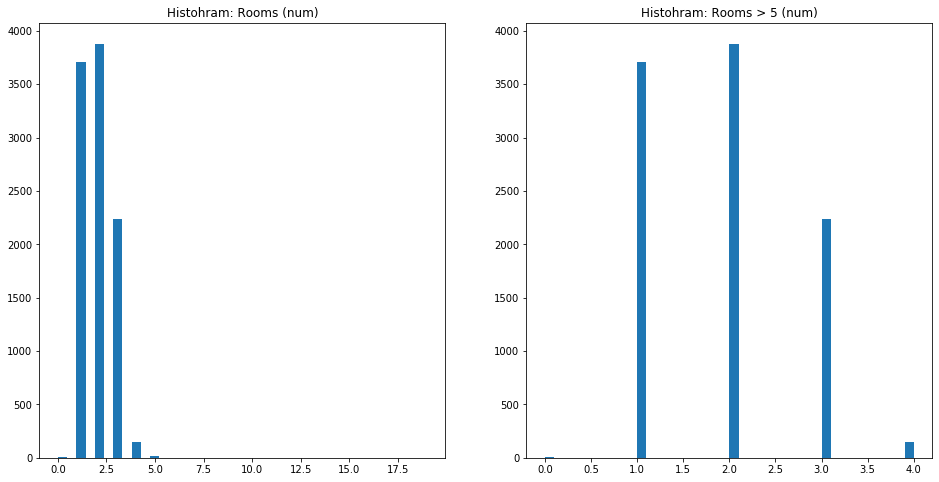

In [114]:
plt.figure(figsize = (16, 8))

plt.subplot(121)
plt.hist(df['Rooms'], bins = 40, density=False)
plt.title("Histohram: Rooms (num)")

select = (df['Rooms'] < 5)
plt.subplot(122)
plt.hist(df.loc[select,'Rooms'], bins = 40, density=False)
plt.title("Histohram: Rooms > 5 (num)")

plt.show()

In [115]:
select = df['Rooms'] == 0
df.loc[select, ['Rooms', 'Square', 'DistrictId', 'Price']]

,Rooms,Square,DistrictId,Price
1397,0.0,138.427689,27,268394.750000
1981,0.0,212.932358,27,302211.250000
2269,0.0,41.790882,27,98129.976562
3911,0.0,49.483501,28,217009.343750
4366,0.0,81.491447,6,212864.796875
4853,0.0,23.772476,27,126596.945312
6149,0.0,38.697117,88,158998.109375
8834,0.0,87.762619,27,219281.921875


***

## <font color=green>Idea:</font> 
##### <font color=green>"Rooms == 0 change to 1 and 'Rooms_outlier' feature was added"</font>

In [116]:
def correction(df_tt):
    select = df_tt['Rooms'] == 0
    df_tt['Rooms_outlier'] = 0
    df_tt.loc[select, 'Rooms_outlier'] = 1

    df_tt.loc[select, 'Rooms'] = 1
    return(df_tt)
#------------------------------------------------------------------
df_tt = df.copy()
df_tt = correction(df_tt)
#------------------------------------------------------------------
pretest(df_tt, "Rooms == 0 change to 1 and 'Rooms_outlier' feature was added")

R2: 0.753 +- 0.018
Action N17



,R2_score,STD,R2_Improving,STD_Improving,Action
17,0.75296,0.01803,0.0,-0.0,Rooms == 0 change to 1 and 'Rooms_outlier' fea...


#### <font color=red>!!! Attenton !!! Correction!!!</font>  
#### <font color=red>Rooms == 0 change to 1 and 'Rooms_outlier' feature was added</font> 

In [117]:
df = correction(df)
df_test = correction(df_test)

***

In [118]:
select = df['Rooms'] > 5
df.loc[select, ['Rooms', 'Square', 'DistrictId', 'Price']]

,Rooms,Square,DistrictId,Price
377,10.0,59.056976,57,317265.312500
1454,19.0,42.006046,1,78364.617188
2170,6.0,59.414333,99,229661.968750
8849,10.0,60.871265,9,172329.265625


***

## <font color=green>Idea:</font> 
##### <font color=green>"Rooms > 10 reduce by pow10 and 'Rooms_outlier' feature was added"</font>

In [119]:
def correction(df_tt):
    select = df_tt['Rooms'] > 10
    df_tt.loc[select, 'Rooms_outlier'] = 1

    df_tt.loc[select, 'Rooms'] =  df_tt['Rooms']/pow(10, np.ceil(np.log10(df_tt['Rooms'])))
    return(df_tt)
#------------------------------------------------------------------
df_tt = df.copy()
df_tt = correction(df_tt)
#------------------------------------------------------------------
pretest(df_tt, "Rooms > 10 reduce by pow10 and 'Rooms_outlier' feature was added")

R2: 0.752 +- 0.018
Action N18



,R2_score,STD,R2_Improving,STD_Improving,Action
18,0.751991,0.017907,-0.000968,0.000123,Rooms > 10 reduce by pow10 and 'Rooms_outlier'...


##### <font color=green>Negative effect. Redo</font> 

In [120]:
pretest_cancel()

'The changes has been canceled'

***

## <font color=green>Idea:</font> 
##### <font color=green>"Rooms' > 10 change to median_rooms"</font>

In [121]:
def correction(df_tt, train= True, median_rooms=0):
    if train:
        median_rooms = df_tt['Rooms'].median() # !!! For train only !!!

    select = df_tt['Rooms'] > 10
    df_tt.loc[select, 'Rooms_outlier'] = 1

    df_tt.loc[select, 'Rooms'] = median_rooms
    return(df_tt, median_rooms)
#------------------------------------------------------------------
df_tt = df.copy()
df_tt, _ = correction(df_tt)
#------------------------------------------------------------------
pretest(df_tt, "'Rooms' > 10 change to median_rooms")

R2: 0.753 +- 0.017
Action N18



,R2_score,STD,R2_Improving,STD_Improving,Action
18,0.753344,0.017481,0.000384,0.000549,'Rooms' > 10 change to median_rooms


##### <font color=green>Negative effect. Redo</font> 
<font color=red>??? error???</font> 

In [122]:
pretest_cancel()

'The changes has been canceled'

## <font color=green>Idea:</font> 
##### <font color=green>"Rooms > 5 change to 5 and 'Rooms_outlier' feature was added"</font>

In [123]:
def correction(df_tt):
    select = df_tt['Rooms'] > 5
    df_tt.loc[select, 'Rooms_outlier'] = 1

    df_tt.loc[select, 'Rooms'] =  5
    return(df_tt)
#------------------------------------------------------------------
df_tt = df.copy()
df_tt = correction(df_tt)
#------------------------------------------------------------------
pretest(df_tt, "Rooms > 5 change to 5 and 'Rooms_outlier' feature was added")

R2: 0.753 +- 0.018
Action N18



,R2_score,STD,R2_Improving,STD_Improving,Action
18,0.75296,0.01803,0.0,-0.0,Rooms > 5 change to 5 and 'Rooms_outlier' feat...


#### <font color=red>!!! Attenton !!! Correction!!!</font>  
#### <font color=red>Rooms > 5 change to 5</font> 

In [124]:
df = correction(df)
df_test = correction(df_test)

In [125]:
df['Rooms'].value_counts()

2.0    3880
1.0    3713
3.0    2235
4.0     150
5.0      22
Name: Rooms, dtype: int64

***

## <font color=blue>DistrictID</font> 

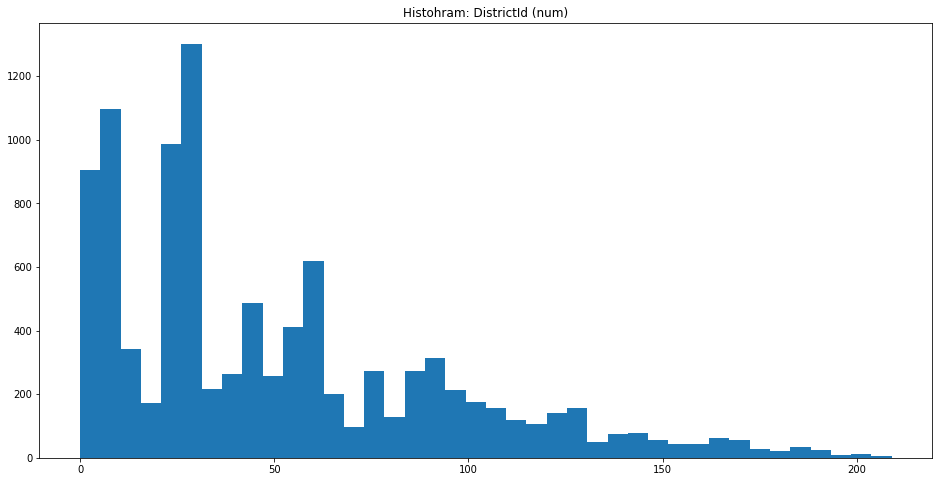

In [126]:
plt.figure(figsize = (16, 8))

plt.hist(df['DistrictId'], bins = 40, density=False)
plt.title("Histohram: DistrictId (num)")

plt.show()

In [127]:
df['DistrictId'].nunique()

205

In [128]:
df['DistrictId'].value_counts().sort_values(ascending = False).head(10)

27    851
1     652
23    565
6     511
9     294
62    247
30    228
58    179
53    174
21    165
Name: DistrictId, dtype: int64

In [129]:
df['DistrictId'].value_counts().sort_values(ascending = False).head(4).sum()/100

25.79

In [130]:
(df['DistrictId'].value_counts().sort_values(ascending = False).head(20).sum() - \
df['DistrictId'].value_counts().sort_values(ascending = False).head(4).sum()) / 100

24.9

In [131]:
(df['DistrictId'].value_counts().sort_values(ascending = False).head(55).sum() - \
df['DistrictId'].value_counts().sort_values(ascending = False).head(20).sum()) / 100

25.77

In [132]:
(df['DistrictId'].value_counts().sort_values(ascending = False).sum() - \
df['DistrictId'].value_counts().sort_values(ascending = False).head(55).sum()) / 100

23.54

***

## <font color=green>Idea:</font> 
##### <font color=green>DistrictId_cat 4 dummy categories</font>

In [133]:
def correction(df_tt, train= True, cat= []):
    if train:  # !!! For train only !!!
        cat=[]
        select = df_tt['DistrictId'].value_counts().sort_values(ascending = False).head(4)
        cat.append(tuple(select.index)) 
        select =df_tt['DistrictId'].value_counts().sort_values(ascending = False).head(20).tail(20-4)
        cat.append(tuple(select.index))
        select = df_tt['DistrictId'].value_counts().sort_values(ascending = False).head(55).tail(55-20)
        cat.append(tuple(select.index))
        select = df_tt['DistrictId'].value_counts().sort_values(ascending = False).tail(df_tt['DistrictId'].nunique()-55)
        cat.append(tuple(select.index))

    df_tt['DistrictId_cat'] = len(cat) - 1
    for i in range(len(cat)):
        for distr in cat[i]:
            select = df_tt['DistrictId'] == distr
            df_tt.loc[select, 'DistrictId_cat'] = i

    distr_cat = pd.get_dummies(df_tt['DistrictId_cat'], prefix = 'districtId_cat')
    df_tt = pd.concat([df_tt, distr_cat], axis=1)
    df_tt.drop('DistrictId_cat', axis= 'columns', inplace= True)
    return(df_tt, cat)
#------------------------------------------------------------------
df_tt = df.copy()
df_tt, _ = correction(df_tt)
#------------------------------------------------------------------
pretest(df_tt, 'DistrictId_cat 4 dummy categories')

R2: 0.752 +- 0.020
Action N19



,R2_score,STD,R2_Improving,STD_Improving,Action
19,0.751727,0.019588,-0.001233,-0.001558,DistrictId_cat 4 dummy categories


##### <font color=green>Negative effect. Redo</font> 

In [134]:
pretest_cancel()

'The changes has been canceled'

***

## <font color=green>Idea:</font> 
##### <font color=green>DistrictId_cat No dummy categories</font>

In [135]:
def correction(df_tt, train= True, cat= []):
    if train:  # !!! For train only !!!
        cat=[]
        select = df_tt['DistrictId'].value_counts().sort_values(ascending = False).head(4)
        cat.append(tuple(select.index)) 
        select =df_tt['DistrictId'].value_counts().sort_values(ascending = False).head(20).tail(20-4)
        cat.append(tuple(select.index))
        select = df_tt['DistrictId'].value_counts().sort_values(ascending = False).head(55).tail(55-20)
        cat.append(tuple(select.index))
        select = df_tt['DistrictId'].value_counts().sort_values(ascending = False).tail(df_tt['DistrictId'].nunique()-55)
        cat.append(tuple(select.index))

    df_tt['DistrictId_cat'] = len(cat) - 1
    for i in range(len(cat)):
        for distr in cat[i]:
            select = df_tt['DistrictId'] == distr
            df_tt.loc[select, 'DistrictId_cat'] = i

    df_tt['DistrictId_cat'].fillna(len(cat) - 1, inplace= True)
    return(df_tt, cat)
#------------------------------------------------------------------
df_tt = df.copy()
df_tt, _ = correction(df_tt)
#------------------------------------------------------------------
pretest(df_tt, 'DistrictId_cat No dummy categories')

R2: 0.753 +- 0.017
Action N19



,R2_score,STD,R2_Improving,STD_Improving,Action
19,0.752689,0.017492,-0.000271,0.000537,DistrictId_cat No dummy categories


#### <font color=red>!!! Attenton !!! Correction!!!</font>  
#### <font color=red>DistrictId_cat No dummy categories'</font> 

In [136]:
df, cat = correction(df)
df_test, cat = correction(df_test, False, cat)

***

## <font color=green>Idea:</font> 
##### <font color=green>DistrictId_count feature</font>

In [137]:
def correction(df_tt, train= True, district= 0):
    if train:
        district = df_tt['DistrictId'].value_counts()
        district = dict(district[district > 50])

    df_tt['DistrictId_count'] = df_tt['DistrictId'].map(district)

    df_tt['new_district'] = 0
    df_tt.loc[df_tt['DistrictId_count'].isna(), 'new_district'] = 1
    df_tt['DistrictId_count'].fillna(5, inplace=True)
    return(df_tt, district)
#------------------------------------------------------------------
df_tt = df.copy()
df_tt, _ = correction(df_tt)
#------------------------------------------------------------------
pretest(df_tt, 'DistrictId_count feature')

R2: 0.753 +- 0.020
Action N20



,R2_score,STD,R2_Improving,STD_Improving,Action
20,0.753317,0.020118,0.000628,-0.002625,DistrictId_count feature


##### <font color=green>Negative effect. Redo</font> 

In [138]:
pretest_cancel()

'The changes has been canceled'

***

In [139]:
df['DistrictId'].nunique()

205

In [140]:
df_test['DistrictId'].nunique()

201

***

## <font color=green>Idea:</font> 
##### <font color=green>DistrictId to dummy</font>

In [141]:
def correction(df_tt, train= True, distr_unique= 0):
    if train:
        distr_unique = df_tt['DistrictId'].unique()
        distr_cat = pd.get_dummies(df_tt['DistrictId'], prefix = 'district_id')
        df_tt = pd.concat([df_tt, distr_cat], axis=1)

    df_tt['new_district'] = 0
    select = ~df_tt['DistrictId'].isin(distr_unique)
    df_tt.loc[select, 'new_district'] = 1
    
    if not train:
        for d_id in distr_unique:
            df_tt[f'district_id_{d_id}'] = 0
            select = df_tt['DistrictId'] == d_id
            df_tt.loc[select, f'district_id_{d_id}'] = 1
    return(df_tt, distr_unique)
#------------------------------------------------------------------
df_tt = df.copy()
df_tt, distr_unique = correction(df_tt)
#------------------------------------------------------------------
pretest(df_tt, 'DistrictId to dummy')

R2: 0.754 +- 0.019
Action N20



,R2_score,STD,R2_Improving,STD_Improving,Action
20,0.754375,0.018911,0.001686,-0.001419,DistrictId to dummy


#### <font color=red>!!! Attenton !!! Correction!!!</font>  
#### <font color=red>DistrictId to dummy'</font> 

In [142]:
df, distr_unique = correction(df)
df_test, distr_unique = correction(df_test, False, distr_unique)

***

In [143]:
r2_results

,R2_score,STD,R2_Improving,STD_Improving,Action
0,0.750244,0.019503,0.750244,-0.019503,Initial
1,0.750244,0.019503,0.000000,-0.000000,Rename column 'Helthcare_2' to 'Healthcare_2' ...
2,0.750244,0.019503,0.000000,-0.000000,Replace all categorical variables by binary
3,0.750244,0.019503,0.000000,-0.000000,New feature 'Square_suspicious': (df['Square']...
4,0.750857,0.017082,0.000614,0.002420,Multiply small Square and LifeSquare by 10 (df...
5,0.751217,0.017950,0.000359,-0.000868,Multiply rest small Square by 10 (df['Square']...
6,0.750832,0.020481,-0.000385,-0.002531,New feature: LifeSquareRatio
7,0.748606,0.020227,-0.002226,0.000254,Divide all observations where LifeSquareRatio ...
8,0.747783,0.019145,-0.000822,0.001081,Swap LifeSquare and Square for all LifeSquareR...
9,0.750531,0.018734,0.002748,0.000412,LifeSquare nan as Square * median ratio


In [144]:
df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,district_id_196,district_id_199,district_id_200,district_id_201,district_id_202,district_id_205,district_id_207,district_id_208,district_id_209,new_district
0,14038,35,2.0,47.981560,29.442751,6.0,7,9.0,1969,0.089040,...,0,0,0,0,0,0,0,0,0,0
1,15053,41,3.0,65.683640,40.049541,8.0,7,9.0,1978,0.000070,...,0,0,0,0,0,0,0,0,0,0
2,4765,53,2.0,44.947952,29.197611,0.0,8,12.0,1968,0.049637,...,0,0,0,0,0,0,0,0,0,0
3,5809,58,2.0,53.352982,52.731510,9.0,8,17.0,1977,0.437885,...,0,0,0,0,0,0,0,0,0,0
4,10783,99,1.0,39.649193,23.776169,7.0,11,12.0,1976,0.012339,...,0,0,0,0,0,0,0,0,0,0


***

## <font color=blue>Floors</font>  

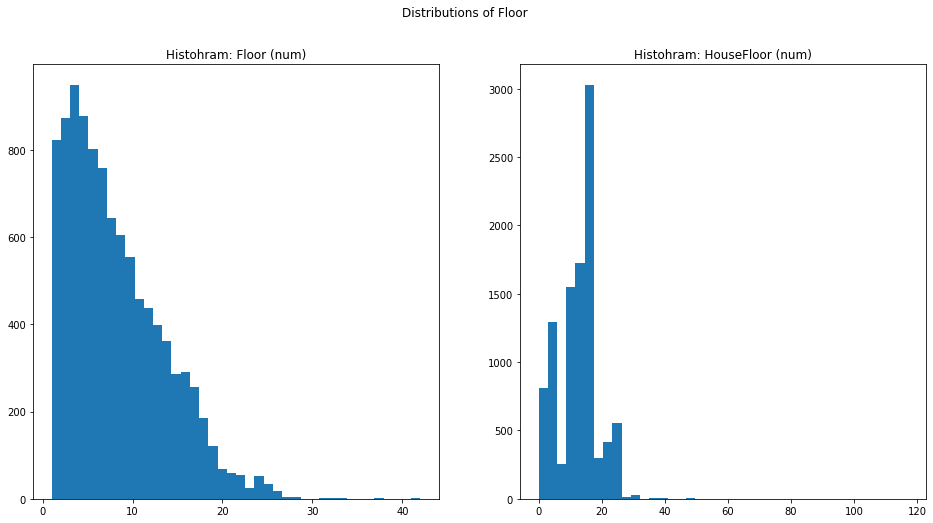

In [145]:
plt.figure(figsize = (16, 8))

plt.subplot(121)
plt.hist(df['Floor'], bins = 40, density=False)
plt.title("Histohram: Floor (num)")

plt.subplot(122)
plt.hist(df['HouseFloor'], bins = 40, density=False)
plt.title("Histohram: HouseFloor (num)")

plt.suptitle('Distributions of Floor')
plt.show()

In [146]:
print(f"HouseFloor > 40: {df.loc[df['HouseFloor'] > 40, 'HouseFloor'].count()} observations")
df.loc[df['HouseFloor'] > 40, ['HouseFloor', 'Floor', 'Price']].head(10)

HouseFloor > 40: 8 observations


,HouseFloor,Floor,Price
540,45.0,5,213171.140625
2781,48.0,42,411691.500000
3974,47.0,22,450706.562500
4323,44.0,31,117647.460938
6131,99.0,6,296127.125000
7728,48.0,22,179396.515625
8599,99.0,5,243329.906250
8854,117.0,8,207248.375000


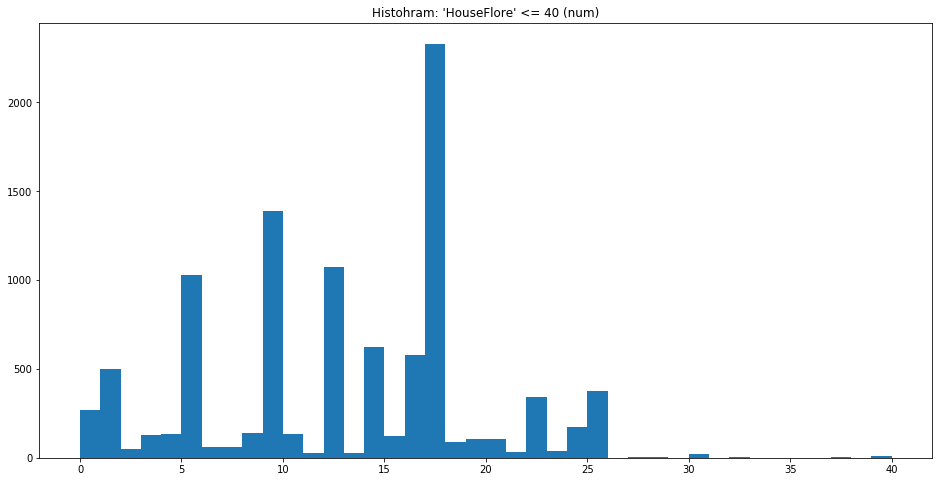

In [147]:
plt.figure(figsize = (16, 8))
plt.hist(df.loc[df['HouseFloor'] <= 40, 'HouseFloor'], bins = 40, density=False)
plt.title("Histohram: 'HouseFlore' <= 40 (num)")
plt.show()

In [148]:
print(f"HouseFloor = 0: {df.loc[df['HouseFloor'] == 0, 'HouseFloor'].count()} observations")
df.loc[df['HouseFloor'] == 0, ['Floor', 'Price']].head(10)

HouseFloor = 0: 269 observations


,Floor,Price
7,14,221244.15625
23,2,571069.06250
26,17,337299.87500
39,16,229778.06250
44,20,435462.06250
65,6,114063.09375
70,9,167023.96875
195,14,466730.81250
223,5,194092.00000
252,7,177511.31250


In [149]:
print(f"HouseFloor = Floor = 0: {df.loc[(df['HouseFloor'] == 0) & (df['Floor'] == 0), 'HouseFloor'].count()} observations")

HouseFloor = Floor = 0: 0 observations


***

## <font color=green>Idea:</font> 
##### <font color=green>New feature: FloorRatio</font>

In [150]:
def correction(df_tt):
    select = df_tt['HouseFloor'] != 0
    df_tt.loc[select, 'FloorRatio'] = df_tt.loc[select, 'Floor'] / df_tt.loc[select, 'HouseFloor']
    df_tt['FloorRatio'].fillna(0, inplace = True)
    return(df_tt)
#------------------------------------------------------------------
df_tt = df.copy()
df_tt = correction(df_tt)
#------------------------------------------------------------------
pretest(df_tt, "New feature: FloorRatio")

R2: 0.754 +- 0.020
Action N21



,R2_score,STD,R2_Improving,STD_Improving,Action
21,0.754295,0.019842,-0.00008,-0.000931,New feature: FloorRatio


#### <font color=red>!!! Attenton !!! Correction!!!</font>  
#### <font color=red>New feature: FloorRatio</font> 
#### <font color=red>!!! Negative improvement. Should be considered to drop !!!</font>

In [151]:
df = correction(df)
df_test = correction(df_test)

***

In [152]:
df['FloorRatio'].describe()

count    10000.000000
mean         1.081348
std          2.346192
min          0.000000
25%          0.400000
50%          0.666667
75%          0.954545
max         28.000000
Name: FloorRatio, dtype: float64

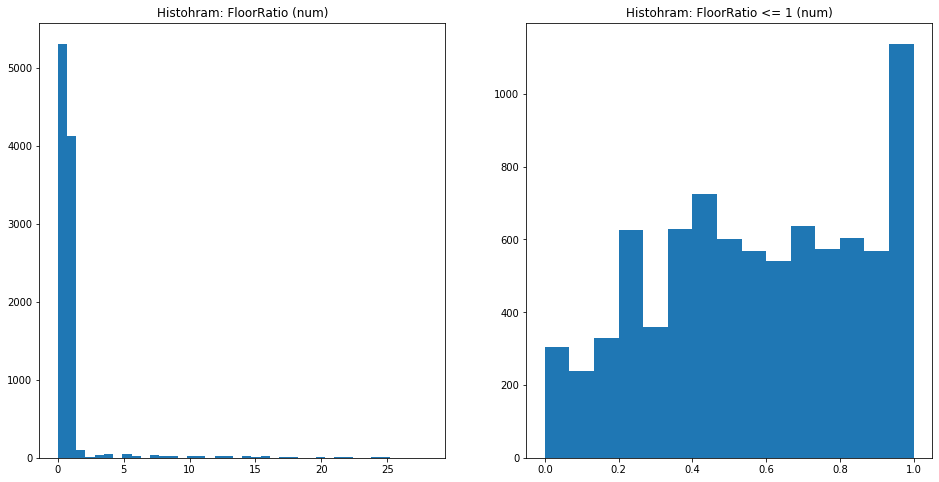

In [153]:
plt.figure(figsize = (16, 8))

plt.subplot(121)
plt.hist(df['FloorRatio'], bins = 40, density=False)
plt.title("Histohram: FloorRatio (num)")

select = df['FloorRatio'] <= 1
plt.subplot(122)
plt.hist(df.loc[select, 'FloorRatio'], bins = 15, density=False)
plt.title("Histohram: FloorRatio <= 1 (num)")

plt.show()

In [154]:
print(f"FloorRatio > 1: {df.loc[df['FloorRatio'] > 1, 'FloorRatio'].count()} observations")
df.loc[df['FloorRatio'] > 1, ['Floor', 'HouseFloor', 'FloorRatio', 'Price']].head(10)

FloorRatio > 1: 1556 observations


,Floor,HouseFloor,FloorRatio,Price
14,5,4.0,1.250000,140647.562500
16,6,5.0,1.200000,117000.382812
21,15,1.0,15.000000,127200.023438
35,6,5.0,1.200000,402871.906250
51,11,9.0,1.222222,148862.203125
67,7,5.0,1.400000,180538.906250
68,14,12.0,1.166667,179784.468750
72,18,17.0,1.058824,160292.156250
76,2,1.0,2.000000,181167.640625
86,16,1.0,16.000000,510700.437500


***

## <font color=green>Idea:</font> 
##### <font color=green>Mapping HouseFloor == 0 using avarage by FloorRatio</font>

In [155]:
def correction(df_tt, train= True, fr_median= 0, fr_medians= 0):
    if train: # Only for train !!!
        select = (df_tt['Floor'] > 0) & (df_tt['HouseFloor'] > 0) & (df_tt['FloorRatio'] <= 1)

        fr_medians = df_tt.loc[select, ['FloorRatio', 'Floor']].groupby('Floor').median().to_dict()['FloorRatio']
        fr_median = df_tt.loc[select, 'FloorRatio'].median()
    #---------------------------------------------------
    df_tt['Floor_susp'] = 0
    select = (df_tt['HouseFloor'] == 0)
    df_tt.loc[select, 'Floor_susp'] = 1

    for floor in df_tt.loc[select, 'Floor'].unique():
        if (floor not in fr_medians.keys()) or (floor == 0):
            fr_medians[floor] = fr_median

    for ind, row in df_tt.loc[select, ['Floor', 'HouseFloor']].iterrows():
        floor = max(row['Floor'], 1)
        df_tt.loc[ind, 'HouseFloor'] = np.ceil(floor/fr_medians[floor])
        df_tt.loc[ind, 'FloorRatio'] =  df_tt.loc[ind, 'Floor'] / df_tt.loc[ind, 'HouseFloor']

    df_tt['HouseFloor'] = df_tt['HouseFloor'].astype('float32')
    return(df_tt, fr_median, fr_medians)
#------------------------------------------------------------------
df_tt = df.copy()
df_tt, fr_median, fr_medians = correction(df_tt)
#------------------------------------------------------------------
pretest(df_tt, 'Mapping HouseFloor == 0 using avarage by FloorRatio')    

R2: 0.753 +- 0.018
Action N22



,R2_score,STD,R2_Improving,STD_Improving,Action
22,0.752749,0.018335,-0.001546,0.001507,Mapping HouseFloor == 0 using avarage by Floor...


##### <font color=green>Negative effect. Redo</font> 

In [156]:
pretest_cancel()

'The changes has been canceled'

***

## <font color=green>Idea:</font> 
##### <font color=green>Mapping HouseFloor == 0 using avarage by Districts</font>

In [157]:
def correction(df_tt, train= True, hf_medians_3= 0, hf_medians_2= 0, hf_medians_1={}):
    if train: # Only for train !!!
        select = (df_tt['Floor'] > 0) & (df_tt['HouseFloor'] > 0) \
                    & (df_tt['FloorRatio'] <= 1) \
                    & (df_tt['DistrictId_cat'] <= 1)
        hf_medians_1 = df_tt.loc[select, ['DistrictId', 'HouseFloor']].groupby('DistrictId').median().to_dict()['HouseFloor']

        select = (df_tt['Floor'] > 0) & (df_tt['HouseFloor'] > 0) \
                    & (df_tt['FloorRatio'] <= 1) \
                    & (df_tt['DistrictId_cat'] == 2)
        hf_medians_2 = df_tt.loc[select, 'HouseFloor'].median()

        select = (df_tt['Floor'] > 0) & (df_tt['HouseFloor'] > 0) \
                    & (df_tt['FloorRatio'] <= 1) \
                    & (df_tt['DistrictId_cat'] == 3)
        hf_medians_3 = df_tt.loc[select, 'HouseFloor'].median()
    #---------------------------------------------------
    
    
    df_tt['Floor_susp'] = 0
    select = (df_tt['HouseFloor'] == 0)
    df_tt.loc[select, 'Floor_susp'] = 1

    select = (df_tt['HouseFloor'] == 0) & (df_tt['DistrictId_cat'] == 3)
    df_tt.loc[select, 'HouseFloor'] = hf_medians_3

    select = (df_tt['HouseFloor'] == 0) & (df_tt['DistrictId_cat'] == 2)
    df_tt.loc[select, 'HouseFloor'] = hf_medians_2

    select = (df_tt['HouseFloor'] == 0) & (df_tt['DistrictId_cat'] <= 1)
    df_tt.loc[select, 'HouseFloor'] = df_tt['DistrictId'].map(hf_medians_1)
    
    return(df_tt, hf_medians_3, hf_medians_2, hf_medians_1)
#------------------------------------------------------------------
df_tt = df.copy()
df_tt, hf_medians_3, hf_medians_2, hf_medians_1 = correction(df_tt)
#------------------------------------------------------------------
pretest(df_tt, 'Mapping HouseFloor == 0 using avarage by Districts')

R2: 0.753 +- 0.020
Action N22



,R2_score,STD,R2_Improving,STD_Improving,Action
22,0.753383,0.020185,-0.000912,-0.000343,Mapping HouseFloor == 0 using avarage by Distr...


#### <font color=red>!!! Attenton !!! Correction!!!</font>  
#### <font color=red>'Mapping HouseFloor == 0 using avarage by Districts'</font> 

In [158]:
df, hf_medians_3, hf_medians_2, hf_medians_1 = correction(df)
df_test, hf_medians_3, hf_medians_2, hf_medians_1 = correction(df_test, False, hf_medians_3, hf_medians_2, hf_medians_1)

***

In [159]:
print(f"HouseFloor == 0: {df.loc[df['HouseFloor'] == 0, 'HouseFloor'].count()} observations")

HouseFloor == 0: 0 observations


In [160]:
print(f"Floor == 0: {df.loc[df['Floor'] == 0, 'Floor'].count()} observations")

Floor == 0: 0 observations


In [161]:
print(f"FloorRatio == 0: {df.loc[df['FloorRatio'] == 0, 'FloorRatio'].count()} observations")

FloorRatio == 0: 269 observations


***

## <font color=green>Idea:</font> 
##### <font color=green>Swap HouseFloor and Floor for cases Floor > HouseFloor</font>

In [162]:
def correction(df_tt):
    df_tt['Floor'] = df_tt['Floor'].astype('float32') 

    select = (df_tt['FloorRatio'] > 1) & (df_tt['HouseFloor'] != 0)
    df_tt.loc[select, 'Floor_susp'] = 1

    df_tt.loc[select, 'HouseFloor'], df_tt.loc[select, 'Floor'] = df_tt.loc[select, 'Floor'], df_tt.loc[select, 'HouseFloor']
    df_tt.loc[select, 'FloorRatio'] = df_tt.loc[select, 'Floor'] / df_tt.loc[select, 'HouseFloor']
    return(df_tt)
#------------------------------------------------------------------
df_tt = df.copy()
df_tt = correction(df_tt)
#------------------------------------------------------------------ 
pretest(df_tt, 'Swap HouseFloor and Floor for cases Floor > HouseFloor') 

R2: 0.752 +- 0.017
Action N23



,R2_score,STD,R2_Improving,STD_Improving,Action
23,0.752176,0.016515,-0.001207,0.00367,Swap HouseFloor and Floor for cases Floor > Ho...


##### <font color=green>Negative effect. Redo</font> 

In [163]:
pretest_cancel()

'The changes has been canceled'

***

## <font color=green>Idea:</font> 
##### <font color=green>HouseFloor < Floor => Floor_susp</font>

In [164]:
def correction(df_tt):
    select = (df_tt['FloorRatio'] > 1) & (df_tt['HouseFloor'] != 0)
    df_tt.loc[select, 'Floor_susp'] = 1
    return(df_tt)
#------------------------------------------------------------------
df_tt = df.copy()
df_tt = correction(df_tt)
#------------------------------------------------------------------ 
pretest(df_tt, 'HouseFloor < Floor => Floor_susp') 

R2: 0.753 +- 0.020
Action N23



,R2_score,STD,R2_Improving,STD_Improving,Action
23,0.75333,0.020296,-0.000053,-0.000111,HouseFloor < Floor => Floor_susp


#### <font color=red>!!! Attenton !!! Correction!!!</font>  
#### <font color=red>HouseFloor < Floor => Floor_susp</font> 

In [165]:
df = correction(df)
df_test = correction(df_test)

***

In [166]:
select = df['FloorRatio'] > 1
print(f"FloorRatio > 1: {df.loc[select, 'FloorRatio'].count()} observations")

FloorRatio > 1: 1556 observations


In [167]:
df[['HouseFloor', 'Floor']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 2 columns):
HouseFloor    10000 non-null float32
Floor         10000 non-null int8
dtypes: float32(1), int8(1)
memory usage: 48.9 KB


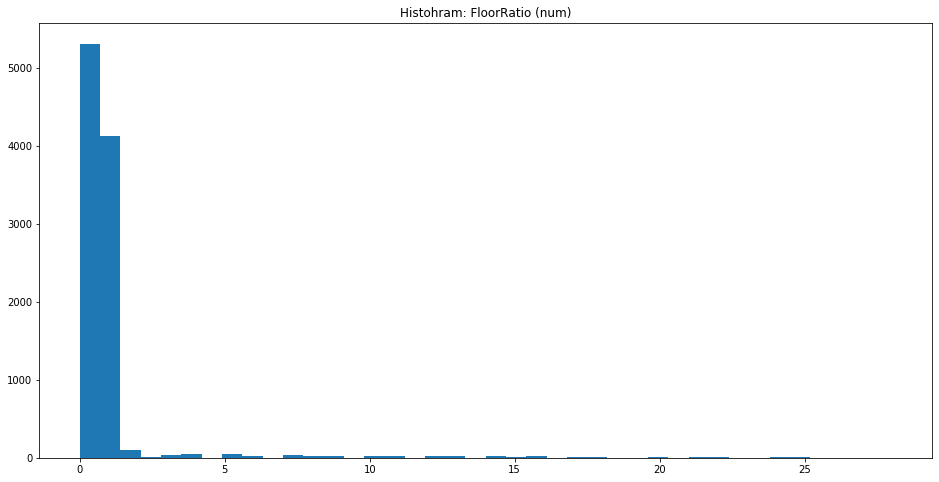

In [168]:
plt.figure(figsize = (16, 8))

plt.hist(df['FloorRatio'], bins = 40, density=False)
plt.title("Histohram: FloorRatio (num)")

plt.show()

In [169]:
def correction(df_tt):
    df_tt['First_floor'] = 0
    select = (df_tt['Floor'] == 0)
    df_tt.loc[select, 'First_floor'] = 1

    df_tt['Last_floor'] = 0
    select = (df_tt['Floor'] == df_tt['HouseFloor'])
    df_tt.loc[select, 'Last_floor'] = 1 
    return(df_tt)
#------------------------------------------------------------------
df_tt = df.copy()
df_tt = correction(df_tt)
#------------------------------------------------------------------ 
pretest(df_tt, 'First and Last floor dummies') 

R2: 0.754 +- 0.020
Action N24



,R2_score,STD,R2_Improving,STD_Improving,Action
24,0.753741,0.019792,0.000411,0.000504,First and Last floor dummies


##### !!! Attenton !!! Correction !!!
First and Last floor dummies

In [170]:
df = correction(df)
df_test = correction(df_test)

In [171]:
def correction(df_tt):
    df_tt.drop('FloorRatio', axis= 'columns', inplace= True)
    return(df_tt)
#------------------------------------------------------------------
df_tt = df.copy()
df_tt = correction(df_tt)
#------------------------------------------------------------------
pretest(df_tt, 'Drop FloorRatio') 

R2: 0.754 +- 0.019
Action N25



,R2_score,STD,R2_Improving,STD_Improving,Action
25,0.753511,0.018951,-0.00023,0.000841,Drop FloorRatio


In [172]:
pretest_cancel()

'The changes has been canceled'

In [173]:
def correction(df_tt):
    df_tt['FloorRatio_cat'] = 0
    select = (df_tt['FloorRatio'] > 0) & (df_tt['FloorRatio'] <= 0.25)
    df_tt.loc[select, 'FloorRatio_cat'] = 1
    select = (df_tt['FloorRatio'] > 0.25) & (df_tt['FloorRatio'] <= 0.5)
    df_tt.loc[select, 'FloorRatio_cat'] = 2
    select = (df_tt['FloorRatio'] > 0.5) & (df_tt['FloorRatio'] <= 0.75)
    df_tt.loc[select, 'FloorRatio_cat'] = 3
    select = (df_tt['FloorRatio'] > 0.75) & (df_tt['FloorRatio'] < 1)
    df_tt.loc[select, 'FloorRatio_cat'] = 4
    select = (df_tt['FloorRatio'] == 1)
    df_tt.loc[select, 'FloorRatio_cat'] = 5
    return(df_tt)
#------------------------------------------------------------------
df_tt = df.copy()
df_tt = correction(df_tt)
#------------------------------------------------------------------
pretest(df_tt, 'New feature FloorRatio_cat (6 categories)') 

R2: 0.755 +- 0.018
Action N25



,R2_score,STD,R2_Improving,STD_Improving,Action
25,0.754843,0.01819,0.001102,0.001602,New feature FloorRatio_cat (6 categories)


In [174]:
pretest_cancel()

'The changes has been canceled'

In [175]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Columns: 238 entries, Id to Last_floor
dtypes: float32(8), float64(1), int16(4), int32(1), int64(9), int8(7), uint8(208)
memory usage: 3.2 MB


### Ecology

In [176]:
df[['Ecology_1', 'Ecology_2', 'Ecology_3']].head()

,Ecology_1,Ecology_2,Ecology_3
0,0.089040,0,0
1,0.000070,0,0
2,0.049637,0,0
3,0.437885,0,0
4,0.012339,0,0


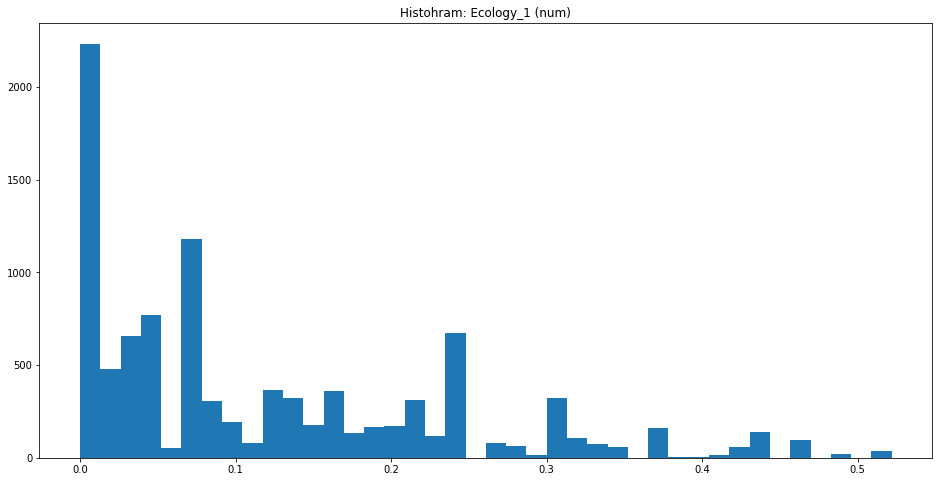

In [177]:
plt.figure(figsize = (16, 8))

plt.hist(df['Ecology_1'], bins = 40, density=False)
plt.title("Histohram: Ecology_1 (num)")

plt.show()

In [178]:
select = df['Ecology_1'] == 0
print(f"Ecology_1 == 0: {df.loc[select, 'Ecology_1'].count()} observations")

Ecology_1 == 0: 537 observations


In [179]:
df['Ecology_1'].nunique()

129

In [180]:
np.corrcoef(df['Ecology_1'], df['Price'])[0, 1]

-0.058380741716765945

In [181]:
def correction(df_tt):
    df_tt['Ecology_1_cat'] = 0
    select = (df_tt['Ecology_1'] > 0) & (df_tt['Ecology_1'] <= 0.15)
    df_tt.loc[select, 'Ecology_1_cat'] = 1
    select = (df_tt['Ecology_1'] > 0.15) & (df_tt['Ecology_1'] <= 0.3)
    df_tt.loc[select, 'Ecology_1_cat'] = 2
    select = (df_tt['Ecology_1'] > 0.3) & (df_tt['Ecology_1'] <= 0.45)
    df_tt.loc[select, 'Ecology_1_cat'] = 3
    select = (df_tt['Ecology_1'] > 0.45)
    df_tt.loc[select, 'Ecology_1_cat'] = 4
    
    """ecology_1_cat = pd.get_dummies(df_tt['Ecology_1_cat'], prefix = 'ecology_1_cat')
    df_tt = pd.concat([df_tt, ecology_1_cat], axis=1)
    
    df_tt.drop('Ecology_1_cat', axis= 'columns', inplace= True)"""
    return(df_tt)
#------------------------------------------------------------------
df_tt = df.copy()
df_tt = correction(df_tt)
#------------------------------------------------------------------
pretest(df_tt, 'New feature Ecology_1_cat (5 categories)') 

R2: 0.754 +- 0.020
Action N25



,R2_score,STD,R2_Improving,STD_Improving,Action
25,0.753741,0.019792,0.0,-0.0,New feature Ecology_1_cat (5 categories)


##### !!! Attenton !!! Correction !!!
New feature Ecology_1_cat (5 categories)

In [182]:
df = correction(df)
df_test = correction(df_test)

In [183]:
def correction(df_tt):
    df_tt['Ecology_1_cat'] = 0
    select = (df_tt['Ecology_1'] == 0)
    df_tt.loc[select, 'Ecology_1_cat'] = 1
    return(df_tt)
#------------------------------------------------------------------
df_tt = df.copy()
df_tt = correction(df_tt)
#------------------------------------------------------------------
pretest(df_tt, "Ecology_1 == 0 => Ecology_1_cat") 

R2: 0.754 +- 0.020
Action N26



,R2_score,STD,R2_Improving,STD_Improving,Action
26,0.753741,0.019792,0.0,-0.0,Ecology_1 == 0 => Ecology_1_cat


##### !!! Attenton !!! Correction !!!
Ecology_1 == 0 => Ecology_1_cat

In [184]:
df = correction(df)
df_test = correction(df_test)

In [185]:
np.corrcoef(df['Ecology_2'], df['Price'])[0, 1]

-0.02237894120835282

In [186]:
np.corrcoef(df['Ecology_3'], df['Price'])[0, 1]

0.052585282060351096

In [187]:
np.corrcoef(df['Ecology_2'], df['Ecology_3'])[0, 1]

-0.016642708998999202

In [188]:
def correction(df_tt):
    df_tt.drop('Ecology_2', axis= 'columns', inplace= True)
    return(df_tt)
#------------------------------------------------------------------
df_tt = df.copy()
df_tt = correction(df_tt)
#------------------------------------------------------------------
pretest(df_tt, 'Drop Ecology_2') 

R2: 0.754 +- 0.020
Action N27



,R2_score,STD,R2_Improving,STD_Improving,Action
27,0.753789,0.019767,0.000047,0.000025,Drop Ecology_2


##### !!! Attenton !!! Correction !!!
Drop Ecology_2

In [189]:
df = correction(df)
df_test = correction(df_test)

In [190]:
def correction(df_tt):
    df_tt.drop('Ecology_3', axis= 'columns', inplace= True)
    return(df_tt)
#------------------------------------------------------------------
df_tt = df.copy()
df_tt = correction(df_tt)
#------------------------------------------------------------------
pretest(df_tt, 'Drop Ecology_3') 

R2: 0.754 +- 0.019
Action N28



,R2_score,STD,R2_Improving,STD_Improving,Action
28,0.754116,0.019253,0.000327,0.000514,Drop Ecology_3


In [191]:
pretest_cancel()

'The changes has been canceled'

### Shops

In [192]:
df[['Shops_1', 'Shops_2']].head()

,Shops_1,Shops_2
0,11,0
1,16,0
2,3,0
3,5,0
4,4,0


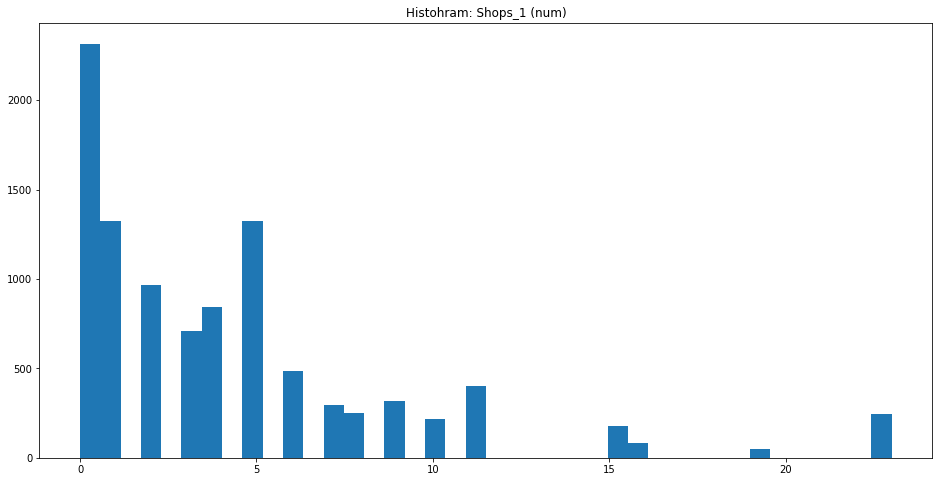

In [193]:
plt.figure(figsize = (16, 8))

plt.hist(df['Shops_1'], bins = 40, density=False)
plt.title("Histohram: Shops_1 (num)")

plt.show()

In [194]:
np.corrcoef(df['Shops_1'], df['Price'])[0, 1]

0.1808760411647132

In [195]:
np.corrcoef(df['Shops_2'], df['Price'])[0, 1]

-0.07038808930804871

In [196]:
def correction(df_tt):
    df_tt.drop('Shops_2', axis= 'columns', inplace= True)
    return(df_tt)
#------------------------------------------------------------------
df_tt = df.copy()
df_tt = correction(df_tt)
#------------------------------------------------------------------
pretest(df_tt, 'Drop Shops_2') 

R2: 0.753 +- 0.019
Action N28



,R2_score,STD,R2_Improving,STD_Improving,Action
28,0.753301,0.019268,-0.000487,0.0005,Drop Shops_2


In [197]:
pretest_cancel()

'The changes has been canceled'

In [198]:
def correction(df_tt):
    df_tt['Shops_1_cat'] = 0
    select = (df_tt['Shops_1'] == 0)
    df_tt.loc[select, 'Ecology_1_cat'] = 1
    return(df_tt)
#------------------------------------------------------------------
df_tt = df.copy()
df_tt = correction(df_tt)
#------------------------------------------------------------------
pretest(df_tt, "Shops_1 == 0 => Ecology_1_cat") 

R2: 0.754 +- 0.020
Action N28



,R2_score,STD,R2_Improving,STD_Improving,Action
28,0.75361,0.019692,-0.000179,0.000075,Shops_1 == 0 => Ecology_1_cat


In [199]:
pretest_cancel()

'The changes has been canceled'

In [200]:
np.corrcoef(df['Shops_1'], df['Shops_2'])[0, 1]

-0.13906472022917105

### Social

In [201]:
df[['Social_1', 'Social_2', 'Social_3']].head()

,Social_1,Social_2,Social_3
0,33,7976,5
1,46,10309,1
2,34,7759,0
3,23,5735,3
4,35,5776,1


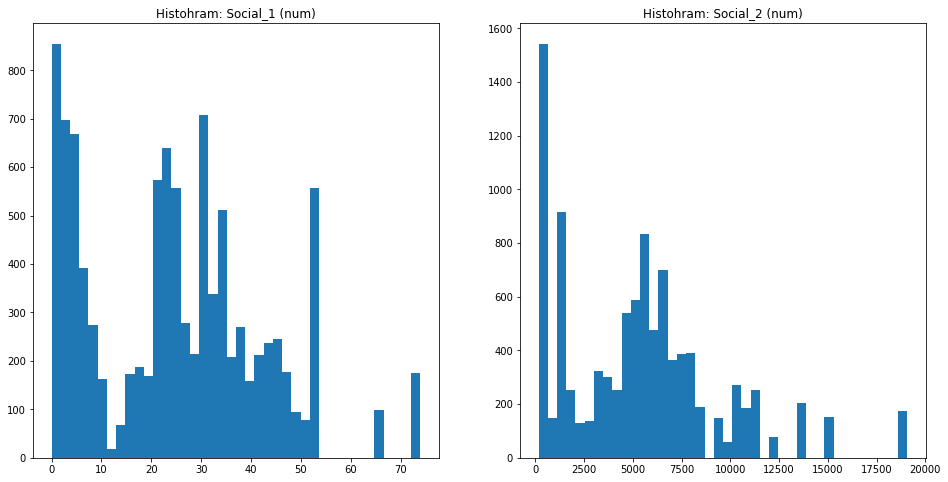

In [202]:
plt.figure(figsize = (16, 8))

plt.subplot(121)
plt.hist(df['Social_1'], bins = 40, density=False)
plt.title("Histohram: Social_1 (num)")

plt.subplot(122)
plt.hist(df['Social_2'], bins = 40, density=False)
plt.title("Histohram: Social_2 (num)")

plt.show()

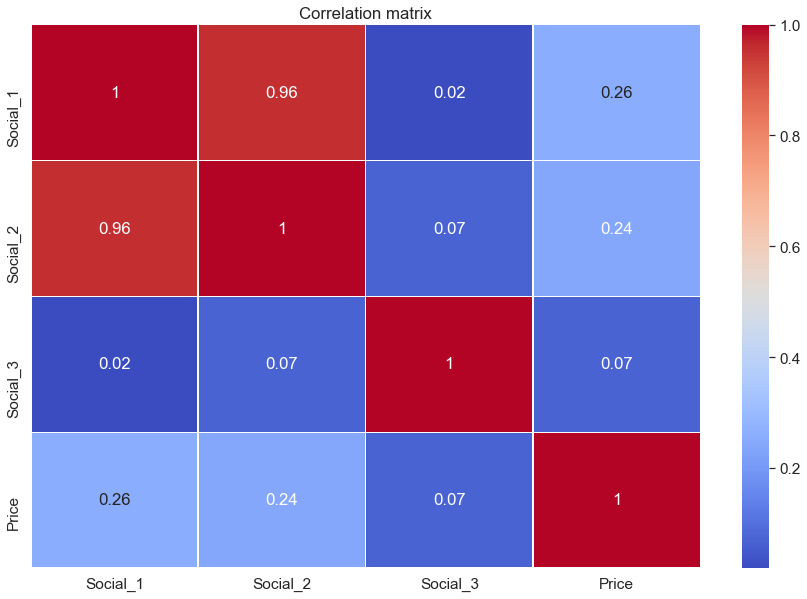

In [203]:
plt.figure(figsize = (15,10))

sns.set(font_scale=1.4)

corr_matrix = df[['Social_1', 'Social_2', 'Social_3', 'Price']].corr()
corr_matrix = np.round(corr_matrix, 2)
# corr_matrix[np.abs(corr_matrix) < 0.3] = 0  # Проверьте, что будет если убрать маленькие корреляции

sns.heatmap(corr_matrix, annot=True, linewidths=.5, cmap='coolwarm')

plt.title('Correlation matrix')
plt.show()

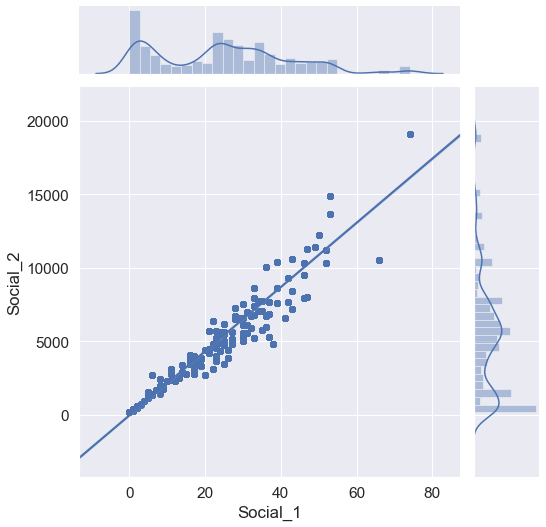

In [204]:
grid = sns.jointplot(df['Social_1'], df['Social_2'], kind='reg')
grid.fig.set_figwidth(8)
grid.fig.set_figheight(8)

plt.show()

In [205]:
from sklearn.preprocessing import RobustScaler
from sklearn.decomposition import PCA

def correction(df_tt, train= True, \
               scaler_soc_12 = RobustScaler(with_centering=True, with_scaling=True, quantile_range=(25.0, 75.0)), \
                pca_soc_12 = PCA(n_components=1, random_state=42)):
    if train: # Only for train !!!
        scaler_soc_12 = RobustScaler(with_centering=True, with_scaling=True, quantile_range=(25.0, 75.0))
        pca_soc_12 = PCA(n_components=1, random_state=42)

        soc_12 = df_tt[['Social_1', 'Social_2']]
        colnames = soc_12.columns
        soc_12_sc = pd.DataFrame(scaler_soc_12.fit_transform(soc_12), columns=colnames, index= soc_12.index)

        soc_12_pca = pca_soc_12.fit_transform(soc_12_sc)
        soc_12_pca = pd.Series(data= soc_12_pca[:, 0], index= soc_12_sc.index)

        df_tt.drop(['Social_1', 'Social_2'], axis= 'columns', inplace= True)
        df_tt['soc_12_pca'] = soc_12_pca
    else:
        soc_12 = df_tt[['Social_1', 'Social_2']]
        colnames = soc_12.columns
        soc_12_sc = pd.DataFrame(scaler_soc_12.transform(soc_12), columns=colnames, index= soc_12.index)

        soc_12_pca = pca_soc_12.transform(soc_12_sc)
        soc_12_pca = pd.Series(data= soc_12_pca[:, 0], index= soc_12_sc.index)

        df_tt.drop(['Social_1', 'Social_2'], axis= 'columns', inplace= True)
        df_tt['soc_12_pca'] = soc_12_pca
    #---------------------------------------------------
    return(df_tt, scaler_soc_12, pca_soc_12)
#------------------------------------------------------------------
df_tt = df.copy()
df_tt, scaler_soc_12, pca_soc_12 = correction(df_tt)
#------------------------------------------------------------------
pretest(df_tt, "PCA Social_1 & Social_2")

R2: 0.754 +- 0.019
Action N28



,R2_score,STD,R2_Improving,STD_Improving,Action
28,0.753655,0.018502,-0.000133,0.001266,PCA Social_1 & Social_2


In [206]:
pretest_cancel()

'The changes has been canceled'

In [207]:
def correction(df_tt):
    df_tt.drop('DistrictId', axis= 'columns', inplace= True)
    return(df_tt)
#------------------------------------------------------------------
df_tt = df.copy()
df_tt = correction(df_tt)
#------------------------------------------------------------------
pretest(df_tt, 'Drop DistrictId')

R2: 0.752 +- 0.017
Action N28



,R2_score,STD,R2_Improving,STD_Improving,Action
28,0.751788,0.016799,-0.002001,0.002968,Drop DistrictId


In [208]:
pretest_cancel()

'The changes has been canceled'

In [209]:
def correction(df_tt, train= True, hy_medians_2= 0, hy_medians_1={}):
    if train: # Only for train !!!
        select = (df_tt['DistrictId_cat'] <= 2)
        hy_medians_1 = df_tt.loc[select, ['DistrictId', 'HouseYear']].groupby('DistrictId').median().to_dict()['HouseYear']

        select = (df_tt['DistrictId_cat'] > 2)
        hy_medians_2 = df_tt.loc[select, 'HouseYear'].median()
    #---------------------------------------------------    
    
    df_tt['HouseYear_by_District'] = hy_medians_2

    select = (df_tt['DistrictId_cat'] <= 2)
    df_tt.loc[select, 'HouseYear_by_District'] = df_tt['DistrictId'].map(hy_medians_1)
    
    return(df_tt, hy_medians_2, hy_medians_1)
#------------------------------------------------------------------
df_tt = df.copy()
df_tt, hy_medians_2, hy_medians_1 = correction(df_tt)
#------------------------------------------------------------------
pretest(df_tt, 'Mapping HouseYear_by_District')

R2: 0.753 +- 0.018
Action N28



,R2_score,STD,R2_Improving,STD_Improving,Action
28,0.753137,0.017995,-0.000652,0.001773,Mapping HouseYear_by_District


##### !!! Attenton !!! Correction !!!
Mapping HouseYear_by_District

In [210]:
df, hy_medians_2, hy_medians_1 = correction(df)
df_test, hy_medians_2, hy_medians_1 = correction(df_test, False, hy_medians_2, hy_medians_1)

In [211]:
def correction(df_tt, train= True, hy_medians_1={}):
    if train: # Only for train !!!
        hy_medians_1 = df_tt[['DistrictId', 'HouseYear']].groupby('DistrictId').median().to_dict()['HouseYear']
    #---------------------------------------------------    

    df_tt['HouseYear_by_District'] = df_tt['DistrictId'].map(hy_medians_1)
    
    return(df_tt, hy_medians_1)
#------------------------------------------------------------------
df_tt = df.copy()
df_tt, hy_medians_1 = correction(df_tt)
#------------------------------------------------------------------
pretest(df_tt, 'Mapping HouseYear_by_District')

R2: 0.755 +- 0.020
Action N29



,R2_score,STD,R2_Improving,STD_Improving,Action
29,0.755065,0.019945,0.001928,-0.00195,Mapping HouseYear_by_District


In [212]:
pretest_cancel()

'The changes has been canceled'

In [213]:
def correction(df_tt, train= True, pr_d_medians_2= 0, pr_d_medians_1={}):
    if train: # Only for train !!!
        select = (df_tt['DistrictId_cat'] <= 2)
        pr_d_medians_1 = df_tt.loc[select, ['DistrictId', 'Price']].groupby('DistrictId').median().to_dict()['Price']

        select = (df_tt['DistrictId_cat'] > 2)
        pr_d_medians_2 = df_tt.loc[select, 'Price'].median()
    #---------------------------------------------------    
    
    df_tt['Price_by_District'] = pr_d_medians_2

    select = (df_tt['DistrictId_cat'] <= 2)
    df_tt.loc[select, 'Price_by_District'] = df_tt['DistrictId'].map(pr_d_medians_1)
    
    return(df_tt, pr_d_medians_2, pr_d_medians_1)
#------------------------------------------------------------------
df_tt = df.copy()
df_tt, pr_d_medians_2, pr_d_medians_1 = correction(df_tt)
#------------------------------------------------------------------
pretest(df_tt, 'Mapping Price_by_District')

R2: 0.752 +- 0.021
Action N29



,R2_score,STD,R2_Improving,STD_Improving,Action
29,0.751702,0.020991,-0.001435,-0.002997,Mapping Price_by_District


##### !!! Attenton !!! Correction !!!
Mapping Price_by_District

In [214]:
df, pr_d_medians_2, pr_d_medians_1 = correction(df)
df_test, pr_d_medians_2, pr_d_medians_1 = correction(df_test, False, pr_d_medians_2, pr_d_medians_1)

### <font color=red>Pred_61 !!!!!!!</font> 

In [215]:
def correction(df_tt, train= True, pr_d_medians_2= 0, pr_d_medians_1={}):
    if train: # Only for train !!!
        # Attention df_tt.loc[df_tt['Square'] == 0, 'Square'].count() = 0 for df and df_test
        df_tt['Price_on_Square'] = df_tt['Price'] / df_tt['Square']
        
        select = (df_tt['DistrictId_cat'] <= 2)
        pr_d_medians_1 = df_tt.loc[select, ['DistrictId', 'Price_on_Square']].groupby('DistrictId').median().to_dict()['Price_on_Square']

        select = (df_tt['DistrictId_cat'] > 2)
        pr_d_medians_2 = df_tt.loc[select, 'Price_on_Square'].median()
        
        df_tt.drop('Price_on_Square', axis= 'columns', inplace= True)
    #---------------------------------------------------    
    
    df_tt['Price_on_Square_by_District'] = pr_d_medians_2

    select = (df_tt['DistrictId_cat'] <= 2)
    df_tt.loc[select, 'Price_on_Square_by_District'] = df_tt['DistrictId'].map(pr_d_medians_1)
    
    return(df_tt, pr_d_medians_2, pr_d_medians_1)
#------------------------------------------------------------------
df_tt = df.copy()
df_tt, pr_d_medians_2, pr_d_medians_1 = correction(df_tt)
#------------------------------------------------------------------
pretest(df_tt, 'Mapping Price_on_Square_by_District')

R2: 0.752 +- 0.020
Action N30



,R2_score,STD,R2_Improving,STD_Improving,Action
30,0.751777,0.020261,0.000075,0.000731,Mapping Price_on_Square_by_District


##### !!! Attenton !!! Correction !!!
Mapping Price_on_Square_by_District

In [216]:
df, pr_d_medians_2, pr_d_medians_1 = correction(df)
df_test, pr_d_medians_2, pr_d_medians_1 = correction(df_test, False, pr_d_medians_2, pr_d_medians_1)

In [217]:
df_tt = df.copy()
df_tt['Price_on_Square'] = df_tt['Price'] / df_tt['Square']
df_tt['Price_on_Square'].describe() 

count    10000.000000
mean      3892.085938
std       1259.198486
min        208.293457
25%       2916.973694
50%       3907.999878
75%       4690.853638
max      17348.251953
Name: Price_on_Square, dtype: float64

In [218]:
df_tt['Price_on_Square'].sort_values(ascending= False).head(5)

8283    17348.251953
9370    11854.653320
5202    11393.002930
7053    11386.831055
2554    11328.413086
Name: Price_on_Square, dtype: float32

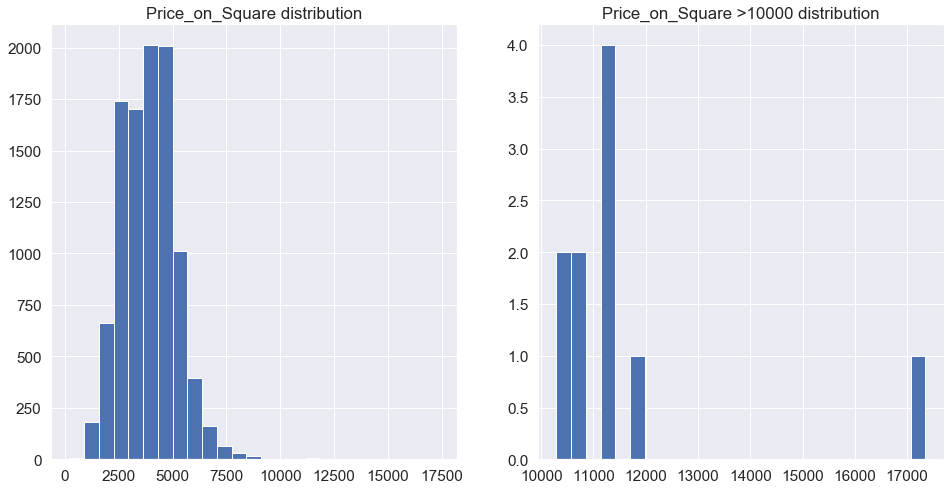

In [219]:
plt.figure(figsize = (16, 8))

plt.subplot(121)
plt.hist(df_tt['Price_on_Square'], bins = 25, density=False)
plt.title('Price_on_Square distribution')

plt.subplot(122)
select = df_tt['Price_on_Square'] > 10000
plt.hist(df_tt.loc[select, 'Price_on_Square'], bins = 25, density=False)
plt.title('Price_on_Square >10000 distribution')

plt.show()

In [220]:
select = select = df_tt['Price_on_Square'] > 10000
df_tt[select].sort_values('Price_on_Square', ascending= False)

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,new_district,FloorRatio,Floor_susp,First_floor,Last_floor,Ecology_1_cat,HouseYear_by_District,Price_by_District,Price_on_Square_by_District,Price_on_Square
8283,15744,34,1.0,26.422188,19.889427,1.0,21,4.0,1977,0.069753,...,0,5.250000,1,0,0,0,2007.0,278693.75000,4304.299316,17348.251953
9370,8396,202,2.0,42.353485,30.661180,6.0,4,6.0,1933,0.000000,...,0,0.666667,0,0,0,1,1975.0,236121.03125,4761.988770,11854.653320
5202,2018,94,1.0,33.521641,30.155170,1.0,17,16.0,2015,0.282798,...,0,1.062500,1,0,0,0,1976.0,181706.71875,4219.992676,11393.002930
7053,7931,181,1.0,34.911270,18.433155,6.0,10,12.0,1955,0.000000,...,0,0.833333,0,0,0,1,1975.0,236121.03125,4761.988770,11386.831055
2554,10919,190,2.0,47.489414,35.564480,4.0,5,5.0,1918,0.000000,...,0,1.000000,0,0,1,1,1975.0,236121.03125,4761.988770,11328.413086
896,6036,95,1.0,46.248238,28.552900,0.0,5,12.0,1977,0.000699,...,0,0.000000,1,0,0,0,1975.0,236121.03125,4761.988770,11164.009766
9613,7657,38,1.0,45.027840,46.185471,1.0,28,1.0,1977,0.060753,...,0,28.000000,1,0,0,0,1975.0,236121.03125,4761.988770,10732.993164
4764,11013,43,2.0,58.757046,34.605286,8.0,12,17.0,2004,0.000078,...,0,0.705882,0,0,0,0,1975.0,236121.03125,4761.988770,10648.572266
6945,12927,62,2.0,17.414181,10.751228,1.0,4,20.0,1977,0.072158,...,0,0.200000,0,0,0,0,1977.0,162067.28125,2613.223633,10379.499023
6117,5632,17,3.0,54.036552,43.891273,8.0,6,21.0,2017,0.093443,...,0,0.285714,0,0,0,0,1975.0,368177.50000,5029.783691,10290.327148


In [221]:
df_tt.loc[select, ['Price_on_Square', 'DistrictId', 'DistrictId_cat', 'Square']].sort_values('Price_on_Square', ascending= False)

,Price_on_Square,DistrictId,DistrictId_cat,Square
8283,17348.251953,34,1,26.422188
9370,11854.653320,202,3,42.353485
5202,11393.002930,94,2,33.521641
7053,11386.831055,181,3,34.911270
2554,11328.413086,190,3,47.489414
896,11164.009766,95,3,46.248238
9613,10732.993164,38,3,45.027840
4764,10648.572266,43,3,58.757046
6945,10379.499023,62,1,17.414181
6117,10290.327148,17,2,54.036552


### Healthcare

In [222]:
df_tt = df.copy()

select = df_tt['Healthcare_1'].isnull()

C:\Users\Me\Anaconda3\lib\site-packages\pandas\core\indexing.py:868: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_lowerdim(tup)


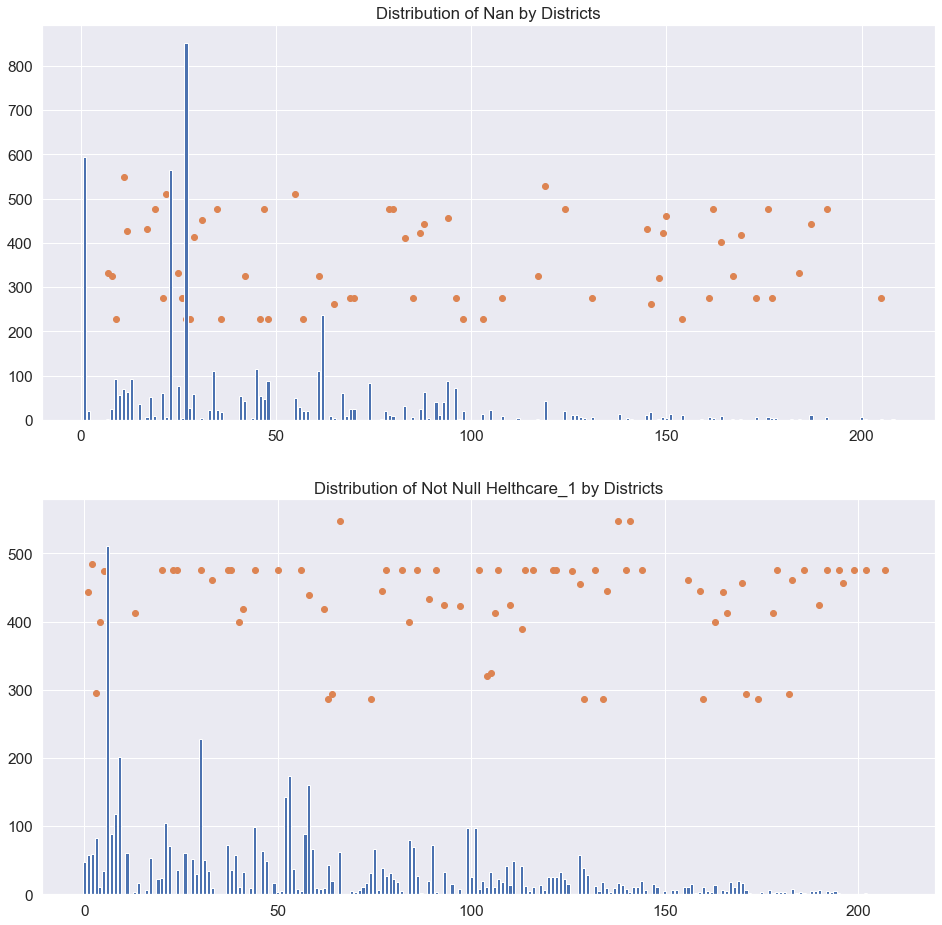

In [223]:

plt.figure(figsize = (16, 16))

plt.subplot(211)
distr_nan =  df_tt[select].groupby('DistrictId')['DistrictId'].count().to_dict()
list_nan = sorted(distr_nan.items())
district, counts = zip(*list_nan)
plt.bar(x = district, height = counts)

plt.scatter(x = district, y = df_tt[select].loc[district, 'Price_on_Square_by_District']/10)
plt.title('Distribution of Nan by Districts')

plt.subplot(212)
distr_exist =  df_tt[~select].groupby('DistrictId')['DistrictId'].count().to_dict()
list_exist = sorted(distr_exist.items())
district, counts = zip(*list_exist)
plt.bar(x = district, height = counts)

plt.scatter(x = district, y = df_tt[~select].loc[district, 'Price_on_Square_by_District']/10)
plt.title('Distribution of Not Null Helthcare_1 by Districts')

plt.show()

In [224]:
print(df.loc[select, 'DistrictId'].count())
distr =  df[select].groupby('DistrictId')['DistrictId'].count()/(df.loc[select, 'DistrictId'].count())
distr.sort_values(ascending= False).head()

4798


DistrictId
27    0.177366
1     0.124010
23    0.117549
62    0.049604
45    0.024177
Name: DistrictId, dtype: float64

In [225]:
print(df.loc[~select, 'DistrictId'].count())
distr =  df[~select].groupby('DistrictId')['DistrictId'].count()/(df.loc[~select, 'DistrictId'].count())
distr.sort_values(ascending= False).head()

5202


DistrictId
6     0.098231
30    0.043829
9     0.038831
53    0.033449
58    0.030757
Name: DistrictId, dtype: float64

In [226]:
df[['Healthcare_1', 'Healthcare_2']].describe()

,Healthcare_1,Healthcare_2
count,5202.000000,10000.000000
mean,1142.904419,1.319500
std,1021.518982,1.493601
min,0.000000,0.000000
25%,350.000000,0.000000
50%,900.000000,1.000000
75%,1548.000000,2.000000
max,4849.000000,6.000000


C:\Users\Me\Anaconda3\lib\site-packages\numpy\lib\histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\Me\Anaconda3\lib\site-packages\numpy\lib\histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


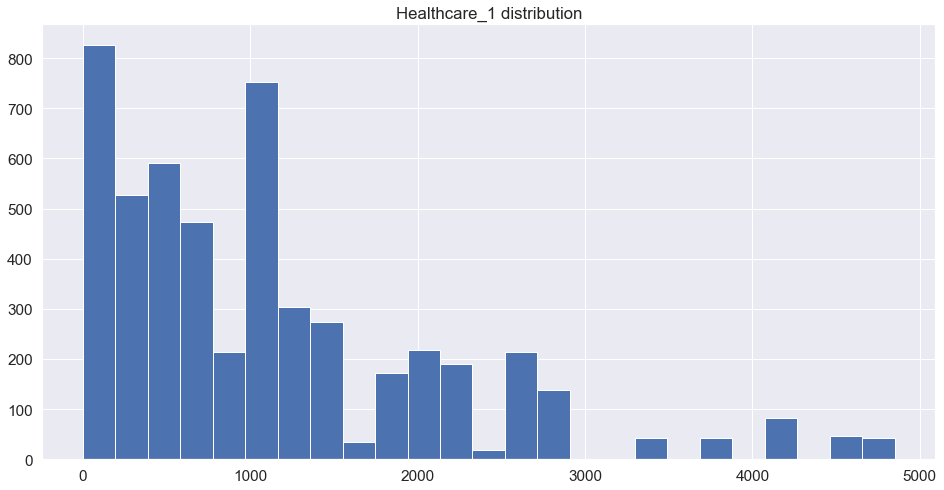

In [227]:
plt.figure(figsize = (16, 8))
plt.hist(df['Healthcare_1'], bins = 25, density=False)
plt.title('Healthcare_1 distribution')
plt.show()

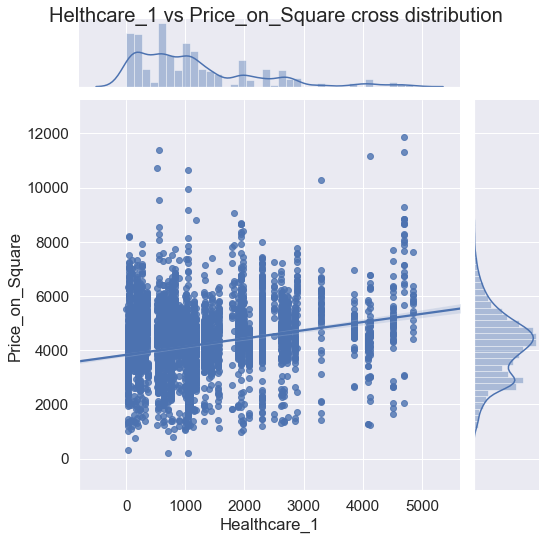

In [228]:
df_tt = df.copy()
select = df_tt['Healthcare_1'].isnull()
df_tt.drop(8283, axis= 'index', inplace= True)
df_tt['Price_on_Square'] = df_tt['Price'] / df_tt['Square']

grid = sns.jointplot(df_tt.loc[~select, 'Healthcare_1'], df_tt.loc[~select, 'Price_on_Square'], kind='reg')
grid.fig.set_figwidth(8)
grid.fig.set_figheight(8)
grid.fig.suptitle('Helthcare_1 vs Price_on_Square cross distribution')

plt.show()

In [229]:
df.loc[select, 'Price'].describe()

count      4798.000000
mean     199834.031250
std       84900.390625
min       59877.593750
25%      143095.445312
50%      183401.398438
75%      238193.542969
max      622888.812500
Name: Price, dtype: float64

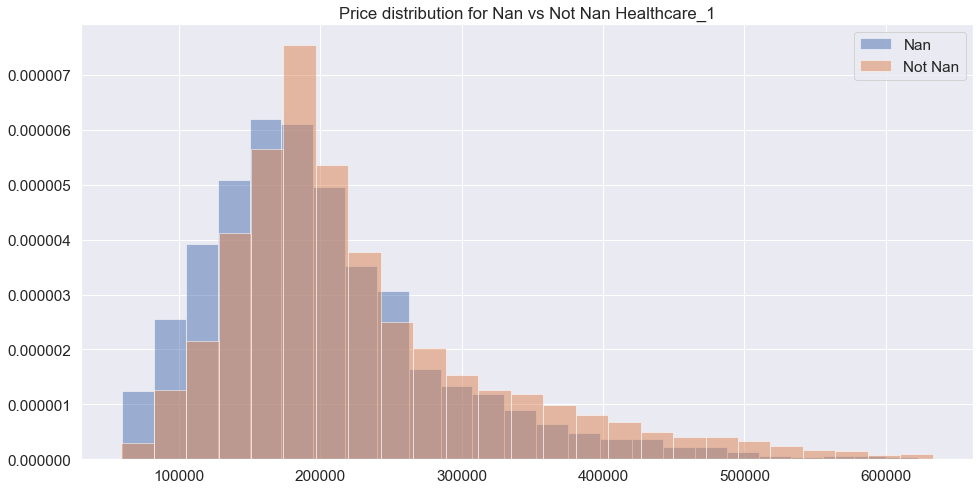

In [230]:
plt.figure(figsize = (16, 8))

plt.hist(df.loc[select, 'Price'], bins = 25, density=True, alpha= 0.5, label= 'Nan')
plt.hist(df.loc[~select, 'Price'], bins = 25, density=True, alpha= 0.5, label= 'Not Nan')
plt.legend()
plt.title('Price distribution for Nan vs Not Nan Healthcare_1')

plt.show()

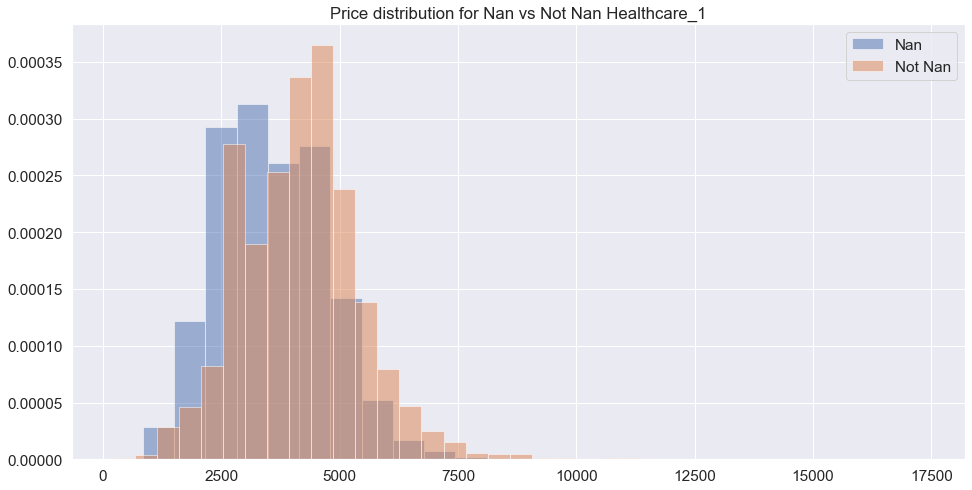

In [231]:
plt.figure(figsize = (16, 8))

df_tt = df.copy()
df_tt['Price_on_Square'] = df_tt['Price'] / df_tt['Square']

plt.hist(df_tt.loc[select, 'Price_on_Square'], bins = 25, density=True, alpha= 0.5, label= 'Nan')
plt.hist(df_tt.loc[~select, 'Price_on_Square'], bins = 25, density=True, alpha= 0.5, label= 'Not Nan')
plt.legend()
plt.title('Price distribution for Nan vs Not Nan Healthcare_1')

plt.show()

In [232]:
df['Healthcare_2'].value_counts()

0    4214
1    2183
3    1670
2    1158
5     388
4     288
6      99
Name: Healthcare_2, dtype: int64

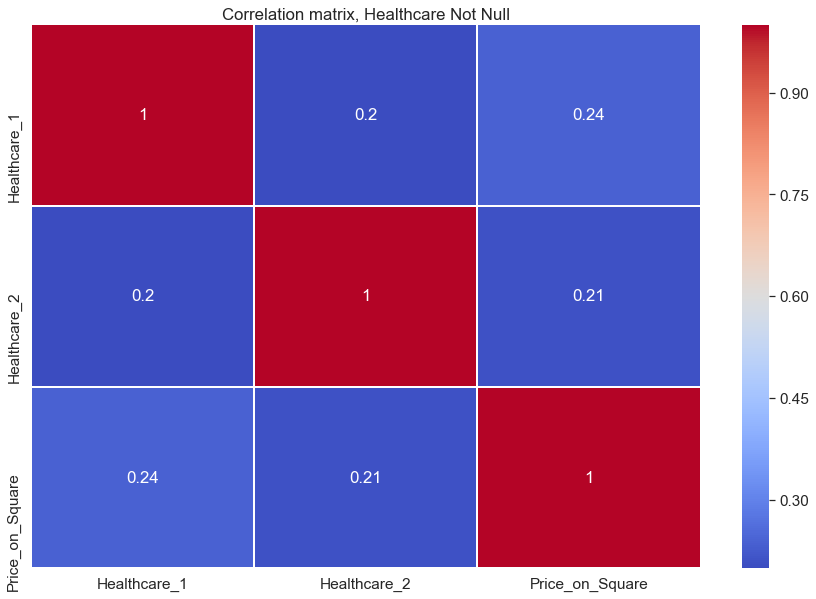

In [233]:
df_tt = df.copy()
df_tt.drop(8283, axis= 'index', inplace= True)

df_tt['Price_on_Square'] = df_tt['Price'] / df_tt['Square']
df_tt = df_tt.loc[~select, ['Healthcare_1', 'Healthcare_2', 'Price_on_Square']]


plt.figure(figsize = (15,10))

sns.set(font_scale=1.4)

corr_matrix = df_tt[['Healthcare_1', 'Healthcare_2', 'Price_on_Square']].corr()
corr_matrix = np.round(corr_matrix, 2)

sns.heatmap(corr_matrix, annot=True, linewidths=.5, cmap='coolwarm')

plt.title('Correlation matrix, Healthcare Not Null')
plt.show()

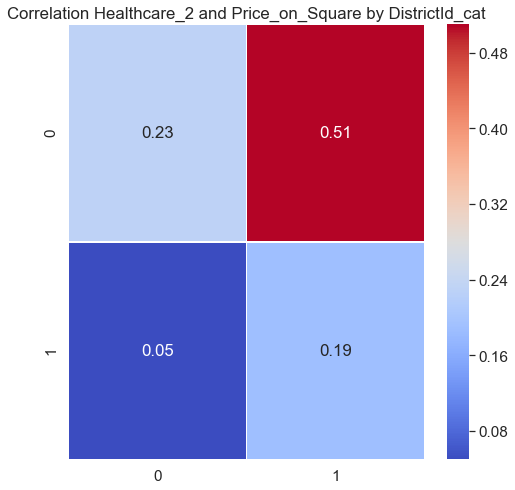

In [234]:
df_tt = df.copy()
df_tt.drop(8283, axis= 'index', inplace= True)
select = df_tt['Healthcare_1'].isnull()

df_tt['Price_on_Square'] = df_tt['Price'] / df_tt['Square']
df_tt = df_tt.loc[select, ['Healthcare_1', 'Healthcare_2', 'Price_on_Square', 'DistrictId_cat']]

plt.figure(figsize = (8, 8))

sns.set(font_scale=1.4)

corr_matrix = np.zeros((2, 2))
for i in range(4):
    slicei = df_tt['DistrictId_cat'] == i
    corr_matrix[i//2, i%2] = np.corrcoef(df_tt.loc[slicei, 'Healthcare_2'], \
                            df_tt.loc[slicei, 'Price_on_Square'])[0, 1]

corr_matrix = np.round(corr_matrix, 2)
sns.heatmap(corr_matrix, annot=True, linewidths=.5, cmap='coolwarm')
plt.title(f'Correlation Healthcare_2 and Price_on_Square by DistrictId_cat')
    
# plt.suptitle('Correlation matrix, Healthcare Null')
plt.show()

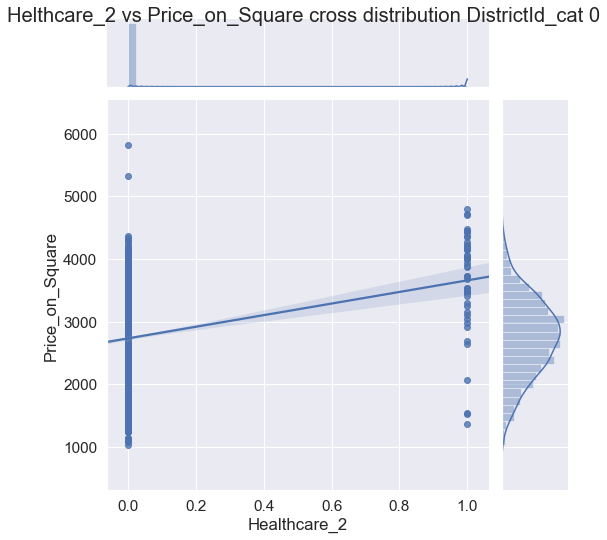

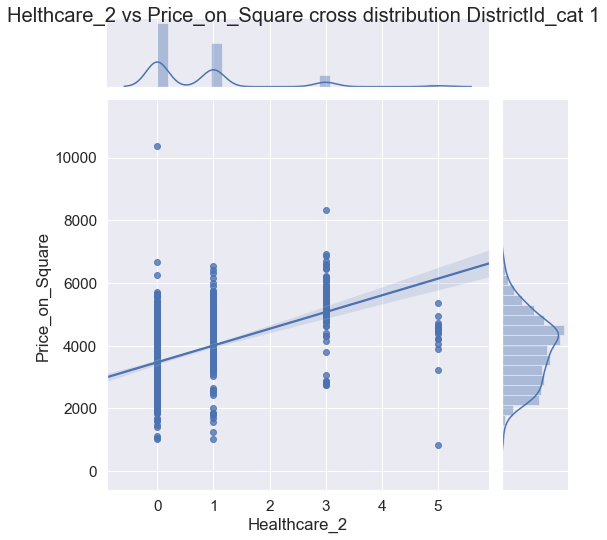

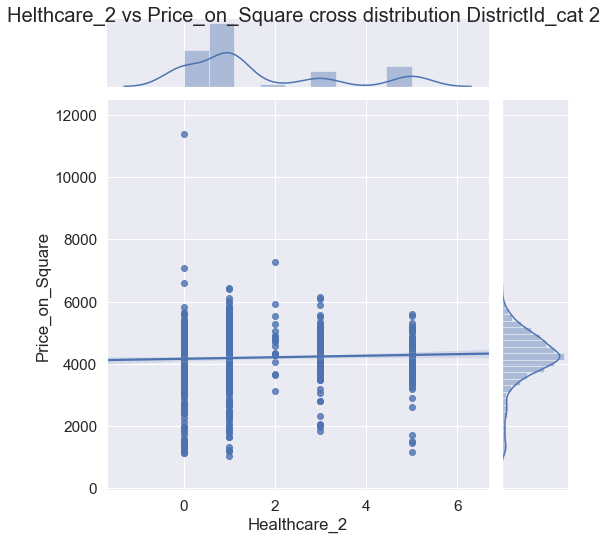

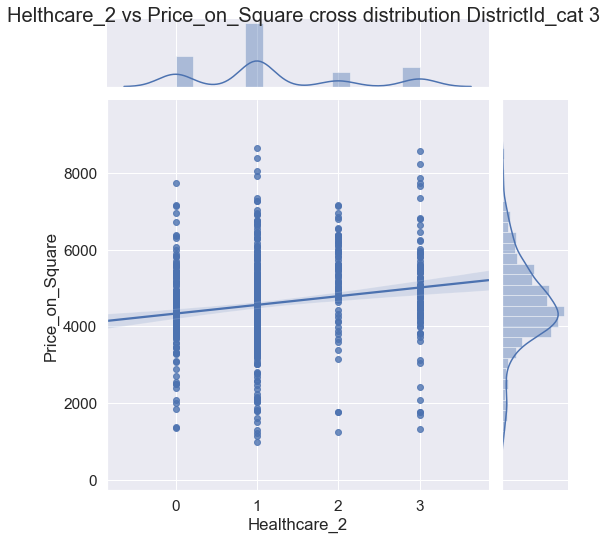

In [235]:
df_tt = df.copy()
df_tt.drop(8283, axis= 'index', inplace= True)
df_tt['Price_on_Square'] = df_tt['Price'] / df_tt['Square']
df_tt = df_tt.loc[select, ['Healthcare_2', 'Price_on_Square', 'DistrictId_cat']]

for i in range(4):
    slicei = df_tt['DistrictId_cat'] == i
    grid = sns.jointplot(df_tt.loc[slicei, 'Healthcare_2'], df_tt.loc[slicei, 'Price_on_Square'], kind='reg')
    grid.fig.set_figwidth(8)
    grid.fig.set_figheight(8)
    grid.fig.suptitle(f'Helthcare_2 vs Price_on_Square cross distribution DistrictId_cat {i}')

plt.show()

### <font color=red>Pred_7 !!!!!!!</font> 

In [236]:
def correction(df_tt):
    df_tt['HC_2_DI_cat'] = (df_tt['DistrictId_cat']*10 + df_tt['Healthcare_2']).astype('category')
    return(df_tt)
#----------------------------------------------------------------
df_tt = df.copy()
df_tt = correction(df_tt)

pretest(df_tt, 'New feature Healthcare_2 + DistrictId_cat')

R2: 0.751 +- 0.020
Action N31



,R2_score,STD,R2_Improving,STD_Improving,Action
31,0.751324,0.019677,-0.000453,0.000584,New feature Healthcare_2 + DistrictId_cat


##### !!! Attenton !!! Correction!!!
New feature Healthcare_2 + DistrictId_cat

In [237]:
df = correction(df)
df_test = correction(df_test)

### <font color=red>Pred_7 !!!!!!!</font> 

In [238]:
def correction(df_tt):
    df_tt['HC_1_isnull'] = df_tt['Healthcare_1'].isnull().astype('category')
    
    df_tt.drop('Healthcare_1', axis = 'columns', inplace = True)
    return(df_tt)
#---------------------------------------------------------------
df_tt = df.copy()
df_tt = correction(df_tt)

pretest(df_tt, "Drop 'Healthcare_1")

R2: 0.751 +- 0.020
Action N32



,R2_score,STD,R2_Improving,STD_Improving,Action
32,0.751478,0.019542,0.000154,0.000135,Drop 'Healthcare_1


##### !!! Attenton !!! Correction!!!
Drop 'Healthcare_1 + New feature HC_1_isnull

In [239]:
df = correction(df)
df_test = correction(df_test)

***

## <font color=red>Pred_8</font> 

***

### Ecology_1, Social_1, Social_2, Social_3. Addition exploration and feature generation

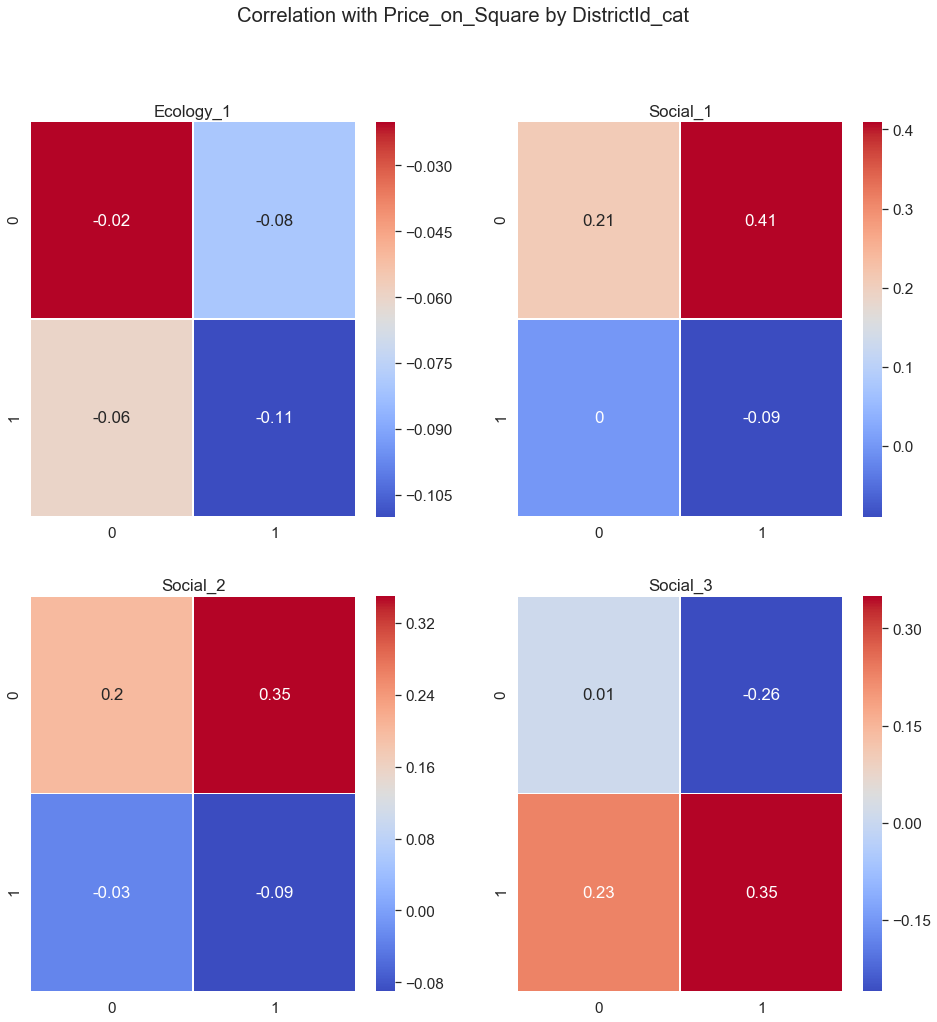

In [240]:
df_tt = df.copy()
df_tt.drop(8283, axis= 'index', inplace= True)

df_tt['Price_on_Square'] = df_tt['Price'] / df_tt['Square']
df_tt = df_tt[['Ecology_1', 'Price_on_Square', 'DistrictId_cat', 'Social_1', 'Social_2', 'Social_3']]

plt.figure(figsize = (16, 16))
sns.set(font_scale=1.4)

#--------------------------------------------------------------------
plt.subplot(221)
corr_matrix = np.zeros((2, 2))
for i in range(4):
    slicei = df_tt['DistrictId_cat'] == i
    corr_matrix[i//2, i%2] = np.corrcoef(df_tt.loc[slicei, 'Ecology_1'], \
                            df_tt.loc[slicei, 'Price_on_Square'])[0, 1]

corr_matrix = np.round(corr_matrix, 2)
sns.heatmap(corr_matrix, annot=True, linewidths=.5, cmap='coolwarm')
plt.title('Ecology_1')
#--------------------------------------------------------------------
plt.subplot(222)
corr_matrix = np.zeros((2, 2))
for i in range(4):
    slicei = df_tt['DistrictId_cat'] == i
    corr_matrix[i//2, i%2] = np.corrcoef(df_tt.loc[slicei, 'Social_1'], \
                            df_tt.loc[slicei, 'Price_on_Square'])[0, 1]

corr_matrix = np.round(corr_matrix, 2)
sns.heatmap(corr_matrix, annot=True, linewidths=.5, cmap='coolwarm')
plt.title('Social_1')
#--------------------------------------------------------------------
plt.subplot(223)
corr_matrix = np.zeros((2, 2))
for i in range(4):
    slicei = df_tt['DistrictId_cat'] == i
    corr_matrix[i//2, i%2] = np.corrcoef(df_tt.loc[slicei, 'Social_2'], \
                            df_tt.loc[slicei, 'Price_on_Square'])[0, 1]

corr_matrix = np.round(corr_matrix, 2)
sns.heatmap(corr_matrix, annot=True, linewidths=.5, cmap='coolwarm')
plt.title('Social_2')
#--------------------------------------------------------------------
plt.subplot(224)
corr_matrix = np.zeros((2, 2))
for i in range(4):
    slicei = df_tt['DistrictId_cat'] == i
    corr_matrix[i//2, i%2] = np.corrcoef(df_tt.loc[slicei, 'Social_3'], \
                            df_tt.loc[slicei, 'Price_on_Square'])[0, 1]

corr_matrix = np.round(corr_matrix, 2)
sns.heatmap(corr_matrix, annot=True, linewidths=.5, cmap='coolwarm')
plt.title('Social_3')
#--------------------------------------------------------------------

plt.suptitle('Correlation with Price_on_Square by DistrictId_cat')
    
plt.show()

In [241]:
df_tt = df.copy()
df_tt.drop(8283, axis= 'index', inplace= True)

df_tt['Price_on_Square'] = df_tt['Price'] / df_tt['Square']
df_tt = df_tt[['Ecology_1', 'Social_1', 'Social_2', 'Social_3', 'DistrictId_cat']]
df_tt.describe()

,Ecology_1,Social_1,Social_2,Social_3,DistrictId_cat
count,9999.000000,9999.000000,9999.000000,9999.000000,9999.000000
mean,0.118863,24.684168,5351.325533,8.039604,1.470647
std,0.119030,17.531204,4006.136505,23.833032,1.111738
min,0.000000,0.000000,168.000000,0.000000,0.000000
25%,0.017647,6.000000,1564.000000,0.000000,0.000000
50%,0.075424,25.000000,5285.000000,2.000000,1.000000
75%,0.195781,36.000000,7227.000000,5.000000,2.000000
max,0.521867,74.000000,19083.000000,141.000000,3.000000


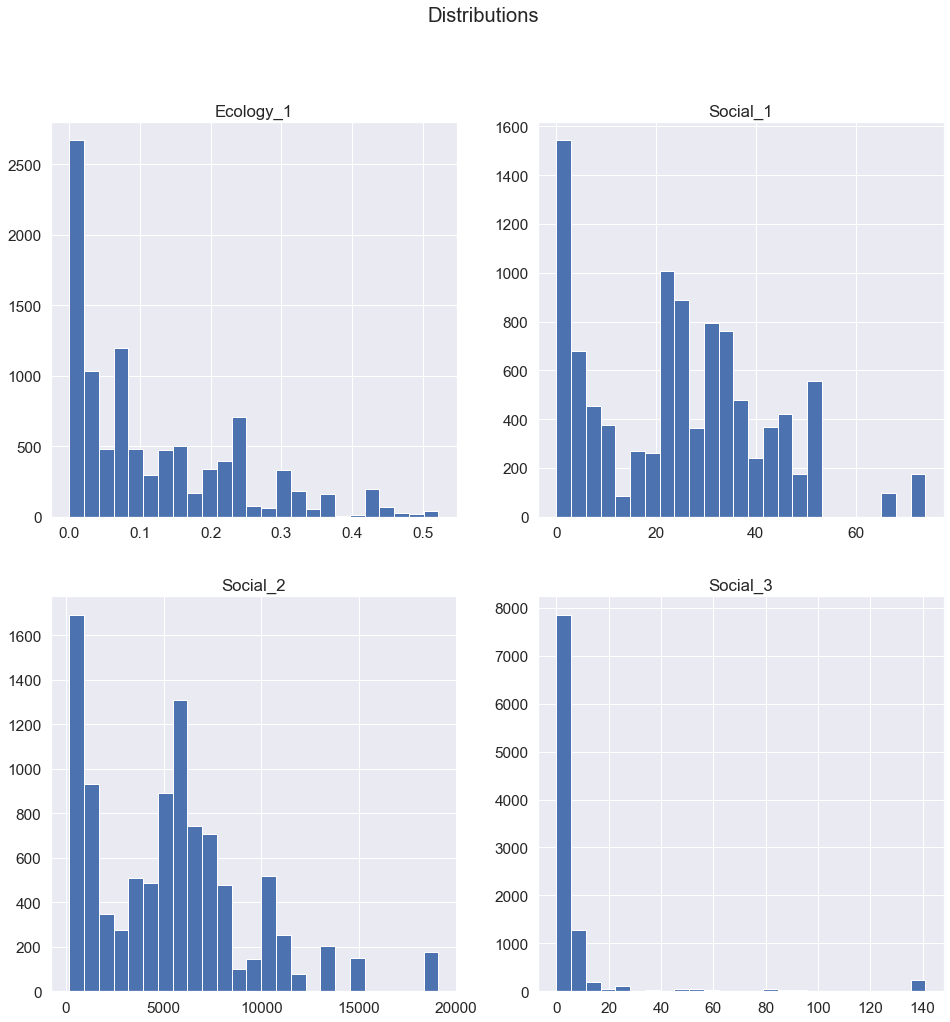

In [242]:
df_tt = df.copy()
df_tt.drop(8283, axis= 'index', inplace= True)

df_tt = df_tt[['Ecology_1','Social_1', 'Social_2', 'Social_3']]

plt.figure(figsize = (16, 16))
sns.set(font_scale=1.4)

#--------------------------------------------------------------------
plt.subplot(221)
plt.hist(df_tt['Ecology_1'], bins = 25, density=False)
plt.title('Ecology_1 distribution')
plt.title('Ecology_1')
#--------------------------------------------------------------------
plt.subplot(222)
plt.hist(df_tt['Social_1'], bins = 25, density=False)
plt.title('Social_1 distribution')
plt.title('Social_1')
#--------------------------------------------------------------------
plt.subplot(223)
plt.hist(df_tt['Social_2'], bins = 25, density=False)
plt.title('Social_2 distribution')
plt.title('Social_2')
#--------------------------------------------------------------------
plt.subplot(224)
plt.hist(df_tt['Social_3'], bins = 25, density=False)
plt.title('Social_3 distribution')
plt.title('Social_3')
#--------------------------------------------------------------------

plt.suptitle('Distributions')
    
plt.show()


In [243]:
df['Social_3'].value_counts(ascending= False)

0      2997
1      1861
3      1136
4       835
2       635
6       423
5       391
141     245
9       192
7       184
11      172
8       170
10      142
16      101
14       97
27       59
48       58
56       49
84       43
24       37
87       27
59       25
93       25
19       22
20       19
23       18
39       15
73       10
45        9
37        3
Name: Social_3, dtype: int64

In [244]:
df['Social_2'].nunique()

142

In [245]:
df['Social_3'].nunique()

30

In [246]:
def correction(df_tt):
    df_tt['Ec_1_DI_cat'] = (df_tt['DistrictId_cat']*10 + df_tt['Ecology_1']).astype('category')
    df_tt['Soc_1_DI_cat'] = (df_tt['DistrictId_cat']*100 + df_tt['Social_1']).astype('category')
    df_tt['Soc_3_DI_cat'] = (df_tt['DistrictId_cat']*1000 + df_tt['Social_3']).astype('category')
    return(df_tt)
#----------------------------------------------------------------
df_tt = df.copy()
df_tt = correction(df_tt)

pretest(df_tt, 'New feature Ec_1_DI_cat, Soc_1_DI_cat, Soc_3_DI_cat')

R2: 0.750 +- 0.019
Action N33



,R2_score,STD,R2_Improving,STD_Improving,Action
33,0.749719,0.019042,-0.001759,0.0005,"New feature Ec_1_DI_cat, Soc_1_DI_cat, Soc_3_D..."


## <font color=red>Pred_9</font> 

***

### <font color=red>Pred_9: Pred_8 changes are canceled</font> 

In [247]:
# df = correction(df)
# df_test = correction(df_test)

In [248]:
pretest_cancel()

'The changes has been canceled'

### <font color=red>Pred_9: New features generation</font> 

In [249]:
def correction(df_tt, train= True, medians_ec_1= {}, medians_ec_1_={},
                                   medians_soc_1= {}, medians_soc_1_={},
                                   medians_soc_2= {}, medians_soc_2_={},
                                   medians_soc_3= {}, medians_soc_3_={}):
    if train: # Only for train !!!
        
        medians_ec_1 = df_tt.groupby(['Ecology_1', 'DistrictId'], as_index=False).agg({'Price_on_Square_by_District':'median'}).\
                                            rename(columns={'Price_on_Square_by_District':'MedPriceByDistrictId_Ecology_1'})
        medians_ec_1_ = df_tt.groupby('Ecology_1', as_index=False).agg({'Price_on_Square_by_District':'median'}).\
                                            rename(columns={'Price_on_Square_by_District':'MedPriceByDistrictId_Ecology_1'})
        
        medians_soc_1 = df_tt.groupby(['Social_1', 'DistrictId'], as_index=False).agg({'Price_on_Square_by_District':'median'}).\
                                            rename(columns={'Price_on_Square_by_District':'MedPriceByDistrictId_Social_1'})
        medians_soc_1_ = df_tt.groupby('Social_1', as_index=False).agg({'Price_on_Square_by_District':'median'}).\
                                            rename(columns={'Price_on_Square_by_District':'MedPriceByDistrictId_Social_1'})
        
        medians_soc_2 = df_tt.groupby(['Social_2', 'DistrictId'], as_index=False).agg({'Price_on_Square_by_District':'median'}).\
                                            rename(columns={'Price_on_Square_by_District':'MedPriceByDistrictId_Social_2'})
        medians_soc_2_ = df_tt.groupby('Social_2', as_index=False).agg({'Price_on_Square_by_District':'median'}).\
                                            rename(columns={'Price_on_Square_by_District':'MedPriceByDistrictId_Social_2'})
        
        medians_soc_3 = df_tt.groupby(['Social_3', 'DistrictId'], as_index=False).agg({'Price_on_Square_by_District':'median'}).\
                                            rename(columns={'Price_on_Square_by_District':'MedPriceByDistrictId_Social_3'})
        medians_soc_3_ = df_tt.groupby('Social_3', as_index=False).agg({'Price_on_Square_by_District':'median'}).\
                                            rename(columns={'Price_on_Square_by_District':'MedPriceByDistrictId_Social_3'})
    #---------------------------------------------------    
    df_tt = df_tt.merge(medians_ec_1, on=['Ecology_1', 'DistrictId'], how='left')
    
    select = df_tt['MedPriceByDistrictId_Ecology_1'].isnull()       
    df_tt.loc[select, 'MedPriceByDistrictId_Ecology_1'] = df_tt.loc[select].merge(medians_ec_1_, on='Ecology_1', how='left')
    
    select = df_tt['MedPriceByDistrictId_Ecology_1'].isnull()
    df_tt.loc[select, 'MedPriceByDistrictId_Ecology_1'] = medians_ec_1_['MedPriceByDistrictId_Ecology_1'].median()
    
        #---------------------------------------------------    
    df_tt = df_tt.merge(medians_soc_1, on=['Social_1', 'DistrictId'], how='left')
    
    select = df_tt['MedPriceByDistrictId_Social_1'].isnull()      
    df_tt.loc[select, 'MedPriceByDistrictId_Social_1'] = df_tt.loc[select].merge(medians_soc_1_, on='Social_1', how='left')
    
    select = df_tt['MedPriceByDistrictId_Social_1'].isnull()
    df_tt.loc[select, 'MedPriceByDistrictId_Social_1'] = medians_soc_1_['MedPriceByDistrictId_Social_1'].median()
        #---------------------------------------------------    
    df_tt = df_tt.merge(medians_soc_2, on=['Social_2', 'DistrictId'], how='left')
    
    select = df_tt['MedPriceByDistrictId_Social_2'].isnull()      
    df_tt.loc[select, 'MedPriceByDistrictId_Social_2'] = df_tt.loc[select].merge(medians_soc_2_, on='Social_2', how='left')
    
    select = df_tt['MedPriceByDistrictId_Social_2'].isnull()
    df_tt.loc[select, 'MedPriceByDistrictId_Social_2'] = medians_soc_2_['MedPriceByDistrictId_Social_2'].median()
    
        #---------------------------------------------------    
    df_tt = df_tt.merge(medians_soc_3, on=['Social_3', 'DistrictId'], how='left')
    
    select = df_tt['MedPriceByDistrictId_Social_3'].isnull()       
    df_tt.loc[select, 'MedPriceByDistrictId_Social_3'] = df_tt.loc[select].merge(medians_soc_3_, on='Social_3', how='left')
    
    select = df_tt['MedPriceByDistrictId_Social_3'].isnull()
    df_tt.loc[select, 'MedPriceByDistrictId_Social_3'] = medians_soc_3_['MedPriceByDistrictId_Social_3'].median()
    
    return(df_tt,  medians_ec_1, medians_ec_1,
                                   medians_soc_1, medians_soc_1_,
                                   medians_soc_2, medians_soc_2_,
                                   medians_soc_3, medians_soc_3_)
#------------------------------------------------------------------
df_tt = df.copy()
df_tt, medians_ec_1, medians_ec_1_, medians_soc_1, medians_soc_1_, \
        medians_soc_2, medians_soc_2_, medians_soc_3, medians_soc_3_ = correction(df_tt)
#------------------------------------------------------------------
pretest(df_tt, 'Price_on_Square_by_District by Eco and Soc')

R2: 0.751 +- 0.020
Action N33



,R2_score,STD,R2_Improving,STD_Improving,Action
33,0.751478,0.019542,0.0,-0.0,Price_on_Square_by_District by Eco and Soc


### <font color=red>Pred_91: New features (Pred_9) cancelled since they weren't appear among inpotant features</font> 

In [250]:
"""df, medians_ec_1, medians_ec_1_, medians_soc_1, medians_soc_1_, \
        medians_soc_2, medians_soc_2_, medians_soc_3, medians_soc_3_ = correction(df)

df_test, medians_ec_1, medians_ec_1_, medians_soc_1, medians_soc_1_, \
        medians_soc_2, medians_soc_2_, medians_soc_3, medians_soc_3_ = \
        correction(df_test, False,  medians_ec_1, medians_ec_1_, medians_soc_1, medians_soc_1_, \
        medians_soc_2, medians_soc_2_, medians_soc_3, medians_soc_3_)"""

'df, medians_ec_1, medians_ec_1_, medians_soc_1, medians_soc_1_,         medians_soc_2, medians_soc_2_, medians_soc_3, medians_soc_3_ = correction(df)\n\ndf_test, medians_ec_1, medians_ec_1_, medians_soc_1, medians_soc_1_,         medians_soc_2, medians_soc_2_, medians_soc_3, medians_soc_3_ =         correction(df_test, False,  medians_ec_1, medians_ec_1_, medians_soc_1, medians_soc_1_,         medians_soc_2, medians_soc_2_, medians_soc_3, medians_soc_3_)'

In [251]:
pretest_cancel()

'The changes has been canceled'

### <font color=red>Pred_91: New attempt to use PCA for Social</font> 

In [252]:
from sklearn.preprocessing import RobustScaler
from sklearn.decomposition import PCA

def correction(df_tt, train= True, \
               scaler_soc_12 = RobustScaler(with_centering=True, with_scaling=True, quantile_range=(25.0, 75.0)), \
                pca_soc_12 = PCA(n_components=2, random_state=42)):
    if train: # Only for train !!!
        scaler_soc_12 = RobustScaler(with_centering=True, with_scaling=True, quantile_range=(25.0, 75.0))
        pca_soc_12 = PCA(n_components=2, random_state=42)

        soc_12 = df_tt[['Social_1', 'Social_2']]
        colnames = soc_12.columns
        soc_12_sc = pd.DataFrame(scaler_soc_12.fit_transform(soc_12), columns=colnames, index= soc_12.index)

        soc_12_pca = pca_soc_12.fit_transform(soc_12_sc)
    #----------------------------------------------------------------    
    else:
        soc_12 = df_tt[['Social_1', 'Social_2']]
        colnames = soc_12.columns
        soc_12_sc = pd.DataFrame(scaler_soc_12.transform(soc_12), columns=colnames, index= soc_12.index)

        soc_12_pca = pca_soc_12.transform(soc_12_sc)
    #-------------------------------------------------------------------
    df_tt['soc_12_pca'] = pd.Series(data= soc_12_pca[:, 0], index= soc_12_sc.index)
    df_tt['soc_12_pca_1'] = pd.Series(data= soc_12_pca[:, 1], index= soc_12_sc.index)

    df_tt.drop(['Social_1', 'Social_2'], axis= 'columns', inplace= True)
    #---------------------------------------------------
    return(df_tt, scaler_soc_12, pca_soc_12)
#------------------------------------------------------------------
df_tt = df.copy()
df_tt, scaler_soc_12, pca_soc_12 = correction(df_tt)
#------------------------------------------------------------------
pretest(df_tt, "PCA Social_1 & Social_2")

R2: 0.754 +- 0.023
Action N33



,R2_score,STD,R2_Improving,STD_Improving,Action
33,0.753652,0.022705,0.002174,-0.003163,PCA Social_1 & Social_2


### <font color=red>Pred_10: Skip PCA (Pred_91) since it decrease results</font> 

In [253]:
pretest_cancel()

'The changes has been canceled'

In [254]:
"""df, scaler_soc_12, pca_soc_12 = correction(df)
df_test, scaler_soc_12, pca_soc_12 = correction(df_test, False, scaler_soc_12, pca_soc_12)"""

'df, scaler_soc_12, pca_soc_12 = correction(df)\ndf_test, scaler_soc_12, pca_soc_12 = correction(df_test, False, scaler_soc_12, pca_soc_12)'

***

### <font color=red>Pred_10: K-means</font> 

In [255]:
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist

In [256]:
def apply_elbow_method(X):
    """The Elbow Method visualization"""
    
    distortions = []
    K = range(2,30)
    for k in K:
        kmeanModel = KMeans(n_clusters=k, random_state=33).fit(X)
        distortions.append(sum(np.min(cdist(X, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / X.shape[0])

    plt.figure(figsize=(10, 8))
    plt.plot(K, distortions, 'bx-')
    plt.xlabel('k')
    plt.ylabel('Distortion')
    plt.title('The Elbow Method showing the optimal k')
    plt.show()

In [257]:
def display_clusters_distribution(unique_labels, labels_counts):
    """Clusters distribution visualisation"""
    plt.figure(figsize=(8,5))

    plt.bar(unique, counts)

    plt.xlabel('Clгsters')
    plt.xticks(unique)
    plt.ylabel('Count')
    plt.title('Clusters distribution')
    plt.show()

In [258]:
df_copy = df.copy()

***

In [259]:
df_tt = df.copy()

In [260]:
print(list(df_tt.columns))

['Id', 'DistrictId', 'Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor', 'HouseFloor', 'HouseYear', 'Ecology_1', 'Ecology_3', 'Social_1', 'Social_2', 'Social_3', 'Healthcare_2', 'Shops_1', 'Shops_2', 'Price', 'Square_suspicious', 'LS_pick', 'LS_pick_0', 'LS_pick_1', 'LS_pick_2', 'HouseYear1977', 'Rooms_outlier', 'DistrictId_cat', 'district_id_0', 'district_id_1', 'district_id_2', 'district_id_3', 'district_id_4', 'district_id_5', 'district_id_6', 'district_id_7', 'district_id_8', 'district_id_9', 'district_id_10', 'district_id_11', 'district_id_12', 'district_id_13', 'district_id_14', 'district_id_15', 'district_id_16', 'district_id_17', 'district_id_18', 'district_id_19', 'district_id_20', 'district_id_21', 'district_id_22', 'district_id_23', 'district_id_24', 'district_id_25', 'district_id_26', 'district_id_27', 'district_id_28', 'district_id_29', 'district_id_30', 'district_id_31', 'district_id_32', 'district_id_33', 'district_id_34', 'district_id_35', 'district_id_36', 'dist

In [261]:
columns = ['Id', 'DistrictId', 'Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor', 'HouseFloor', 
           'HouseYear', 'Ecology_1', 'Ecology_3', 'Social_1', 'Social_2', 'Social_3', 'Healthcare_2',
           'Shops_1', 'Shops_2', 'Price', 'Square_suspicious', 'LS_pick', 'LS_pick_0', 'LS_pick_1', 'LS_pick_2',
           'HouseYear1977', 'Rooms_outlier', 'DistrictId_cat',
           'new_district', 'FloorRatio', 'Floor_susp', 'First_floor', 'Last_floor', 'Ecology_1_cat', 
           'HouseYear_by_District', 'Price_by_District', 'Price_on_Square_by_District', 'HC_2_DI_cat', 'HC_1_isnull']

In [262]:
df_tt = df_tt[columns]

In [263]:
X = df_tt.drop('Price', axis=1)
y = df_tt[['Price']]
X.set_index('Id', inplace=True)

In [264]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [265]:
scaler = RobustScaler(with_centering=True, with_scaling=True, quantile_range=(25.0, 75.0))

colnames = X.columns
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=colnames)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=colnames)

X_train_scaled.head(2)

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_3,...,FloorRatio,Floor_susp,First_floor,Last_floor,Ecology_1_cat,HouseYear_by_District,Price_by_District,Price_on_Square_by_District,HC_2_DI_cat,HC_1_isnull
0,0.4,-1.0,0.525776,1.442297,-0.625,-0.50,-1.625,0.000000,2.034769,0.0,...,4.121212,1.0,0.0,0.0,0.0,0.0,-0.656131,-0.675454,-0.125000,0.0
1,2.0,0.0,-0.309550,0.514395,-0.625,-0.25,0.500,1.481481,0.902044,0.0,...,-0.686869,0.0,0.0,0.0,0.0,-1.0,0.603361,0.318006,0.833333,1.0


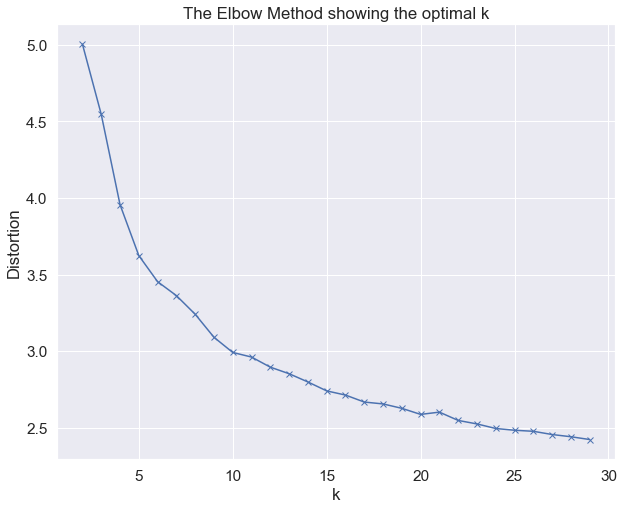

In [266]:
apply_elbow_method(X_train_scaled)

In [267]:
def correction(df_tt, train=True, scaler = RobustScaler(with_centering=True, with_scaling=True, quantile_range=(25.0, 75.0)),\
              kmeans = KMeans(n_clusters=15, random_state=42), clusters_columns = []):
    colnames = ['DistrictId', 'Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor', 'HouseFloor', 
           'HouseYear', 'Ecology_1', 'Ecology_3', 'Social_1', 'Social_2', 'Social_3', 'Healthcare_2',
           'Shops_1', 'Shops_2', 'Square_suspicious', 'LS_pick', 'LS_pick_0', 'LS_pick_1', 'LS_pick_2',
           'HouseYear1977', 'Rooms_outlier', 'DistrictId_cat',
           'new_district', 'FloorRatio', 'Floor_susp', 'First_floor', 'Last_floor', 'Ecology_1_cat', 
           'HouseYear_by_District', 'Price_by_District', 'Price_on_Square_by_District', 'HC_2_DI_cat', 'HC_1_isnull']
    colnames_rest = list(filter(lambda x: (x not in colnames), list(df_tt.columns)))
    df_tt_rest = df_tt[colnames_rest]
    df_tt = df_tt[colnames]
    
    if train:
        df_tt_scaled = pd.DataFrame(scaler.fit_transform(df_tt), columns=colnames)
        labels_clast = kmeans.fit_predict(df_tt_scaled)
        
        labels_clast = pd.Series(labels_clast, name='clusters')
        clusters_dummies = pd.get_dummies(labels_clast, drop_first=True, prefix='clusters')
        clusters_columns = clusters_dummies.columns       
    #----------------------------------------------------------------------
    else:
        df_tt_scaled = pd.DataFrame(scaler.transform(df_tt), columns=colnames)        
        labels_clast = kmeans.predict(df_tt_scaled)
        
        labels_clast = pd.Series(labels_clast, name='clusters')
        clusters_dummies = pd.get_dummies(labels_clast, drop_first=True, prefix='clusters')
        clusters_dummies = pd.DataFrame(clusters_dummies, columns = clusters_columns, index= df_tt.index)
        clusters_dummies = clusters_dummies.fillna(0)
    #------------------------------------------------------------------------    
    df_tt = pd.concat([df_tt, df_tt_rest, clusters_dummies], axis=1)
    

    return(df_tt, scaler, kmeans, clusters_columns)
#----------------------------------------
df_tt = df_copy
df_tt, scaler, kmeans, clusters_columns = correction(df_tt)

pretest(df_tt, "K_means")

R2: 0.753 +- 0.019
Action N33



,R2_score,STD,R2_Improving,STD_Improving,Action
33,0.752583,0.018502,0.001105,0.00104,K_means


### <font color=red>Pred_12: Cancel Pred_10 K-means changes.</font> 

In [268]:
pretest_cancel()

'The changes has been canceled'

In [269]:
"""df, scaler, kmeans, clusters_columns = correction(df)
df_test, scaler, kmeans, clusters_columns = correction(df_test, False, scaler, kmeans, clusters_columns)"""

'df, scaler, kmeans, clusters_columns = correction(df)\ndf_test, scaler, kmeans, clusters_columns = correction(df_test, False, scaler, kmeans, clusters_columns)'

***

### <font color=red>Pred_12: Use K-means to fill clusters by averages Price/Square ratios.</font> 

In [270]:
def correction(df_tt, train=True, scaler = RobustScaler(with_centering=True, with_scaling=True, quantile_range=(25.0, 75.0)),\
              kmeans = KMeans(n_clusters=15, random_state=42), pr_km_medians = []):
    #---------------------------------------------------------------------
    colnames = ['DistrictId', 'Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor', 'HouseFloor', 
           'HouseYear', 'Ecology_1', 'Ecology_3', 'Social_1', 'Social_2', 'Social_3', 'Healthcare_2',
           'Shops_1', 'Shops_2', 'Square_suspicious', 'LS_pick', 'LS_pick_0', 'LS_pick_1', 'LS_pick_2',
           'HouseYear1977', 'Rooms_outlier', 'DistrictId_cat',
           'new_district', 'FloorRatio', 'Floor_susp', 'First_floor', 'Last_floor', 'Ecology_1_cat', 
           'HouseYear_by_District', 'Price_by_District', 'Price_on_Square_by_District', 'HC_2_DI_cat', 'HC_1_isnull']
    colnames_rest = list(filter(lambda x: (x not in colnames), list(df_tt.columns)))
    df_tt_rest = df_tt[colnames_rest]
    df_tt = df_tt[colnames]
    #---------------------------------------------------------------------
    if train:
        df_tt_scaled = pd.DataFrame(scaler.fit_transform(df_tt), columns=colnames)
        labels_clast = kmeans.fit_predict(df_tt_scaled)
        labels_clast = pd.Series(labels_clast, name='clusters')
    #----------------------------------------------------------------------
    else:
        df_tt_scaled = pd.DataFrame(scaler.transform(df_tt), columns=colnames)        
        labels_clast = kmeans.predict(df_tt_scaled)
        labels_clast = pd.Series(labels_clast, name='clusters')
        #clusters_dummies = clusters_dummies.fillna(0)
    #------------------------------------------------------------------------    
    df_tt = pd.concat([df_tt, df_tt_rest, labels_clast], axis=1)
    #------------------------------------------------------------------------
    if train:
        df_tt['Price_on_Square'] = df_tt_rest['Price'] / df_tt['Square']
        pr_km_medians = df_tt[['clusters', 'Price_on_Square']].\
            groupby('clusters').median().to_dict()['Price_on_Square']
        df_tt.drop('Price_on_Square', axis= 'columns', inplace= True)
    #------------------------------------------------------------------------
    df_tt['Price_on_Square_by_clusters'] = df_tt['clusters'].map(pr_km_medians)
    df_tt.drop('clusters', axis= 'columns', inplace= True)
    #-------------------------------------------------------------------------
    return(df_tt, scaler, kmeans, pr_km_medians)
#----------------------------------------
df_tt = df.copy()
df_tt, scaler, kmeans, pr_km_medians = correction(df_tt)

pretest(df_tt, "K_means_12")

#---------------------------------------------------------------------------------------------------------

R2: 0.752 +- 0.019
Action N33



,R2_score,STD,R2_Improving,STD_Improving,Action
33,0.752235,0.01858,0.000757,0.000961,K_means_12


### <font color=red>Pred_13: Cancel Pred_12 K-means changes. The result on Publict decreased</font> 

In [271]:
pretest_cancel()

'The changes has been canceled'

In [272]:
"""df, scaler, kmeans, pr_km_medians = correction(df)
df_test, scaler, kmeans, pr_km_medians = correction(df_test, False, scaler, kmeans, pr_km_medians)"""

'df, scaler, kmeans, pr_km_medians = correction(df)\ndf_test, scaler, kmeans, pr_km_medians = correction(df_test, False, scaler, kmeans, pr_km_medians)'

***

In [273]:
pretest(df, 'Final check')

R2: 0.751 +- 0.020
Action N33



,R2_score,STD,R2_Improving,STD_Improving,Action
33,0.751478,0.019542,0.0,-0.0,Final check


In [274]:
r2_results

,R2_score,STD,R2_Improving,STD_Improving,Action
0,0.750244,0.019503,0.750244,-0.019503,Initial
1,0.750244,0.019503,0.000000,-0.000000,Rename column 'Helthcare_2' to 'Healthcare_2' ...
2,0.750244,0.019503,0.000000,-0.000000,Replace all categorical variables by binary
3,0.750244,0.019503,0.000000,-0.000000,New feature 'Square_suspicious': (df['Square']...
4,0.750857,0.017082,0.000614,0.002420,Multiply small Square and LifeSquare by 10 (df...
5,0.751217,0.017950,0.000359,-0.000868,Multiply rest small Square by 10 (df['Square']...
6,0.750832,0.020481,-0.000385,-0.002531,New feature: LifeSquareRatio
7,0.748606,0.020227,-0.002226,0.000254,Divide all observations where LifeSquareRatio ...
8,0.747783,0.019145,-0.000822,0.001081,Swap LifeSquare and Square for all LifeSquareR...
9,0.750531,0.018734,0.002748,0.000412,LifeSquare nan as Square * median ratio


In [275]:
r2_results[(r2_results['R2_Improving'] < 0) & (r2_results['STD_Improving'] < 0)]

,R2_score,STD,R2_Improving,STD_Improving,Action
6,0.750832,0.020481,-0.000385,-0.002531,New feature: LifeSquareRatio
21,0.754295,0.019842,-0.000080,-0.000931,New feature: FloorRatio
22,0.753383,0.020185,-0.000912,-0.000343,Mapping HouseFloor == 0 using avarage by Distr...
23,0.753330,0.020296,-0.000053,-0.000111,HouseFloor < Floor => Floor_susp
29,0.751702,0.020991,-0.001435,-0.002997,Mapping Price_by_District


In [276]:
r2_results[(r2_results['R2_Improving'] < 0) & (r2_results['STD_Improving'] > 0)]

,R2_score,STD,R2_Improving,STD_Improving,Action
7,0.748606,0.020227,-0.002226,0.000254,Divide all observations where LifeSquareRatio ...
8,0.747783,0.019145,-0.000822,0.001081,Swap LifeSquare and Square for all LifeSquareR...
13,0.752334,0.018167,-0.001242,0.000567,New feature KitchenSquareRatio
15,0.752851,0.018172,-0.000725,0.000562,Manually change two years
19,0.752689,0.017492,-0.000271,0.000537,DistrictId_cat No dummy categories
28,0.753137,0.017995,-0.000652,0.001773,Mapping HouseYear_by_District
31,0.751324,0.019677,-0.000453,0.000584,New feature Healthcare_2 + DistrictId_cat


In [277]:
df_final = df.copy()
df_test_final = df_test.copy()

In [278]:
df.loc[:, df.isnull().sum() != 0].isnull().sum()

Series([], dtype: float64)

In [279]:
df_test.loc[:, df_test.isnull().sum() != 0].isnull().sum()

Series([], dtype: float64)

# Simple model

In [280]:
non_categorical = [ 'Rooms', 'Square', 'LifeSquare', 'KitchenSquare',
                     'Floor', 'HouseFloor', 'HouseYear',
                    'FloorRatio', 'HouseYear_by_District', 'Price_by_District',
                     'Price_on_Square_by_District']

categorical = list(filter(lambda x: (x not in non_categorical) & (x not in ['Price', 'Id']), list(df.columns)))

print(f'Total number of columns: {len(list(df.columns))}')
print(f'Number of noncategorical columns: {len(non_categorical)}')
print(f'Number of categorical columns: {len(categorical)}')

Total number of columns: 242
Number of noncategorical columns: 11
Number of categorical columns: 229


In [281]:
print(categorical)

['DistrictId', 'Ecology_1', 'Ecology_3', 'Social_1', 'Social_2', 'Social_3', 'Healthcare_2', 'Shops_1', 'Shops_2', 'Square_suspicious', 'LS_pick', 'LS_pick_0', 'LS_pick_1', 'LS_pick_2', 'HouseYear1977', 'Rooms_outlier', 'DistrictId_cat', 'district_id_0', 'district_id_1', 'district_id_2', 'district_id_3', 'district_id_4', 'district_id_5', 'district_id_6', 'district_id_7', 'district_id_8', 'district_id_9', 'district_id_10', 'district_id_11', 'district_id_12', 'district_id_13', 'district_id_14', 'district_id_15', 'district_id_16', 'district_id_17', 'district_id_18', 'district_id_19', 'district_id_20', 'district_id_21', 'district_id_22', 'district_id_23', 'district_id_24', 'district_id_25', 'district_id_26', 'district_id_27', 'district_id_28', 'district_id_29', 'district_id_30', 'district_id_31', 'district_id_32', 'district_id_33', 'district_id_34', 'district_id_35', 'district_id_36', 'district_id_37', 'district_id_38', 'district_id_39', 'district_id_40', 'district_id_41', 'district_id_42'

In [282]:
min_samples_leaf=10
random_state=42
n_estimators= 120
max_depth = 7
X = df_final.drop('Price', axis=1)
y = df_final[['Price']]
X.set_index('Id', inplace=True)

lgb_model = LGBMRegressor(criterion='r2',
                            min_samples_leaf = min_samples_leaf,
                            random_state = random_state,
                            n_estimators = n_estimators,
                            max_depth = max_depth,
                          categorical_features = categorical
                        )

cv_score = cross_val_score(lgb_model, X, y, 
                       scoring='r2', 
                       cv=KFold(n_splits=5, shuffle=True, random_state=42))

mean = cv_score.mean()
std = cv_score.std()

print('R2: {:.4f} +- {:.4f}'.format(mean, std))

R2: 0.7515 +- 0.0195


In [283]:
X = df.drop('Price', axis=1)
y = df[['Price']]
X.set_index('Id', inplace=True)
lgb_model.fit(X, y)

LGBMRegressor(boosting_type='gbdt',
              categorical_features=['DistrictId', 'Ecology_1', 'Ecology_3',
                                    'Social_1', 'Social_2', 'Social_3',
                                    'Healthcare_2', 'Shops_1', 'Shops_2',
                                    'Square_suspicious', 'LS_pick', 'LS_pick_0',
                                    'LS_pick_1', 'LS_pick_2', 'HouseYear1977',
                                    'Rooms_outlier', 'DistrictId_cat',
                                    'district_id_0', 'district_id_1',
                                    'district_id_2', 'district_id_3',
                                    'district...
              class_weight=None, colsample_bytree=1.0, criterion='r2',
              importance_type='split', learning_rate=0.1, max_depth=7,
              min_child_samples=20, min_child_weight=0.001, min_samples_leaf=10,
              min_split_gain=0.0, n_estimators=120, n_jobs=-1, num_leaves=31,
              objecti

In [284]:
feature_importances = pd.DataFrame(zip(X.columns, 
                                       lgb_model .feature_importances_ / lgb_model .feature_importances_.sum()), 
                                   columns=['feature_name', 'importance'])

feature_importances.sort_values(by='importance', ascending=False, inplace=True)

In [285]:
select = feature_importances['importance'] > 0.001
major_features = feature_importances[select]
major_features.head(10)

,feature_name,importance
2,Square,0.124960
7,HouseYear,0.095406
8,Ecology_1,0.067138
3,LifeSquare,0.063604
0,DistrictId,0.059749
12,Social_3,0.056216
4,KitchenSquare,0.052682
5,Floor,0.051397
6,HouseFloor,0.049791
230,FloorRatio,0.048506


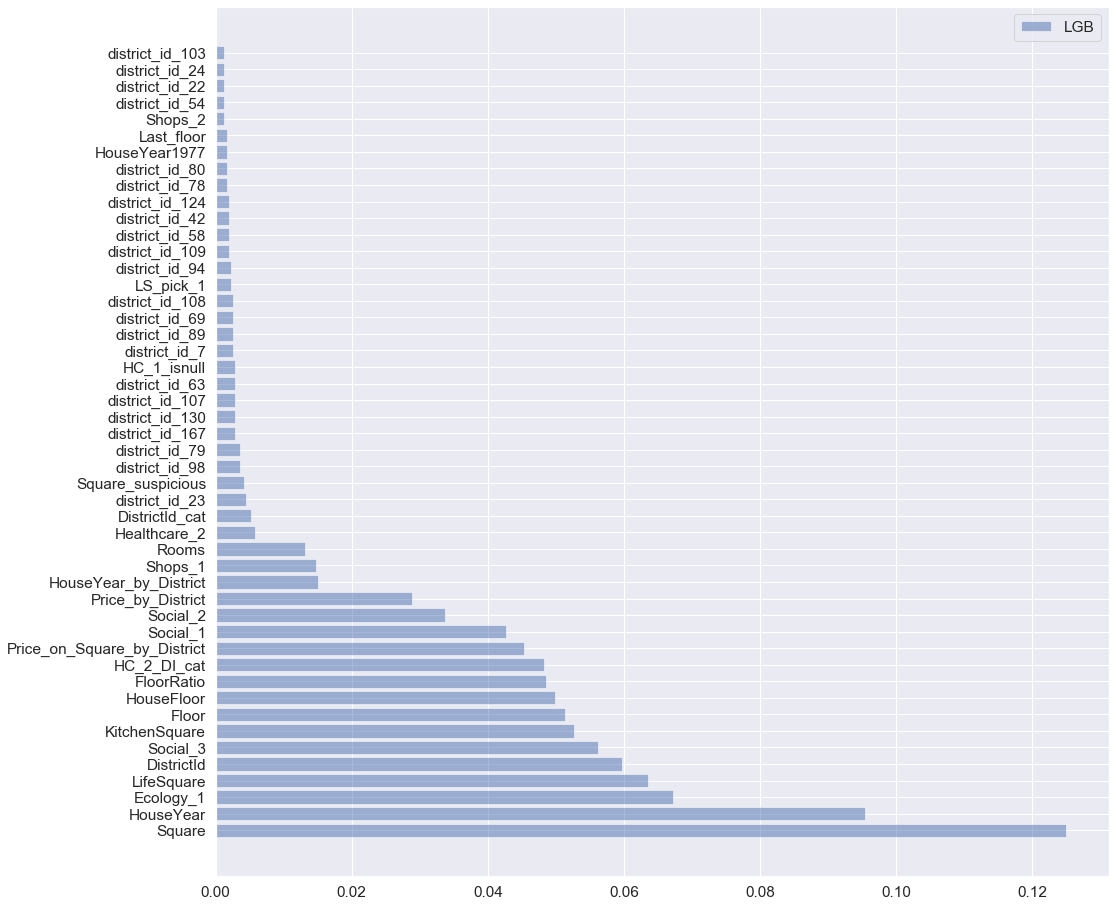

In [286]:
plt.figure(figsize = (16, 16))
plt.barh(y = major_features['feature_name'],
         width = major_features['importance'],
         alpha = 0.5, 
         label = 'LGB')
plt.legend()
plt.show()

In [287]:
list(major_features['feature_name'])
df_mf = df.filter(list(major_features['feature_name']))
df_mf = pd.concat([df_mf, df.filter(['Id', 'Price'])], axis= 'columns')
df_mf.columns

Index(['Square', 'HouseYear', 'Ecology_1', 'LifeSquare', 'DistrictId',
       'Social_3', 'KitchenSquare', 'Floor', 'HouseFloor', 'FloorRatio',
       'HC_2_DI_cat', 'Price_on_Square_by_District', 'Social_1', 'Social_2',
       'Price_by_District', 'HouseYear_by_District', 'Shops_1', 'Rooms',
       'Healthcare_2', 'DistrictId_cat', 'district_id_23', 'Square_suspicious',
       'district_id_98', 'district_id_79', 'district_id_167',
       'district_id_130', 'district_id_107', 'district_id_63', 'HC_1_isnull',
       'district_id_7', 'district_id_89', 'district_id_69', 'district_id_108',
       'LS_pick_1', 'district_id_94', 'district_id_109', 'district_id_58',
       'district_id_42', 'district_id_124', 'district_id_78', 'district_id_80',
       'HouseYear1977', 'Last_floor', 'Shops_2', 'district_id_54',
       'district_id_22', 'district_id_24', 'district_id_103', 'Id', 'Price'],
      dtype='object')

In [288]:
df_test_mf = df_test.filter(list(major_features['feature_name']))
df_test_mf = pd.concat([df_test_mf, df_test['Id']], axis= 'columns')

In [289]:
df_test_mf.head()

,Square,HouseYear,Ecology_1,LifeSquare,DistrictId,Social_3,KitchenSquare,Floor,HouseFloor,FloorRatio,...,district_id_78,district_id_80,HouseYear1977,Last_floor,Shops_2,district_id_54,district_id_22,district_id_24,district_id_103,Id
0,49.882645,1972,0.310199,33.432781,58,1,6.0,6,14.0,0.428571,...,0,0,0,0,0,0,0,0,0,725
1,69.263184,1977,0.075779,42.761948,74,3,1.0,6,1.0,6.000000,...,0,0,0,0,0,0,0,0,0,15856
2,15.948245,1909,0.000000,13.597818,190,87,12.0,2,5.0,0.400000,...,0,0,0,0,0,0,0,0,0,5480
3,73.046608,2007,0.101872,51.940842,47,3,9.0,22,22.0,1.000000,...,0,0,0,1,0,0,0,0,0,15664
4,47.527111,2017,0.072158,43.387569,27,1,1.0,17,17.0,1.000000,...,0,0,0,1,1,0,0,0,0,14275


In [290]:
non_categorical = [ 'Rooms', 'Square', 'LifeSquare', 'KitchenSquare',
                     'Floor', 'HouseFloor', 'HouseYear',
                    'FloorRatio', 'HouseYear_by_District', 'Price_by_District',
                     'Price_on_Square_by_District']

categorical = list(filter(lambda x: (x not in non_categorical) & (x not in ['Price', 'Id']), list(df_mf.columns)))

print(f'Total number of columns: {len(list(df_mf.columns))}')
print(f'Number of noncategorical columns: {len(non_categorical)}')
print(f'Number of categorical columns: {len(categorical)}')

Total number of columns: 50
Number of noncategorical columns: 11
Number of categorical columns: 37


In [291]:
min_samples_leaf=10
random_state=42
n_estimators= 120
max_depth = 11
X = df_mf.drop('Price', axis=1)
y = df_mf[['Price']]
X.set_index('Id', inplace=True)

lgb_model = LGBMRegressor(criterion='r2',
                            min_samples_leaf = min_samples_leaf,
                            random_state = random_state,
                            n_estimators = n_estimators,
                            max_depth = max_depth,
                          categorical_features = categorical
                        )

cv_score = cross_val_score(lgb_model, X, y, 
                       scoring='r2', 
                       cv=KFold(n_splits=5, shuffle=True, random_state=42))

mean = cv_score.mean()
std = cv_score.std()

print('R2: {:.4f} +- {:.4f}'.format(mean, std))

R2: 0.7531 +- 0.0183


In [292]:
df_final = df_mf
df_test_final = df_test_mf

In [293]:
X = df_final.drop('Price', axis=1)
y = df_final[['Price']]
X.set_index('Id', inplace=True)
lgb_model.fit(X, y)

LGBMRegressor(boosting_type='gbdt',
              categorical_features=['Ecology_1', 'DistrictId', 'Social_3',
                                    'HC_2_DI_cat', 'Social_1', 'Social_2',
                                    'Shops_1', 'Healthcare_2', 'DistrictId_cat',
                                    'district_id_23', 'Square_suspicious',
                                    'district_id_98', 'district_id_79',
                                    'district_id_167', 'district_id_130',
                                    'district_id_107', 'district_id_63',
                                    'HC_1_isnull', 'district_id_7',
                                    'distri...
              class_weight=None, colsample_bytree=1.0, criterion='r2',
              importance_type='split', learning_rate=0.1, max_depth=11,
              min_child_samples=20, min_child_weight=0.001, min_samples_leaf=10,
              min_split_gain=0.0, n_estimators=120, n_jobs=-1, num_leaves=31,
              objectiv

***

In [294]:
X_final = df_test_final.copy()
X_final.set_index('Id', inplace=True)
X_final = pd.DataFrame(X_final)
print('Rows in test', X_final.shape[0])

Rows in test 5000


In [295]:
X_final.loc[:, X_final.isnull().sum() != 0].isnull().sum()

Series([], dtype: float64)

In [296]:
final_model = lgb_model
with open('model_13.pkl', 'wb') as file:
    pickle.dump(final_model, file)

y_pred_final = final_model.predict(X_final)

preds_final = pd.DataFrame()
preds_final['Id'] = X_final.index
preds_final['Price'] = y_pred_final
preds_final.to_csv('predictions13.csv', index=False)

preds_final.head()

,Id,Price
0,725,156438.617864
1,15856,214583.928505
2,5480,238956.118254
3,15664,333475.057338
4,14275,141533.324728


# 0.753 +- 0.183 => 0.75479 (Pred_13) ? 0.75718 (Pred_72) should be eqaul to

***

# **Blending**

## Mix with RF-Baseline_new 50/50

In [297]:
subm_b = pd.read_csv('predictions_base.csv')
print(subm_b['Price'].mean())
subm_b.head(2)

216024.54291758427


,Id,Price
0,725,162584.556432
1,15856,248932.174897


### 74447

In [298]:
subm_13 = pd.read_csv('predictions13.csv')
print(subm_13['Price'].mean())
subm_13.head(2)

215911.50550675107


,Id,Price
0,725,156438.617864
1,15856,214583.928505


### 75479

In [299]:
subm_mix = subm_b.copy()
subm_mix['Price'] = 0.5 * subm_b['Price'] + 0.5 * subm_13['Price']
print(subm_mix['Price'].mean())
subm_mix.head(2)

215968.02421216713


,Id,Price
0,725,159511.587148
1,15856,231758.051701


In [300]:
subm_mix.to_csv('mix2_13_base.csv', index=False)

## 75893

### Mix with RF-Baseline_new and prediction2 34/33/33 (prediction_2 was the uncompleted this pipline)

In [301]:
subm_2 = pd.read_csv('predictions2.csv')
print(subm_2['Price'].mean())
subm_2.head(2)

215458.588408597


,Id,Price
0,725,163992.981349
1,15856,227083.196497


### 74283

In [302]:
subm_mix = subm_b.copy()
subm_mix['Price'] = 0.33 * subm_b['Price'] + 0.34 * subm_13['Price'] + 0.33 * subm_2['Price']
print(subm_mix['Price'].mean())
subm_mix.head(2)

215799.34520993452


,Id,Price
0,725,160959.717542
1,15856,230043.608252


In [303]:
subm_mix.to_csv('mix3_13_base_2.csv', index=False)

# 75977 (? should be equal to pred_72_mix_3 = 0.76102